## Imports

In [1]:
# general utilities // 
from GeneralUtils import GeneralUtils
import pickle

# data manipulation
import pandas as pd
import numpy as np

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
import statistics as st

# preprocessing
from sklearn.preprocessing import MinMaxScaler

# feature selection
from boruta import BorutaPy
from sklearn.ensemble import ExtraTreesClassifier

# machine learning
from collections import Counter
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split

# Importing images to the kernel
from IPython.display import Image
from IPython.core.display import HTML

# algorithms
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# model evaluation
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import classification_report, cohen_kappa_score, roc_curve, brier_score_loss

# model calibration
from sklearn.calibration import CalibratedClassifierCV

# Helper Functions

In [2]:
gu = GeneralUtils()

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    %config InlineBackend.figure_format = 'retina'

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.options.display.float_format = '{:,.4f}'.format
    pd.set_option('display.expand_frame_repr', False)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)

    sns.set()

jupyter_settings()


SEED = 42

Populating the interactive namespace from numpy and matplotlib


In [4]:
def descriptive_stat(dataframe):

    # Central Tendency - mean, median, mode
    ct_mean = pd.DataFrame(dataframe.apply(np.mean)).T
    ct_median = pd.DataFrame(dataframe.apply(np.median)).T
    ct_mode = pd.DataFrame(dataframe.apply(st.mode)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    dp_std = pd.DataFrame(dataframe.apply(np.std)).T
    dp_min = pd.DataFrame(dataframe.apply(min)).T
    dp_max = pd.DataFrame(dataframe.apply(max)).T
    dp_range = pd.DataFrame(dataframe.apply(lambda x: x.max() - x.min())).T
    dp_skew = pd.DataFrame(dataframe.apply(lambda x: x.skew())).T
    dp_kurtosis = pd.DataFrame(dataframe.apply(lambda x: x.kurtosis())).T

    # concatenate
    m = pd.concat([dp_min, dp_max, dp_range, ct_mean, ct_median, ct_mode, dp_std, dp_skew, dp_kurtosis]).T.reset_index()
    m.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'mode', 'std', 'skew','kurtosis'])

    return m

In [5]:
# Quantiles of Boxplot
def boxqt(df):
    Q0 = np.quantile(df, .0)
    Q1 = np.quantile(df, .25)
    Q2 = np.quantile(df, .50)
    Q3 = np.quantile(df, .75)
    Q4 = np.quantile(df, 1.0)
    return print('Q0 is {}\nQ1 is {}\nQ2 is {}\nQ3 is {}\nQ4 is {}'.format(Q0, Q1, Q2, Q3, Q4))

In [6]:
def feature_relevance(model, x, y):
    fit_model = model.fit(x, y)
    
    cols = x.columns
    score = fit_model.feature_importances_
    score_df = pd.DataFrame({'Feature': cols, 'Score': score}).sort_values(by = 'Score', ascending = False).reset_index(drop = True)
    
    return score_df

In [7]:
def TestAccurancy( test, prediction):
    correct = 0
    for i in range(test.shape[0]):
        if test[i][0] == prediction[i]:
            correct += 1
    return (correct/test.shape[0])*100

def plotAccurancy(accuracy):
    plt.plot(accuracy)
    plt.xlabel('k-values')
    plt.ylabel('Accuracy')

In [8]:
def cramers_stat(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

## Load Dataset

In [9]:
data_raw = pd.read_csv('dataset/cardio_train.csv', delimiter=';')
df, validação = train_test_split(data_raw, test_size=0.1)

In [10]:
data_out = validação[['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
                       'cholesterol', 'gluc', 'smoke', 'alco', 'active']]

In [11]:
data_out.to_csv('dataset/cardiovascularDisease.csv')

# 1. Data Description

## 1.1 Data Dimentions

In [12]:
print('Número de linhas é {}'.format(df.shape[0]))
print('Número de colunas é {}'.format(df.shape[1]))

Número de linhas é 63000
Número de colunas é 13


## 1.2 Data Type

In [13]:
df.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

## 1.3 NA Check

In [14]:
df.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## 1.4 Changing data

In [15]:
# age - days/365
year = lambda x : x/365
df['age_years'] = list(map( year, df['age'] ) )
df['age_years'] = df['age_years'].astype( int )


# Weight
df['weight'] = df['weight'].astype( int )


<ipython-input-15-1ac90a06a415>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_years'] = list(map( year, df['age'] ) )
<ipython-input-15-1ac90a06a415>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_years'] = df['age_years'].astype( int )
<ipython-input-15-1ac90a06a415>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

## 1.5 Check Balanced Data

In [16]:
df['cardio'].value_counts( normalize=True )

0   0.5007
1   0.4993
Name: cardio, dtype: float64

## 1.6 Descript Analysis

In [17]:
descriptive_stat(df)

attributes         min         max       range        mean      median        mode         std    skew   kurtosis
0            id      0.0000 99,999.0000 99,999.0000 49,914.9148 49,900.0000 47,366.0000 28,851.8546  0.0023    -1.1984
1           age 10,798.0000 23,713.0000 12,915.0000 19,465.8017 19,700.0000 18,236.0000  2,471.2241 -0.3078    -0.8237
2        gender      1.0000      2.0000      1.0000      1.3488      1.0000      1.0000      0.4766  0.6345    -1.5975
3        height     55.0000    250.0000    195.0000    164.3671    165.0000    165.0000      8.2210 -0.6303     8.0130
4        weight     10.0000    200.0000    190.0000     74.1967     72.0000     65.0000     14.3919  0.9997     2.4864
5         ap_hi   -150.0000 16,020.0000 16,170.0000    129.0106    120.0000    120.0000    162.0969 81.2732 6,862.6114
6         ap_lo    -70.0000 11,000.0000 11,070.0000     96.6258     80.0000     80.0000    189.9324 32.3499 1,437.8694
7   cholesterol      1.0000      3.0000      2.0000      1.3671      1.0000      1.0000      0.6803  1.5858     0.9904
8          gluc      1.0000      3.0000      2.0000      1.2257      1.0000      1.0000      0.5711  2.4031     4.3260
9         smoke      0.0000      1.0000      1.0000      0.0877      0.0000      0.0000      0.2829  2.9146     6.4954
10         alco      0.0000      1.0000      1.0000      0.0539      0.0000      0.0000      0.2258  3.9508    13.6094
11       active      0.0000      1.0000      1.0000      0.8037      1.0000      1.0000      0.3972 -1.5295     0.3393
12       cardio      0.0000      1.0000      1.0000      0.4993      0.0000      0.0000      0.5000  0.0027    -2.0001
13    age_years     29.0000     64.0000     35.0000     52.8321     53.0000     55.0000      6.7780 -0.3064    -0.8195

**Pontos chave:**

**1.** A média da idade é 52 anos, variando entre 29 á 64 anos.

**2.** Há mais mulheres do que homens no conjunto de dados.

**3.** Glicose e o nível de colesterol estão normais para a maioria das pessoas.

**4.** A maioria das pessoas não fumam, não bebem e não praticam esportes.

**5.** Algumas variáveis possuem outliers de acordo com sua skew.
- height        : Skew moderadamente negativa
- weight        : Skew moderamente positiva
- ap_hi; ap_lo  : Skew altamente positiva

## 1.7 Outliers

### 1.7.1 Boxplots  with outliers

C:\Users\tulio.carvalho\Anaconda3\envs\CardiovascularDisease\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tulio.carvalho\Anaconda3\envs\CardiovascularDisease\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tulio.carvalho\Anaconda3\envs\CardiovascularDisease\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an exp

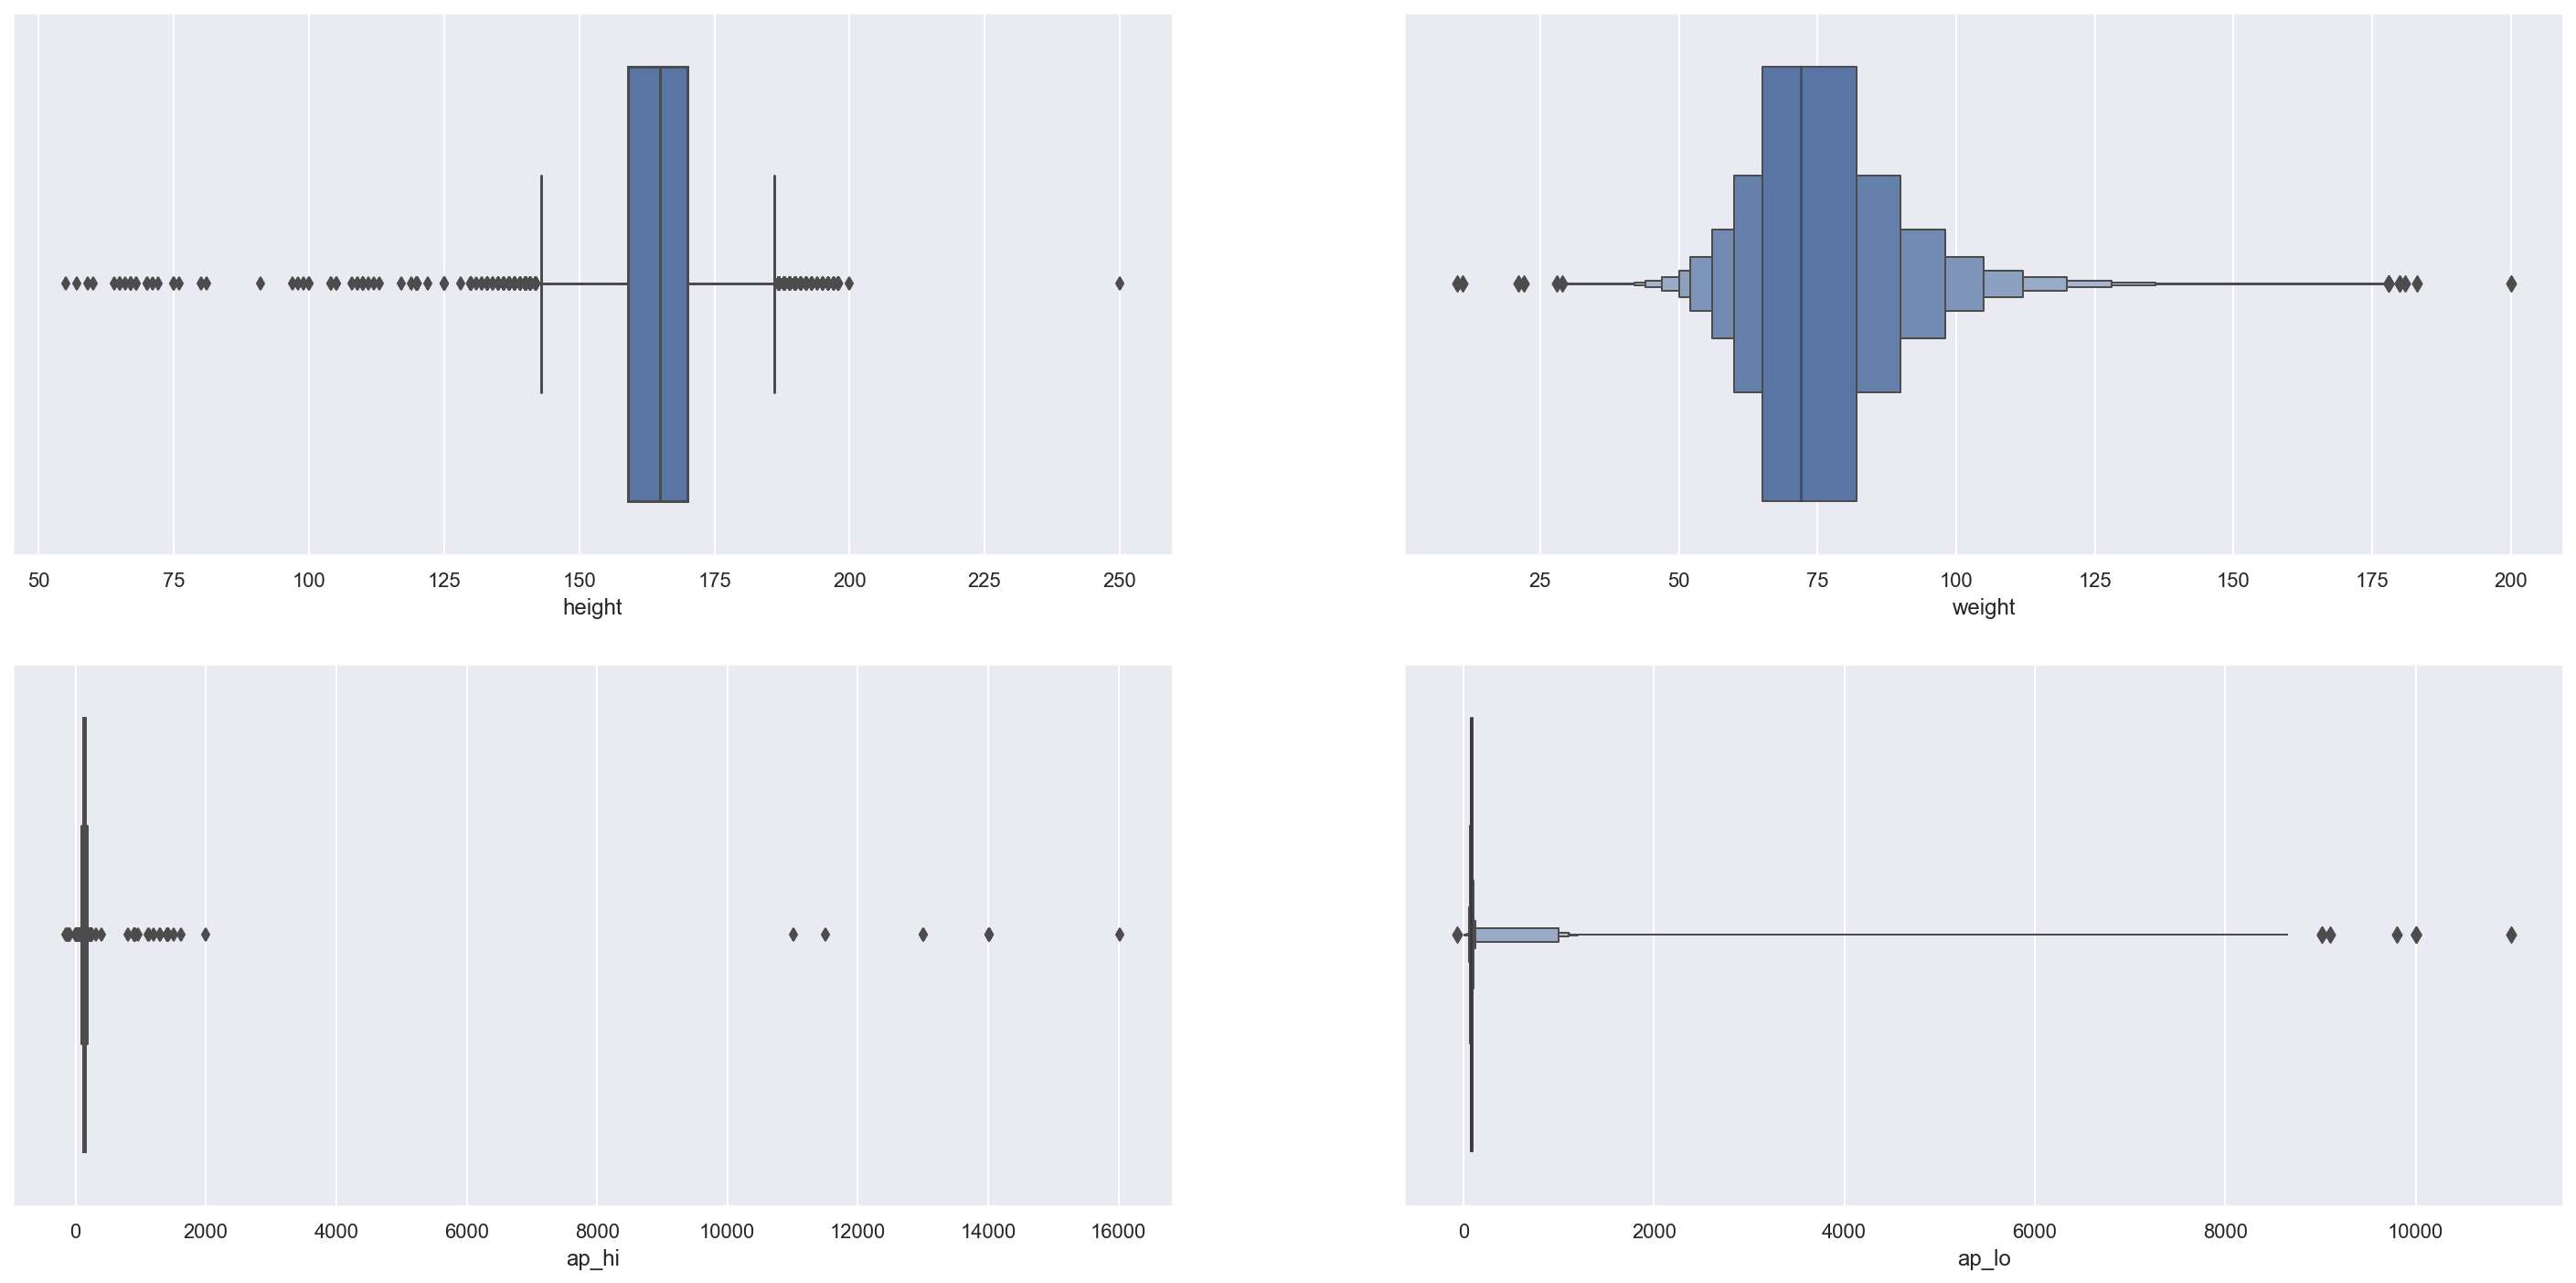

In [18]:
# Boxplot of height
plt.subplot(2,2,1)
sns.boxplot(df['height'])

# Boxplot of weight
plt.subplot(2,2,2)
sns.boxenplot(df['weight'])

# Boxplot of ap_hi
plt.subplot(2,2,3)
sns.boxplot(df['ap_hi'])

# Boxplot of ap_lo
plt.subplot(2,2,4) 
sns.boxenplot(df['ap_lo']);

### 1.7.2 Boxplots sem Outliers

C:\Users\tulio.carvalho\Anaconda3\envs\CardiovascularDisease\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tulio.carvalho\Anaconda3\envs\CardiovascularDisease\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tulio.carvalho\Anaconda3\envs\CardiovascularDisease\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an exp

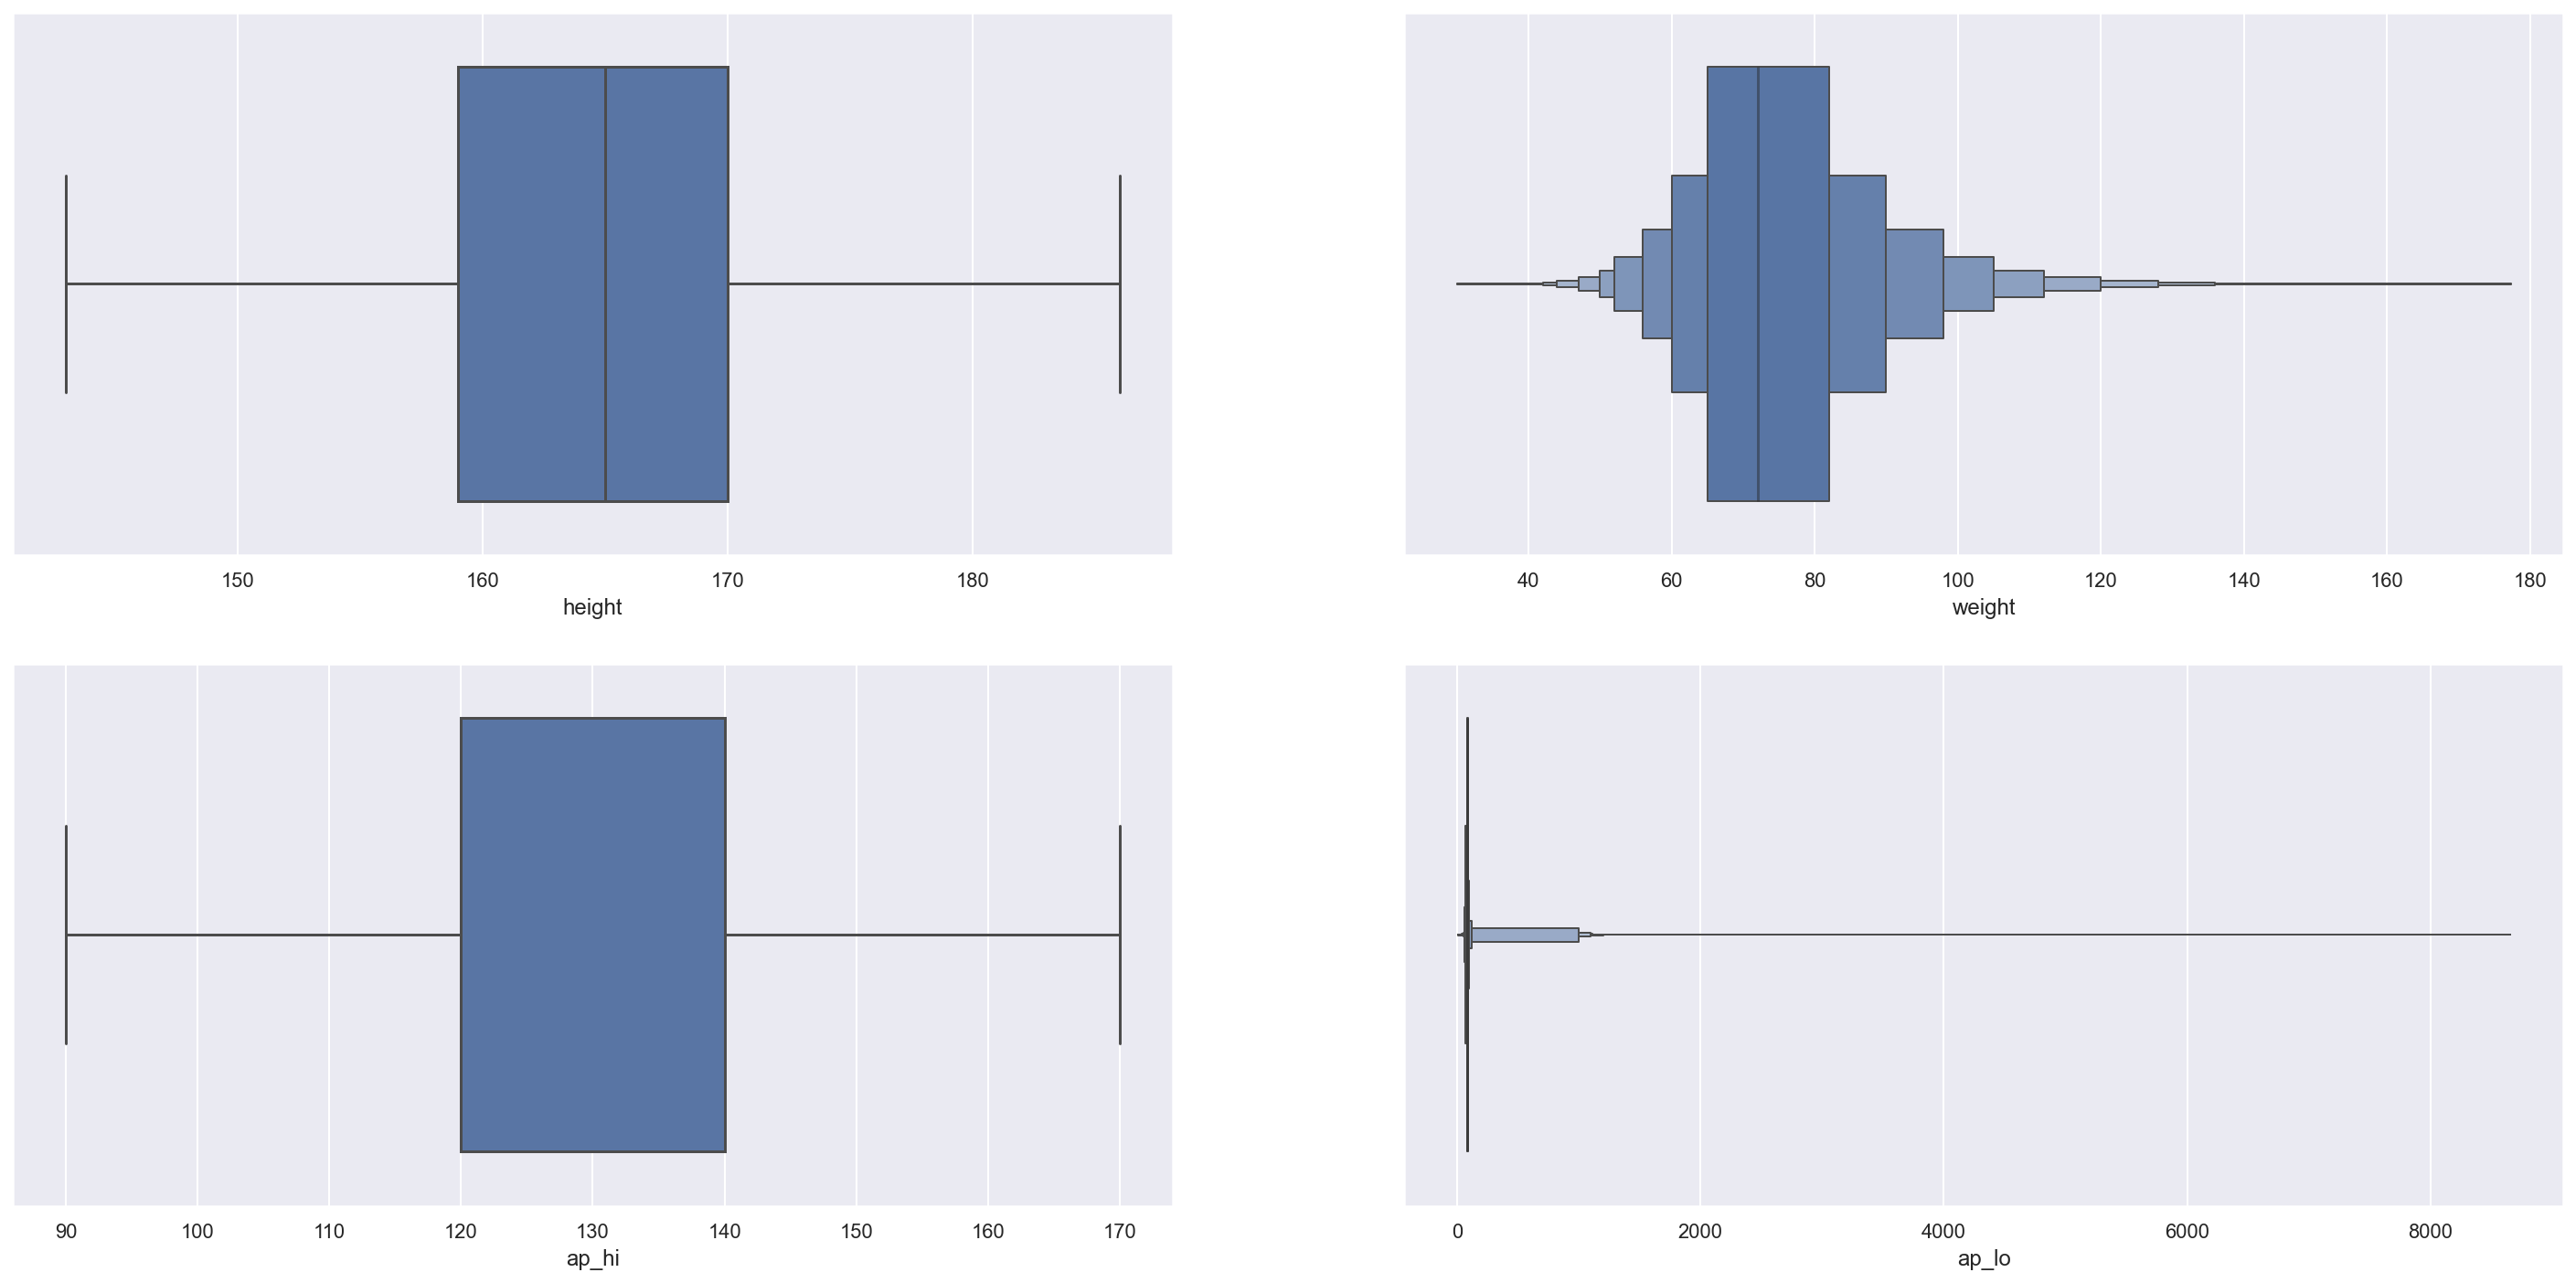

In [19]:
# Boxplot height
plt.subplot(221)
sns.boxplot(df['height'], showfliers = False)

# Boxplot weight
plt.subplot(222)
sns.boxenplot(df['weight'], showfliers = False)

# Boxplot ap_hi
plt.subplot(223)
sns.boxplot(df['ap_hi'], showfliers = False)

# Boxplot ap_lo
plt.subplot(224) 
sns.boxenplot(df['ap_lo'], showfliers = False);

###  Para esclarecer as divisões de cada boxplot foi calculado os quartis de cada variável.

In [20]:
# height
boxqt(df['height'])

Q0 is 55.0
Q1 is 159.0
Q2 is 165.0
Q3 is 170.0
Q4 is 250.0


In [21]:
# Weight
boxqt(df['weight'])

Q0 is 10.0
Q1 is 65.0
Q2 is 72.0
Q3 is 82.0
Q4 is 200.0


In [22]:
# ap_hi
boxqt(df['ap_hi'])

Q0 is -150.0
Q1 is 120.0
Q2 is 120.0
Q3 is 140.0
Q4 is 16020.0


In [23]:
# ap_lo
boxqt(df['ap_lo'])

Q0 is -70.0
Q1 is 80.0
Q2 is 80.0
Q3 is 90.0
Q4 is 11000.0


### 1.7.3 Entendendo casos individuais

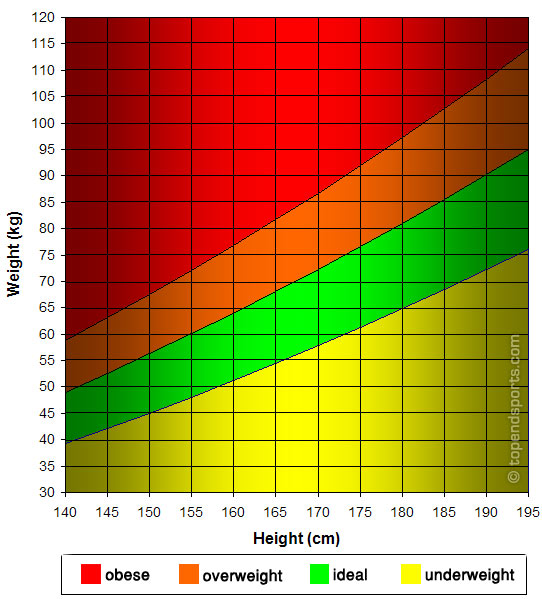

In [24]:
Image("img/wxh.jpg")

#### 1.7.3.1 Height

In [25]:
aux = df.sort_values(by=['height'], ascending=False).head(10)
aux

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active  cardio  age_years
6486    9223  21220       1     250      86    140    100            3     1      0     0       1       1         58
41901  59847  19187       2     200     100    170   1100            2     2      0     0       1       1         52
3237    4561  16072       2     198      61    110     70            1     1      0     0       1       1         44
30127  43083  23274       1     198      85    110     90            1     1      0     0       1       0         63
63154  90183  22192       2     198      58    110     70            1     1      0     0       0       0         60
40090  57307  21201       1     198      99    140     80            1     1      0     0       1       1         58
54289  77425  21416       2     198     110    140     80            2     3      0     0       1       1         58
50212  71657  16671       1     198      75    170    100            2     1      0     1       1       1         45
1117    1554  22156       2     198      68    120     80            1     1      0     0       1       1         60
29145  41642  21812       2     198      90    130     90            1     1      0     0       1       1         59

Com base na literatura é improvável que alguém com gigantismo e uma altura de 2,50 m.

In [26]:
aux = df.sort_values(by=['height'], ascending=True).head(20)
aux

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active  cardio  age_years
22723  32456  23386       1      55      81    130     90            1     1      0     0       1       1         64
66643  95141  18830       1      57      61    130     90            1     1      0     0       1       1         51
64115  91523  18426       1      59      57    125     67            1     1      0     0       0       0         50
29157  41661  19088       1      60      69    110     70            1     1      0     0       0       0         52
27603  39462  20978       1      64      61    130     70            1     1      0     0       1       0         57
44490  63545  19120       1      65      60    120     80            1     1      0     0       1       0         52
33607  48009  19709       2      65      72    130     80            1     1      0     0       0       0         53
64454  92008  21348       1      66      63     12     80            1     1      0     0       0       1         58
53344  76116  20541       2      67      80    120     80            1     1      0     0       0       1         56
50789  72476  14499       2      67      60    110     80            1     1      1     1       1       0         39
14323  20459  22005       1      67      57    120     90            1     1      0     0       1       1         60
46319  66161  21006       2      68      71    120     80            1     1      0     0       1       0         57
22542  32207  14538       1      68      65    100     60            1     1      0     0       0       0         39
51459  73386  15432       2      70      69    120     80            1     1      0     0       0       0         42
7598   10843  14661       2      70      72    120      8            1     1      0     0       1       0         40
13265  18928  22456       2      71      68    120     80            3     1      0     0       1       0         61
32098  45832  15374       1      72      74    150     90            1     1      0     0       1       1         42
47352  67631  23297       1      75      75    120     80            1     1      0     0       1       0         63
12770  18218  19594       1      75     168    120     80            1     1      1     0       1       1         53
224      309  21800       2      76      55    120     80            1     1      0     0       1       0         59

Os menores pacientes têm a altura de uma criança, mas a faixa etária é de 29 a 64 anos. Mesmo pessoas com nanismo têm uma faixa de altura média mínima de 1,20m a 1,40 m.

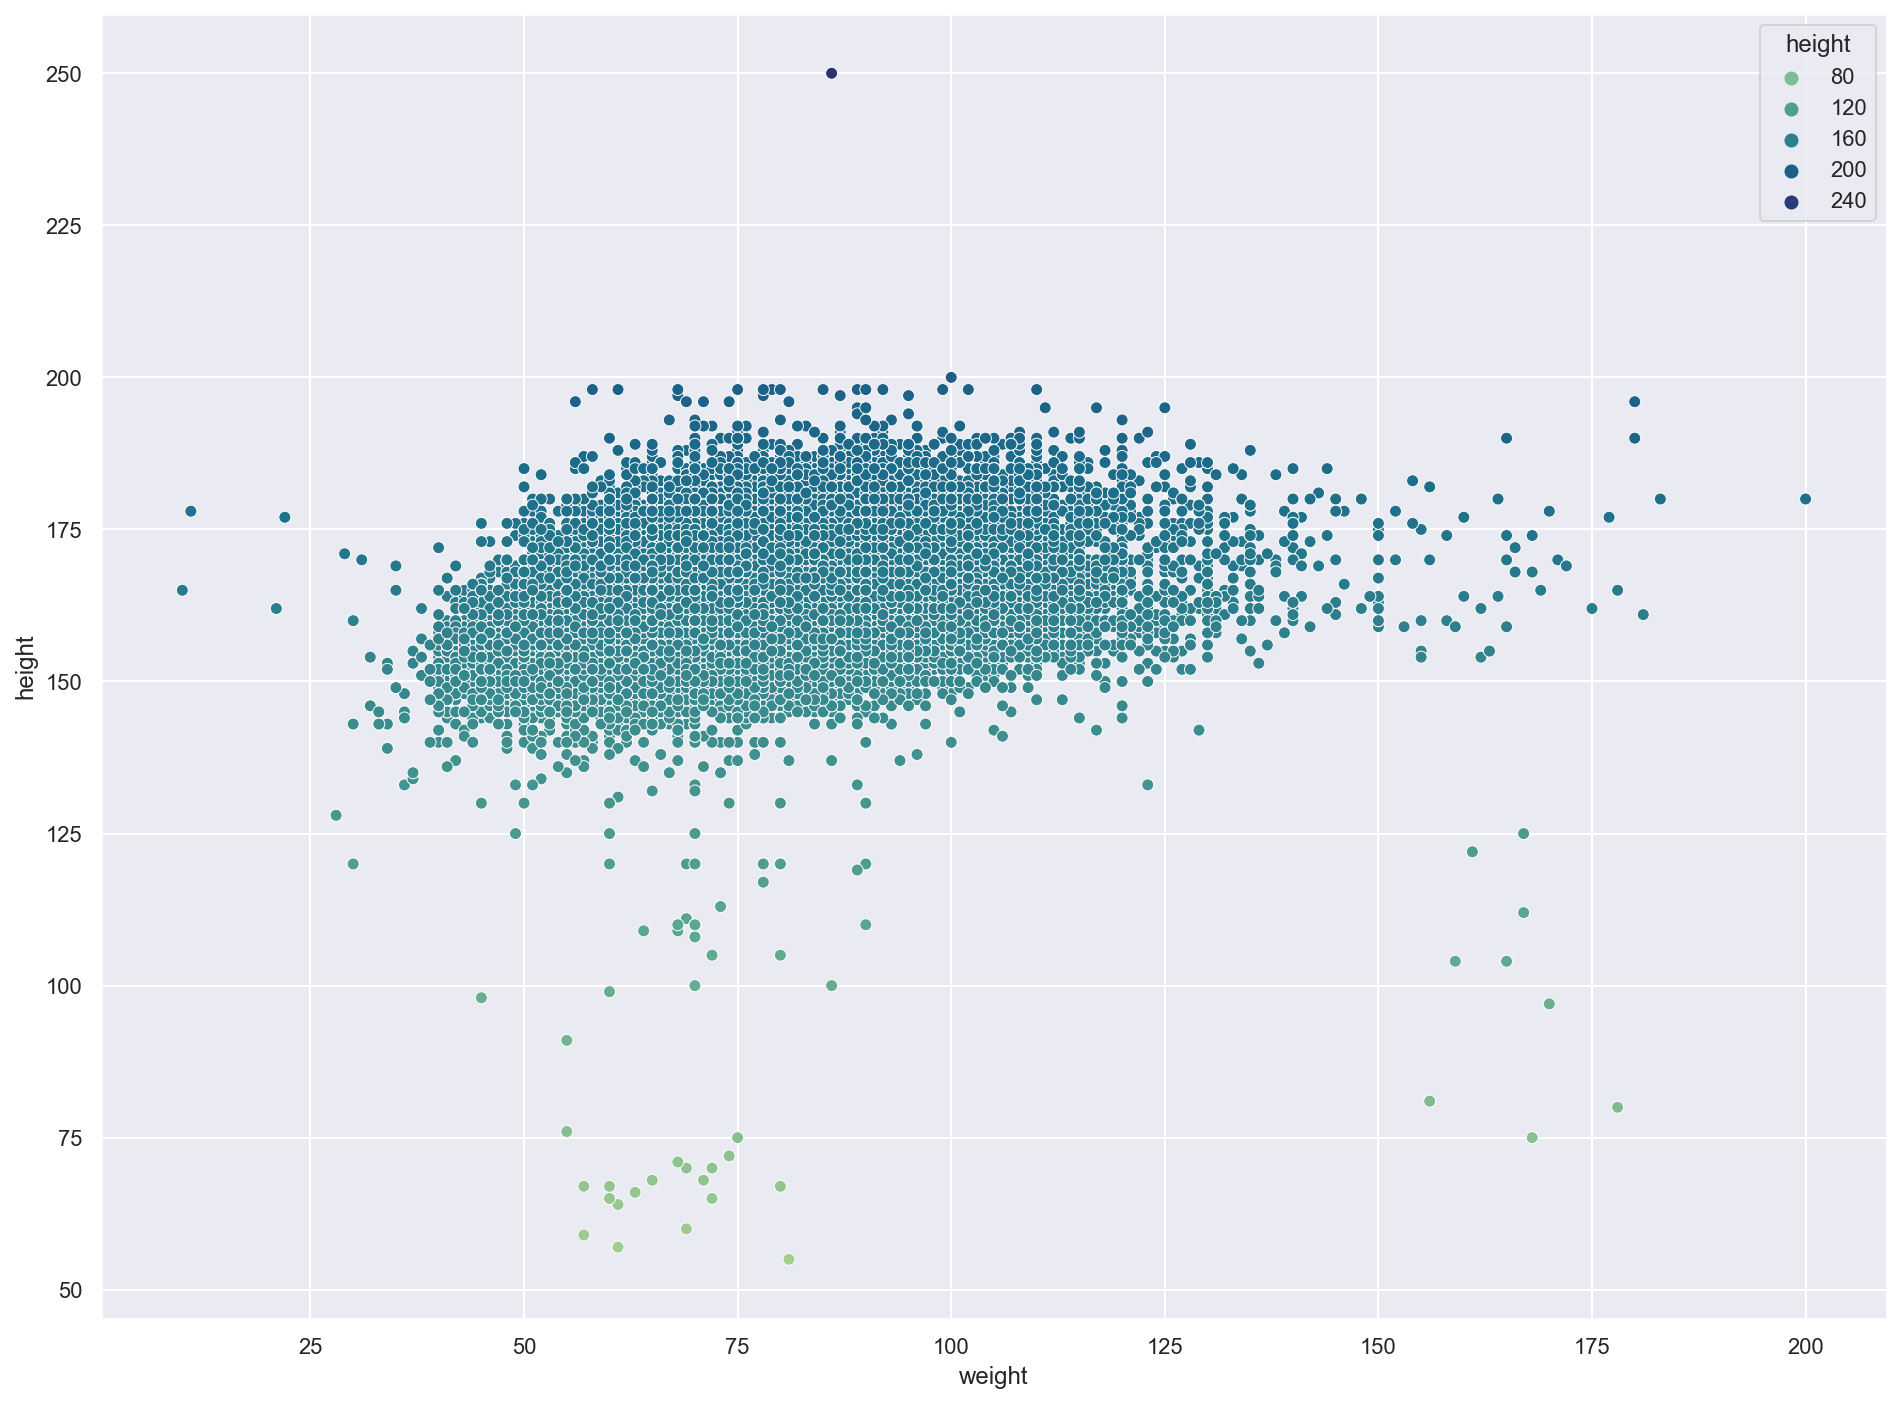

In [27]:
plt.figure(figsize = (16,12))
sns.scatterplot(data = df, x = 'weight', y = 'height', hue='height', palette = 'crest');

O gráfico mostra casos muito improváveis. Por exemplo, uma pessoa com uma altura de 75 cm e um peso de 170 Kg

 Com base em análises anteriores, optou-se por trocar o paciente com altura de 2,50 m e pacientes abaixo de 1,20 m pela altura média.

In [28]:
# Calculo da altura média
height_mean = df['height'].mean()
height_mean

164.36707936507938

In [29]:
# Aplicando a média para os valores em outlier
df['height'] = df['height'].apply(lambda x: 164 if x > 210 or x < 120 else x)

<ipython-input-29-fc295d53fa4c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['height'] = df['height'].apply(lambda x: 164 if x > 210 or x < 120 else x)


#### 1.7.3.2 Weight

In [30]:
aux = df.sort_values(by=['weight'], ascending=False).head(10)
aux

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active  cardio  age_years
50413  71945  15117       2     180     200    150     90            1     1      0     0       1       1         41
61285  87498  20939       2     180     183    110     80            3     3      0     1       1       1         57
36780  52564  19630       1     161     181    180   1100            2     1      0     0       1       1         53
45378  64829  17418       2     190     180    140     80            2     2      0     0       1       1         47
61362  87612  16615       2     196     180    130     80            3     1      0     0       1       1         45
61788  88220  18956       2     165     178    120     80            1     1      0     0       1       0         51
20092  28683  20656       2     165     178    120     80            1     1      1     1       1       0         56
27384  39156  15292       1     164     178    140     90            3     3      0     0       1       1         41
2441    3438  19171       2     177     177    130     90            1     1      0     0       1       1         52
37590  53670  19909       1     162     175    140   1000            1     1      0     0       1       1         54

 Com base na literatura é possível que as pessoas pesem 200kg.

In [31]:
aux = df.sort_values(by=['weight'], ascending=True).head(15)
aux

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active  cardio  age_years
57858  82567  18804       2     165      10    180   1100            2     2      0     0       1       1         51
33817  48318  21582       2     178      11    130     90            1     1      0     0       1       1         59
60188  85931  21855       1     162      21    120     80            2     1      0     0       1       1         59
29488  42156  20408       2     177      22    120     80            1     1      1     1       1       0         55
34276  48976  14664       2     128      28    120     80            1     1      0     0       1       0         40
60699  86650  18875       1     171      29    110     70            2     1      0     0       1       1         51
3752    5306  15400       1     120      30    110     70            1     1      0     0       1       0         42
18559  26503  18140       1     160      30    120     80            1     1      0     0       1       1         49
41905  59853  21334       1     143      30    103     61            2     1      0     0       1       0         58
16906  24167  17272       2     170      31    150     90            2     2      0     0       1       1         47
35314  50443  19802       1     146      32    130     80            1     2      0     0       0       0         54
38417  54851  21809       1     154      32    110     60            1     1      0     0       1       0         59
22016  31439  15359       1     146      32    100     70            1     1      0     0       0       0         42
65082  92896  22688       1     145      33    130   1000            2     1      0     0       1       1         62
48080  68667  19255       1     143      33    100     60            1     1      0     0       1       0         52

Com base na literatura é improvável que algumas pessoas pesem a baixo de 40kg.

Com base nas análises anteriores, optou-se por trocar pesos abaixo de 40kg pela média.

In [32]:
# Calculo do  peso médio
weight_mean = df['weight'].mean()
weight_mean

74.19674603174603

In [33]:
df['weight'] = df['weight'].apply( lambda x: 74 if x<40 else x)

<ipython-input-33-52fc51ba4e4d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight'] = df['weight'].apply( lambda x: 74 if x<40 else x)


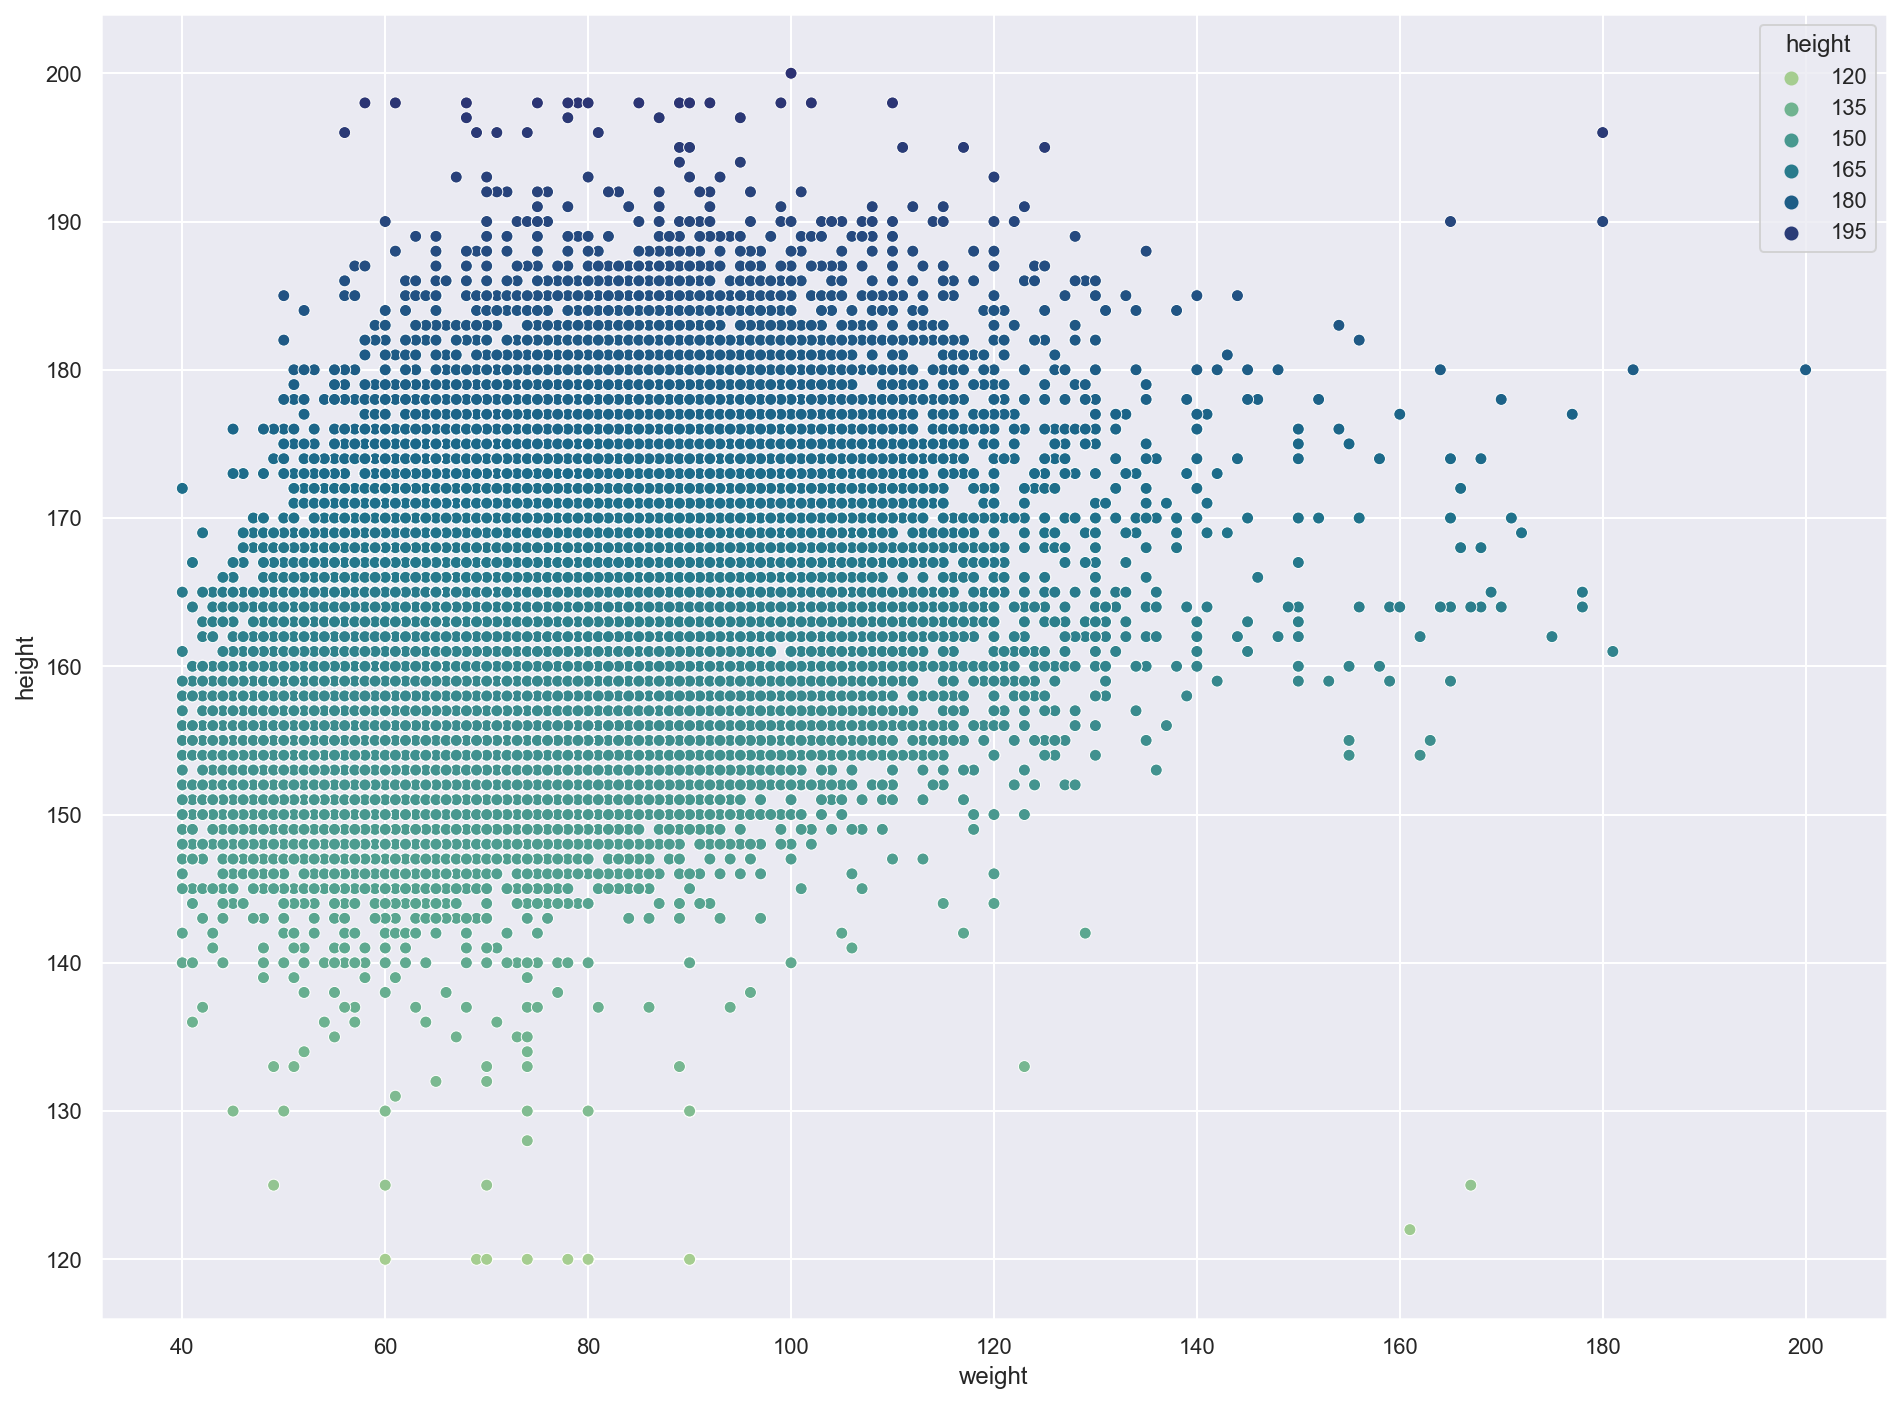

In [34]:
# Scatterplot depois dos tratamentos de outliers
plt.figure(figsize = (16,12))
sns.scatterplot(data = df, x = 'weight', y = 'height', hue='height', palette = 'crest');

Analisando o gráfico novamente os cortes que foram feitos são perceptíveis, mas parece que os dados fazem mais sentido depois da substituição dos outliers

 #### 1.7.3.3 ap_lo (Pressão de sangue diastólica)

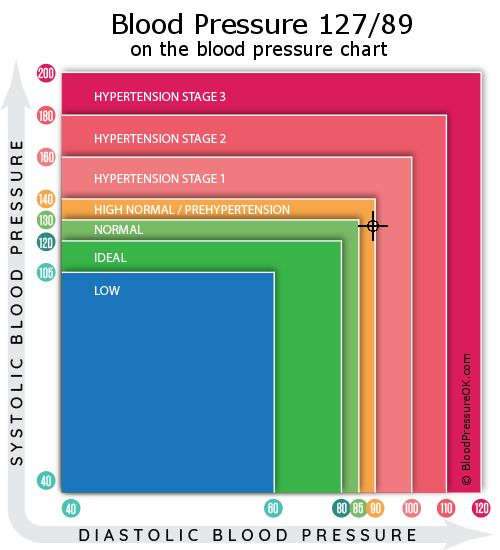

In [35]:
Image('img/bloodpresure.jpg')

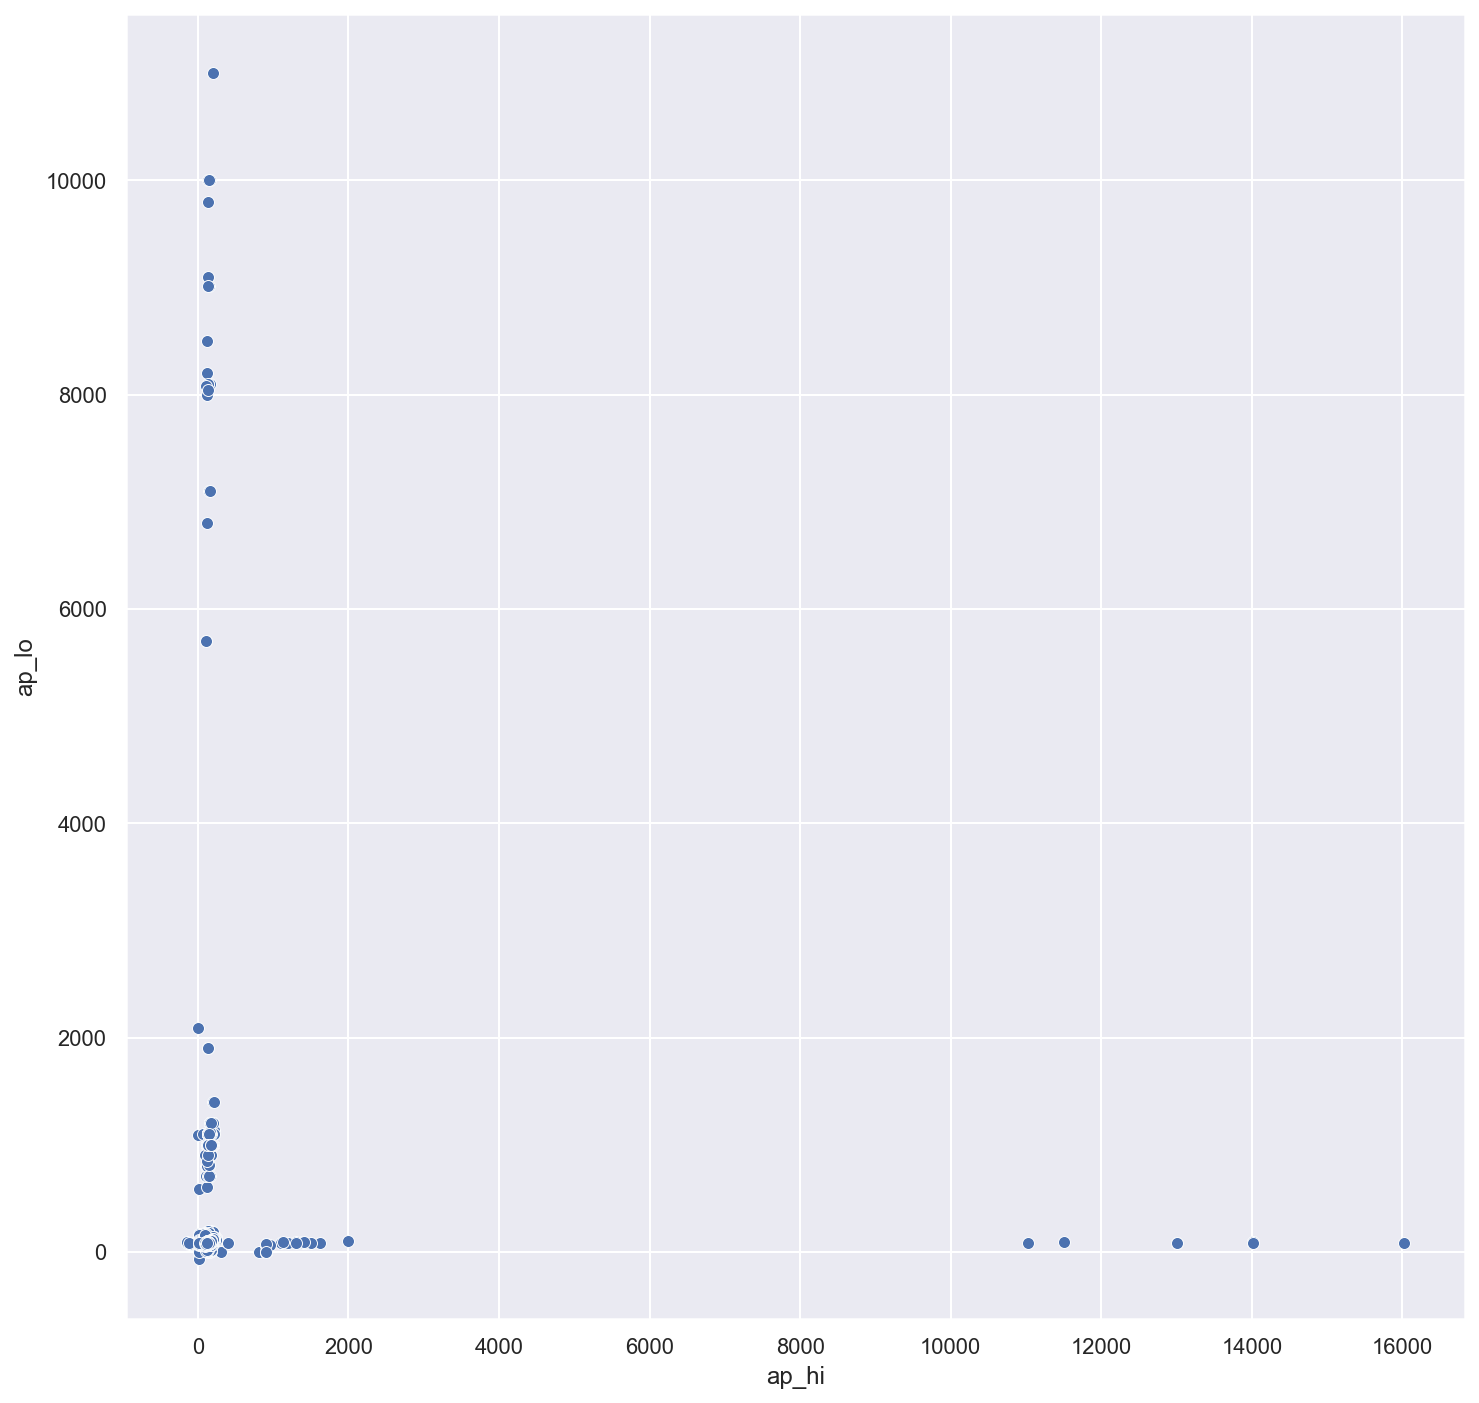

In [36]:
# Scatterplot de ap_li e ap_lo 
plt.figure(figsize = (12,12))
sns.scatterplot(data = df, x = 'ap_hi', y = 'ap_lo');

In [37]:
aux = df.sort_values(by=['ap_lo'], ascending=False).head(15)
aux

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active  cardio  age_years
43326  61901  23221       1     160     105    200  11000            1     1      0     0       1       1         63
68538  97907  19062       1     166      70    160  10000            2     1      0     0       1       1         52
23849  34098  18102       2     169      86    150  10000            2     2      0     1       1       1         49
2381    3352  20994       2     186     105    140  10000            1     1      0     0       1       1         57
43434  62058  21906       2     179      62    130   9800            1     1      0     0       1       0         60
6653    9482  19528       1     162      69    130   9100            1     1      0     0       1       1         53
12086  17260  21466       2     169      78    130   9011            1     1      1     1       1       1         58
32920  47030  18335       1     156      65    150   9011            2     2      0     0       1       1         50
15990  22832  14508       2     179      70    120   8500            1     1      0     0       1       0         39
44042  62921  21220       1     165      74    120   8200            2     3      0     0       1       0         58
20882  29821  19121       1     155      81    160   8100            1     1      0     0       1       1         52
37156  53083  20626       2     176      80    140   8099            1     1      0     0       1       0         56
38024  54286  15999       2     174      70    130   8099            1     1      0     0       0       0         43
23502  33580  19746       2     169      64    120   8079            1     1      0     0       0       0         54
63121  90139  19473       1     159      61    110   8077            1     1      0     0       1       0         53

Como pode ser visto muitos pacientes têm número impossível para pressão arterial.

In [38]:
aux = df.sort_values(by=['ap_lo'], ascending=True).head(15)
aux

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active  cardio  age_years
60106  85816  22571       1     167      74     15    -70            1     1      0     0       1       1         61
56950  81298  15268       1     164      70    120      0            1     1      0     0       1       0         41
45835  65470  19597       2     165      70    140      0            3     1      1     0       1       0         53
41505  59301  20970       1     154      41    806      0            1     1      0     0       1       0         57
13489  19258  14965       2     150      60    130      0            1     1      0     0       0       0         41
16459  23512  20457       1     156      50    138      0            3     1      0     0       1       1         56
63787  91073  14722       2     161      61    117      0            1     1      0     0       1       0         40
38370  54780  23208       2     170      81    148      0            1     1      0     0       1       0         63
2014    2845  22712       2     167      59    906      0            1     1      0     0       1       0         62
65303  93224  23612       2     176      99    120      0            1     3      0     0       1       1         64
17381  24837  18226       1     164      78    138      0            1     1      0     0       1       0         49
52580  75007  21919       1     155      66     13      0            1     1      0     0       1       0         60
27686  39577  23396       2     180      73    140      0            1     1      1     1       1       1         64
40330  57646  20322       1     162      50    309      0            1     1      0     0       1       0         55
25454  36325  17952       2     176      73     12      0            1     1      0     0       1       0         49

O mesmo caso que o anterior.

In [39]:
# Calculo da média de ap_lo
ap_lo_median = df['ap_lo'].median()
ap_lo_median

80.0

In [40]:
# Apply a média para ap_lo Outliers
df['ap_lo'] = df['ap_lo'].apply(lambda x: 80 if x > 120 or x < 40 else x)

<ipython-input-40-62ebe8098771>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ap_lo'] = df['ap_lo'].apply(lambda x: 80 if x > 120 or x < 40 else x)


#### 1.7.3.4 ap_hi (Pressão sanguínea sistólica)

In [41]:
aux = df.sort_values(by=['ap_hi'], ascending=False).head(15)
aux

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active  cardio  age_years
40852  58374  17438       1     169      70  16020     80            1     1      0     0       0       1         47
25464  36339  15835       2     169      75  14020     80            2     1      0     0       1       1         43
25519  36414  21361       1     169      71  14020     80            3     3      0     0       1       1         58
46912  66998  16910       2     180      78  14020     90            1     1      0     0       1       1         46
47253  67502  19731       1     160      65  14020     90            1     1      0     0       1       0         54
55459  79116  18307       1     152      76  13010     80            2     2      0     0       1       1         50
55847  79679  23182       1     161     105  13010     80            1     1      0     0       0       0         63
7763   11089  21032       1     175      80  11500     90            1     1      0     0       1       1         57
51438  73356  18784       2     168      65  11020     80            1     1      0     0       1       1         51
69370  99089  14696       1     170      74   2000    100            2     1      0     0       1       1         40
28147  40239  19700       2     175      87   1620     80            2     1      0     0       1       1         53
13895  19827  15996       1     168      72   1500     80            1     1      0     0       1       1         43
8915   12710  18870       1     164      75   1420     80            2     1      0     0       1       1         51
43208  61725  23418       1     165      67   1420     80            2     1      0     0       1       1         64
50836  72539  16918       2     164      66   1409     90            1     1      0     0       1       1         46

Os valores mais altos são números impossíveis

In [42]:
aux = df.sort_values(by=['ap_hi'], ascending=True).head(15)
aux

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active  cardio  age_years
35040  50055  23325       2     168      59   -150     80            1     1      0     0       1       1         63
23988  34295  18301       1     162      74   -140     90            1     1      0     0       1       1         50
25240  36025  14711       2     168      50   -120     80            2     1      0     0       0       1         40
46627  66571  23646       2     160      59   -120     80            1     1      0     0       0       0         64
16021  22881  22108       2     161      90   -115     70            1     1      0     0       1       0         60
20536  29313  15581       1     153      54   -100     70            1     1      0     0       1       0         42
4607    6525  15281       1     165      78   -100     80            2     1      0     0       1       0         41
8757   12494  16905       2     163      63      1     80            1     1      1     0       1       0         46
42334  60477  18716       1     171      80      1     80            1     1      0     0       1       1         51
5382    7657  21240       1     162      69      7     80            1     1      0     0       1       0         58
56777  81051  18341       1     160      80     10     80            1     1      0     0       1       1         50
62817  89703  18354       1     155      79     10     70            1     1      0     0       1       0         50
57909  82646  16154       1     165      56     10     60            1     1      0     0       1       0         44
20886  29827  19523       1     155      55     10     60            1     1      0     0       0       0         53
66315  94673  22551       1     169      88     10     80            3     3      0     0       0       1         61

Os valores mais baixos são números impossíveis também.

Com base na literatura, optou-se por substituir os valores acima de 200 e inferiores a 40 pela mediana (a mediana foi escolhida porque a quantidade de outliers é grande)

In [43]:
# Calculo da mediana ap_lo
ap_hi_median = df['ap_hi'].median()
ap_hi_median

120.0

In [44]:
# Apply Mean to ap_lo Outliers
df['ap_hi'] = df['ap_hi'].apply(lambda x: 120 if x > 200 or x < 40 else x)

<ipython-input-44-e59ea7f75899>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ap_hi'] = df['ap_hi'].apply(lambda x: 120 if x > 200 or x < 40 else x)


**Scatter plot depois da substituição dos outliers**

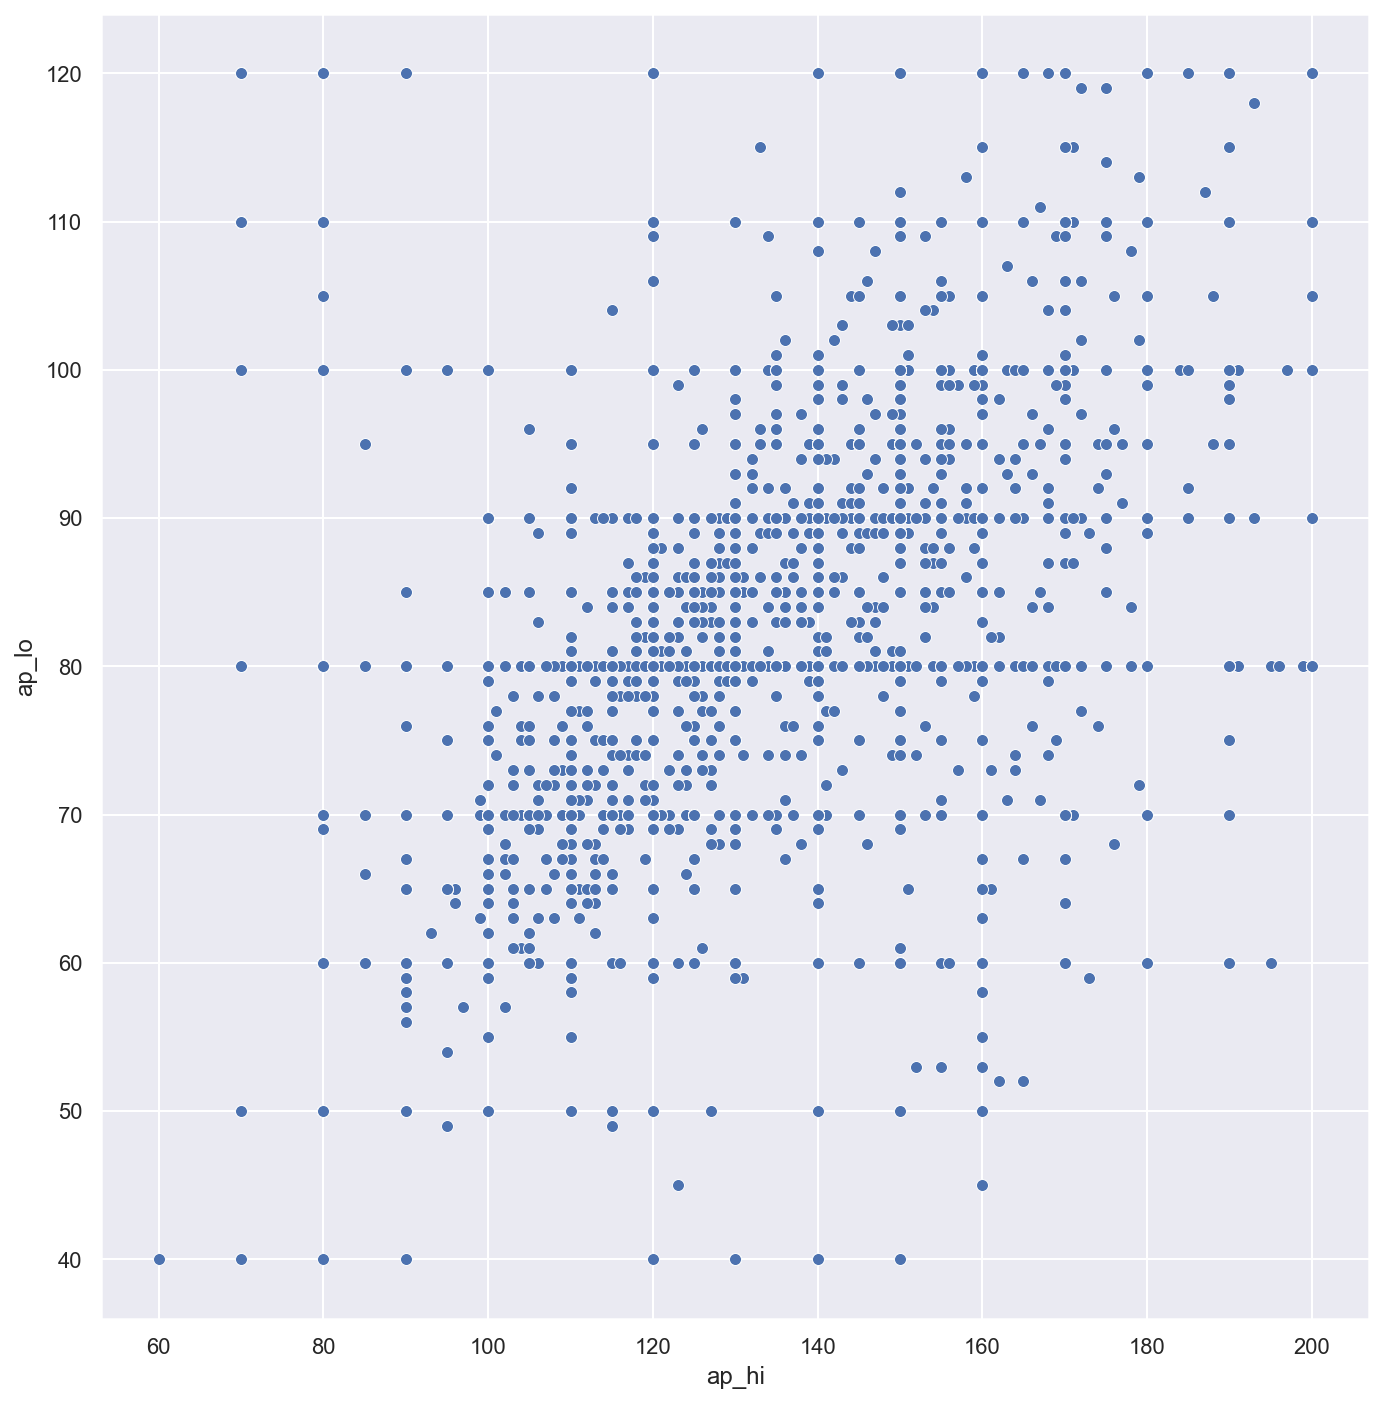

In [45]:
# Scatterplot of ap_li and ap_lo 
plt.subplot(121)
sns.scatterplot(data = df, x = 'ap_hi', y = 'ap_lo');

 O gráfico agora é muito mais razoável

# 2 Feature Engineering

## 2.1 Mapa mental de hipoteses

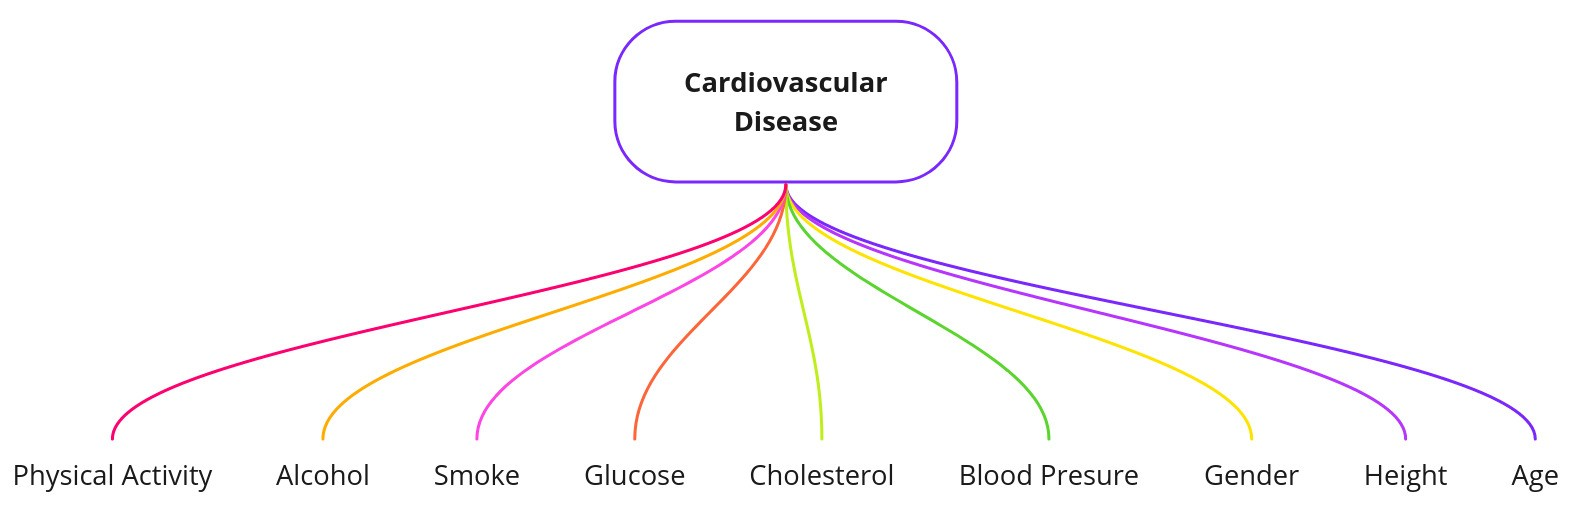

In [46]:
Image('img/mindmap.jpg')

## 2.2 Lista de hipoteses

**Com base na literatura podemos fazer a seguinte hipótese:**

**H1** - Idosos têm mais doenças cardiovasculares                                                                   
**H2** - Pessoas menores têm mais doenças cardiovasculares                                                          
**H3** - Homens têm mais doenças cardiovasculares                                                                   
**H4** - Pessoas com maior pressão arterial têm mais doenças cardiovasculares                                                       
**H5** - Pessoas com maior colesterol têm mais doenças cardiovasculares                                                          
**H6** - Pessoas com maior glicose têm mais doenças cardiovasculares                                                               
**H7** - Pessoas que fumam têm mais doenças cardiovasculares                                                                   
**H8** - Pessoas que bebem álcool têm mais doenças cardiovasculares                                                                 
**H9** - Pessoas sedentárias têm mais doenças cardiovasculares                                  

Com base na lista de hipóteses, algumas características podem ser criadas, como índice de IMC, a pressão arterial agregando ap_hi e ap_lo e uma escala de risco. Agora podemos adicionar mais duas hipóteses.                                                                   

**H10** - Pessoas com IMC mais elevado têm mais doenças cardiovasculares                                                                 
**H11** - Pessoas com maior escala de risco de doenças cardiovasculares têm mais doenças cardiovasculares

 ## 2.3 BMI ( Body Mass Index-Index de massa corporal )

O índice de massa corporal (IMC) é o peso de uma pessoa em quilogramas dividido pelo quadrado de altura em metros.

O IMC é um método de triagem fácil para categoria de peso — baixo peso, peso saudável, sobrepeso e obesidade.

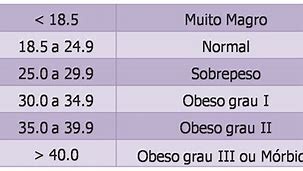

In [47]:
Image('img/IMC.jpg')

In [48]:
df1 = df.copy()

In [49]:
# Criação da variável IMC
df1['imc'] = (df1['weight'] / ((df1['height']/100)**2)).round(1)

In [50]:
# Criação do status da variável IMCCreate a BMI Status Variable
df1['imc_status'] = df1['imc'].apply(lambda x: 'muito magro' if x < 18.5 else 'normal' if (x >= 18.5) & (x <= 24.9)
                                             else 'sobrepeso' if (x >= 25) & (x <= 29.9) 
                                             else 'obeso g-1' if (x >= 30.0) & (x <= 34.9)
                                             else 'obeso g-2' if (x >= 35.0) & (x <= 39.9)
                                             else 'obeso g-3')

# Setar um imc normal 
normal_imc = 21.7

# Calculo da diferença do imc com o imc normal
df1['imc_diff'] = df1['imc'] - normal_imc

## 2.4 Pressão arterial

In [51]:
# Criação da variável pressão arterial 
df1['pressão_arterial'] = ['0' if (ap_hi <= 105) & (ap_lo <= 60)
                               else '1' if ((ap_hi > 105) & (ap_hi < 130)) & ((ap_lo > 60) & (ap_lo < 85))
                               else '2' if ((ap_hi >= 130) & (ap_hi < 140)) & ((ap_lo >= 85) & (ap_lo < 90))
                               else '3' if ((ap_hi >= 140) & (ap_hi < 160)) | ((ap_lo >= 90) & (ap_lo < 100))
                               else '4' if ((ap_hi >= 160) & (ap_hi < 180)) | ((ap_lo >= 100) & (ap_lo < 110))
                               else '5' 
                               for ap_hi, ap_lo in zip(df1['ap_hi'], df1['ap_lo'])]

In [52]:
# Criação do status da variável pressão arterial
df1['pressão_arterial_status'] = ['baixo' if (ap_hi <= 105) & (ap_lo <= 60)
                               else 'normal' if ((ap_hi > 105) & (ap_hi < 130)) & ((ap_lo > 60) & (ap_lo < 85))
                               else 'acima_normal' if ((ap_hi >= 130) & (ap_hi < 140)) & ((ap_lo >= 85) & (ap_lo < 90))
                               else 'hipertenção_1' if ((ap_hi >= 140) & (ap_hi < 160)) | ((ap_lo >= 90) & (ap_lo < 100))
                               else 'hipertenção_2' if ((ap_hi >= 160) & (ap_hi < 180)) | ((ap_lo >= 100) & (ap_lo < 110))
                               else 'hipertenção_3' 
                               for ap_hi, ap_lo in zip(df1['ap_hi'], df1['ap_lo'])]

In [53]:
df1.head(10).T

33147   1100           51088      16518      68922          47440          62818          6609       1184           24779
id                               47366    1531          72870      23602      98467          67749          89704           9420       1653          35384
age                              16908   20374          19916      22447      22696          14313          16054          20263      21087          20463
gender                               1       2              1          1          2              1              2              1          1              2
height                             159     175            162        153        155            165            171            153        160            158
weight                              75      69             89         62         68            110             98             64         80             56
ap_hi                              130     120            140        110        120            170            160            100        120            140
ap_lo                               80      80             80         70         80            106            100             80         80             90
cholesterol                          1       1              1          3          1              2              3              1          2              1
gluc                                 1       2              3          1          1              1              1              1          1              1
smoke                                0       0              0          0          0              0              0              0          0              0
alco                                 0       0              0          0          0              0              0              0          0              0
active                               1       1              1          1          1              1              1              1          0              1
cardio                               1       0              1          1          0              1              1              0          1              1
age_years                           46      55             54         61         62             39             43             55         57             56
imc                            29.7000 22.5000        33.9000    26.5000    28.3000        40.4000        33.5000        27.3000    31.2000        22.4000
imc_status                   sobrepeso  normal      obeso g-1  sobrepeso  sobrepeso      obeso g-3      obeso g-1      sobrepeso  obeso g-1         normal
imc_diff                        8.0000  0.8000        12.2000     4.8000     6.6000        18.7000        11.8000         5.6000     9.5000         0.7000
pressão_arterial                     5       1              3          1          1              4              4              5          1              3
pressão_arterial_status  hipertenção_3  normal  hipertenção_1     normal     normal  hipertenção_2  hipertenção_2  hipertenção_3     normal  hipertenção_1

## 2.5 Escala de Risco

A Escala de Risco dá um resumo de importantes varibales que podem prever o acidente cardiovascular com base na literatura. São elas: glucucose, colesterol, iMC, fumante, consumo de álcool e atividade física.

In [54]:
# Criando variável de escala de risco variando de 0 a 1
df1['escala_risco'] = df1['gluc'] + df1['cholesterol'] + df1['imc'] + df1['smoke'] + df1['alco'] + df1['active']

In [55]:
df1.describe().T 

count        mean         std         min         25%         50%         75%         max
id           63,000.0000 49,914.9148 28,852.0836      0.0000 24,928.7500 49,900.0000 74,823.2500 99,999.0000
age          63,000.0000 19,465.8017  2,471.2437 10,798.0000 17,663.0000 19,700.0000 21,328.0000 23,713.0000
gender       63,000.0000      1.3488      0.4766      1.0000      1.0000      1.0000      2.0000      2.0000
height       63,000.0000    164.4193      7.9389    120.0000    159.0000    165.0000    170.0000    200.0000
weight       63,000.0000     74.2239     14.3521     40.0000     65.0000     72.0000     82.0000    200.0000
ap_hi        63,000.0000    126.9079     16.8778     60.0000    120.0000    120.0000    140.0000    200.0000
ap_lo        63,000.0000     81.2862      9.3143     40.0000     80.0000     80.0000     90.0000    120.0000
cholesterol  63,000.0000      1.3671      0.6803      1.0000      1.0000      1.0000      2.0000      3.0000
gluc         63,000.0000      1.2257      0.5711      1.0000      1.0000      1.0000      1.0000      3.0000
smoke        63,000.0000      0.0877      0.2829      0.0000      0.0000      0.0000      0.0000      1.0000
alco         63,000.0000      0.0539      0.2258      0.0000      0.0000      0.0000      0.0000      1.0000
active       63,000.0000      0.8037      0.3972      0.0000      1.0000      1.0000      1.0000      1.0000
cardio       63,000.0000      0.4993      0.5000      0.0000      0.0000      0.0000      1.0000      1.0000
age_years    63,000.0000     52.8321      6.7780     29.0000     48.0000     53.0000     58.0000     64.0000
imc          63,000.0000     27.4979      5.2941     13.5000     23.9000     26.4000     30.2000    108.2000
imc_diff     63,000.0000      5.7979      5.2941     -8.2000      2.2000      4.7000      8.5000     86.5000
escala_risco 63,000.0000     31.0360      5.6006     16.8000     27.0000     29.9000     34.0000    111.2000

In [56]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63000 entries, 33147 to 68550
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       63000 non-null  int64  
 1   age                      63000 non-null  int64  
 2   gender                   63000 non-null  int64  
 3   height                   63000 non-null  int64  
 4   weight                   63000 non-null  int64  
 5   ap_hi                    63000 non-null  int64  
 6   ap_lo                    63000 non-null  int64  
 7   cholesterol              63000 non-null  int64  
 8   gluc                     63000 non-null  int64  
 9   smoke                    63000 non-null  int64  
 10  alco                     63000 non-null  int64  
 11  active                   63000 non-null  int64  
 12  cardio                   63000 non-null  int64  
 13  age_years                63000 non-null  int32  
 14  imc               

In [57]:
# Transformando pressão arterial em int64
df1['pressão_arterial'] = df1['pressão_arterial'].astype(int64)

In [58]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63000 entries, 33147 to 68550
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       63000 non-null  int64  
 1   age                      63000 non-null  int64  
 2   gender                   63000 non-null  int64  
 3   height                   63000 non-null  int64  
 4   weight                   63000 non-null  int64  
 5   ap_hi                    63000 non-null  int64  
 6   ap_lo                    63000 non-null  int64  
 7   cholesterol              63000 non-null  int64  
 8   gluc                     63000 non-null  int64  
 9   smoke                    63000 non-null  int64  
 10  alco                     63000 non-null  int64  
 11  active                   63000 non-null  int64  
 12  cardio                   63000 non-null  int64  
 13  age_years                63000 non-null  int32  
 14  imc               

 # 3.0 Variable Selection

In [59]:
 df2 = df1.copy()

## 3.1 Dividido em variáveis numéricas, categoricas e binárias

In [60]:
# Divide features in numerical, categorical and binary
num_var = df2[['age','age_years', 'height', 'weight', 'ap_hi', 'ap_lo', 'imc', 'escala_risco' ]]
cat_var = df2[['cholesterol', 'gluc', 'pressão_arterial']]
bin_var = df2[['gender', 'smoke', 'alco', 'active']]

# 4.0 Exploratory Data Analysis

In [61]:
df3 = df2.copy()

##  4.1 Estatísticas Descritivas após o processamento de novas variáveis

In [62]:
# Numerical variables statistics
descriptive_stat(num_var)

attributes         min         max       range        mean      median        mode        std    skew  kurtosis
0           age 10,798.0000 23,713.0000 12,915.0000 19,465.8017 19,700.0000 18,236.0000 2,471.2241 -0.3078   -0.8237
1     age_years     29.0000     64.0000     35.0000     52.8321     53.0000     55.0000     6.7780 -0.3064   -0.8195
2        height    120.0000    200.0000     80.0000    164.4193    165.0000    165.0000     7.9388  0.0336    0.6016
3        weight     40.0000    200.0000    160.0000     74.2239     72.0000     65.0000    14.3520  1.0191    2.4872
4         ap_hi     60.0000    200.0000    140.0000    126.9079    120.0000    120.0000    16.8777  0.8312    1.2809
5         ap_lo     40.0000    120.0000     80.0000     81.2862     80.0000     80.0000     9.3142  0.2656    1.2681
6           imc     13.5000    108.2000     94.7000     27.4979     26.4000     23.9000     5.2941  1.3726    4.6509
7  escala_risco     16.8000    111.2000     94.4000     31.0360     29.9000     27.2000     5.6005  1.2757    3.8538

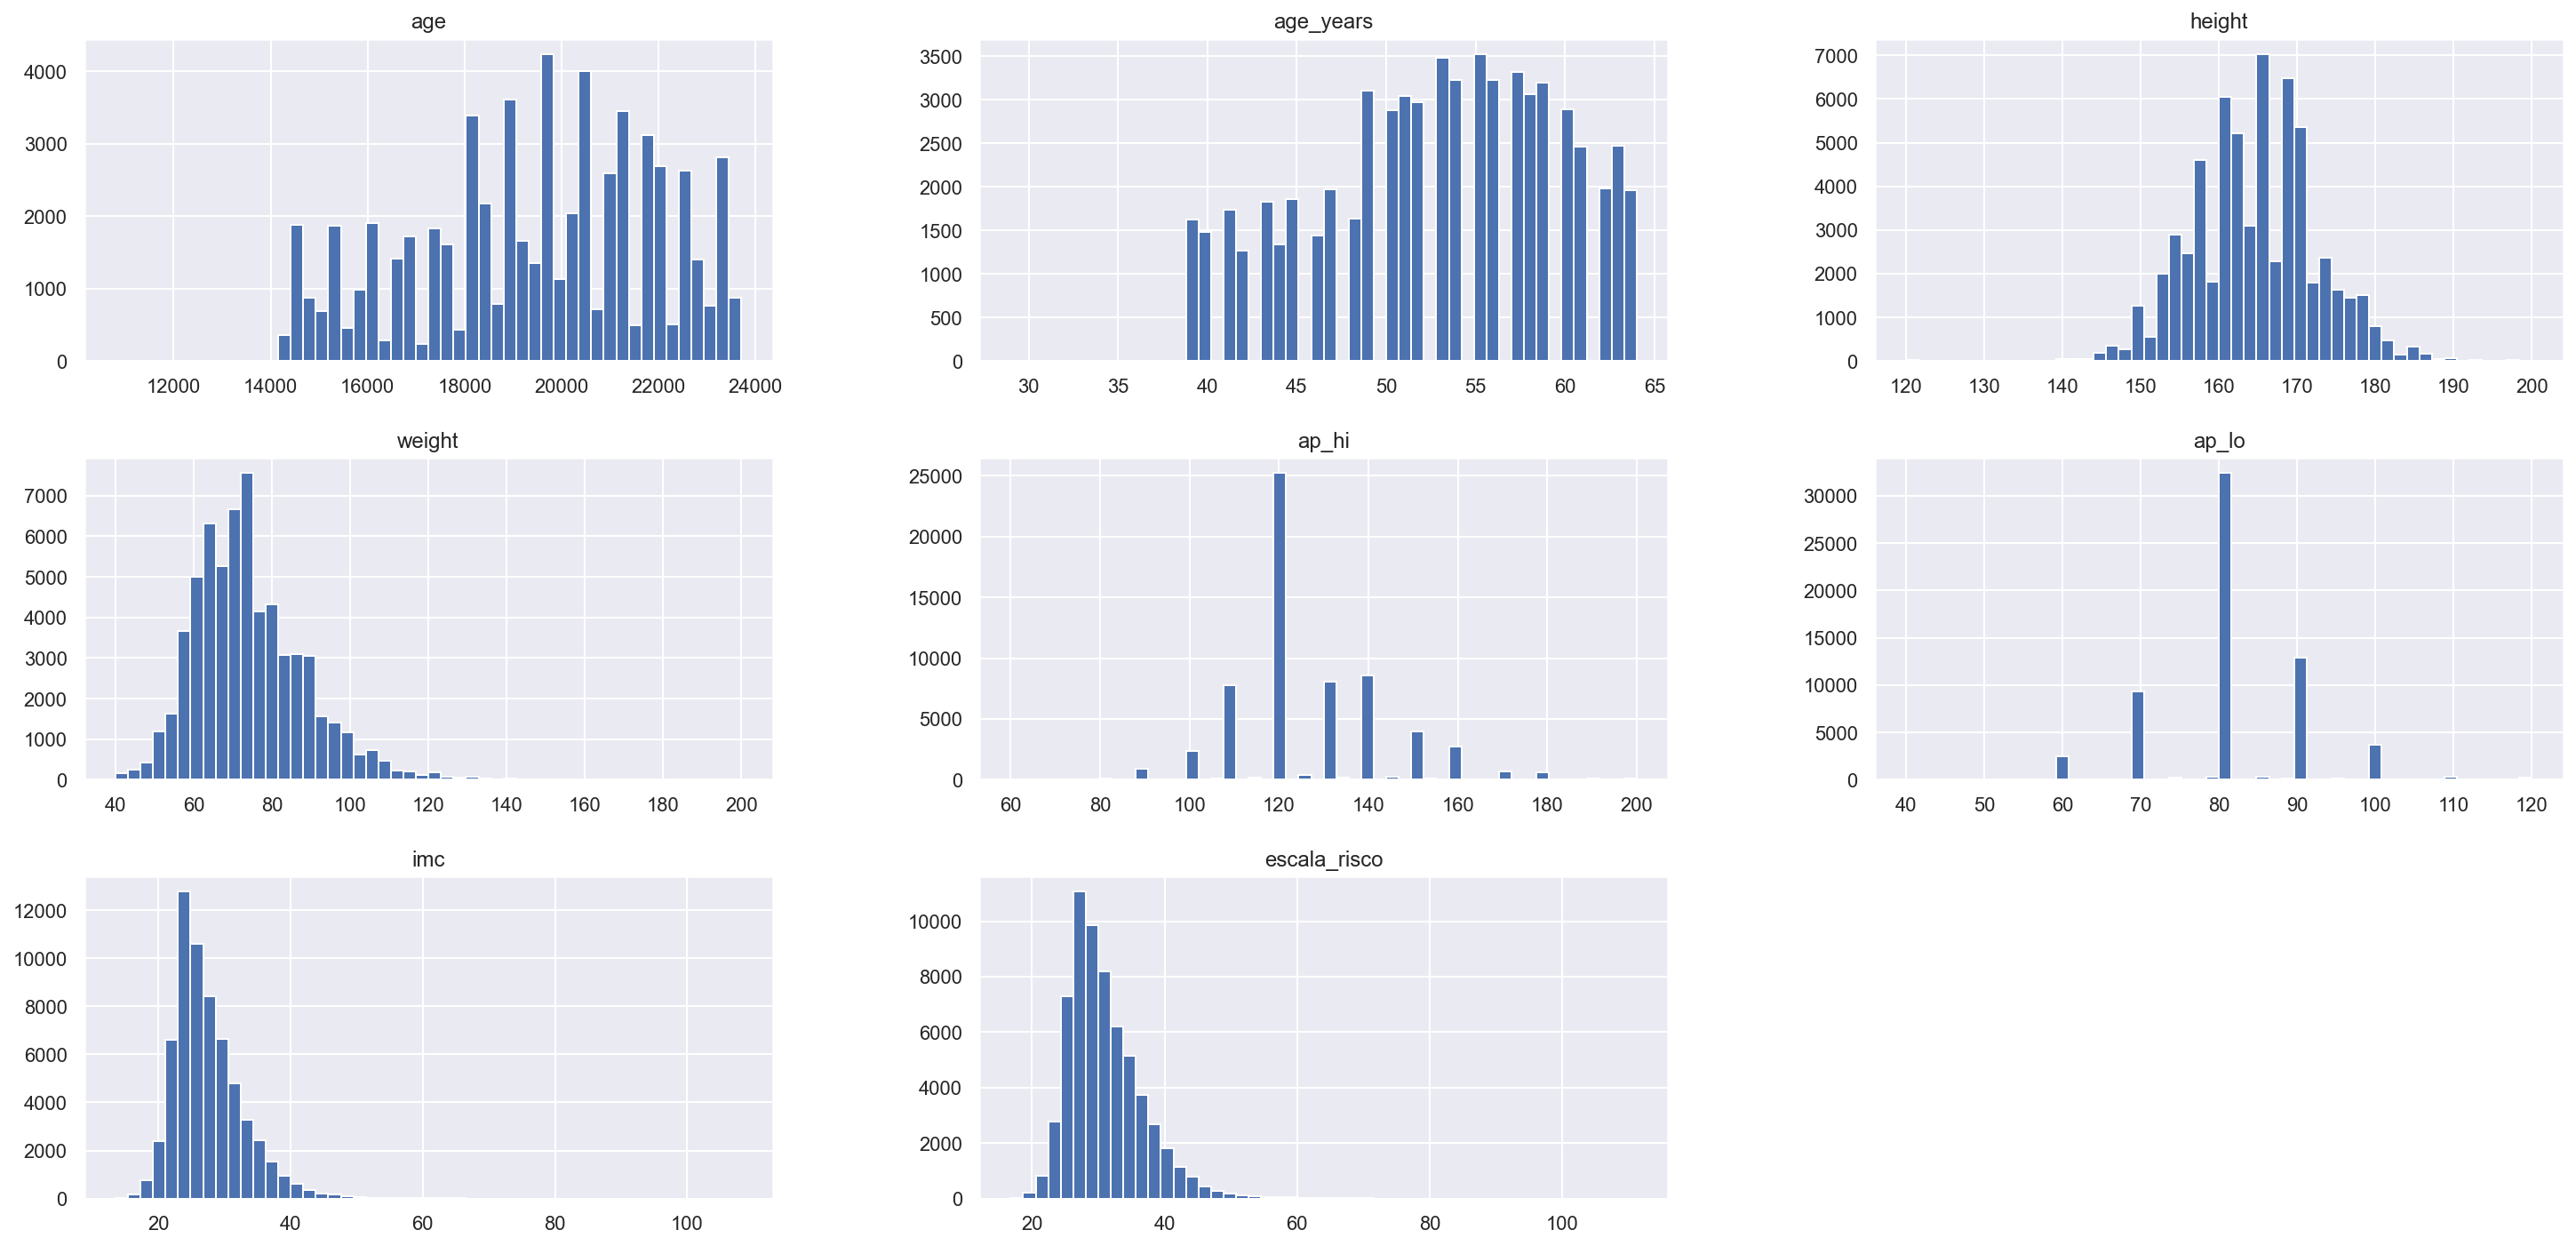

In [63]:
num_var.hist( bins = 50 );

C:\Users\tulio.carvalho\Anaconda3\envs\CardiovascularDisease\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


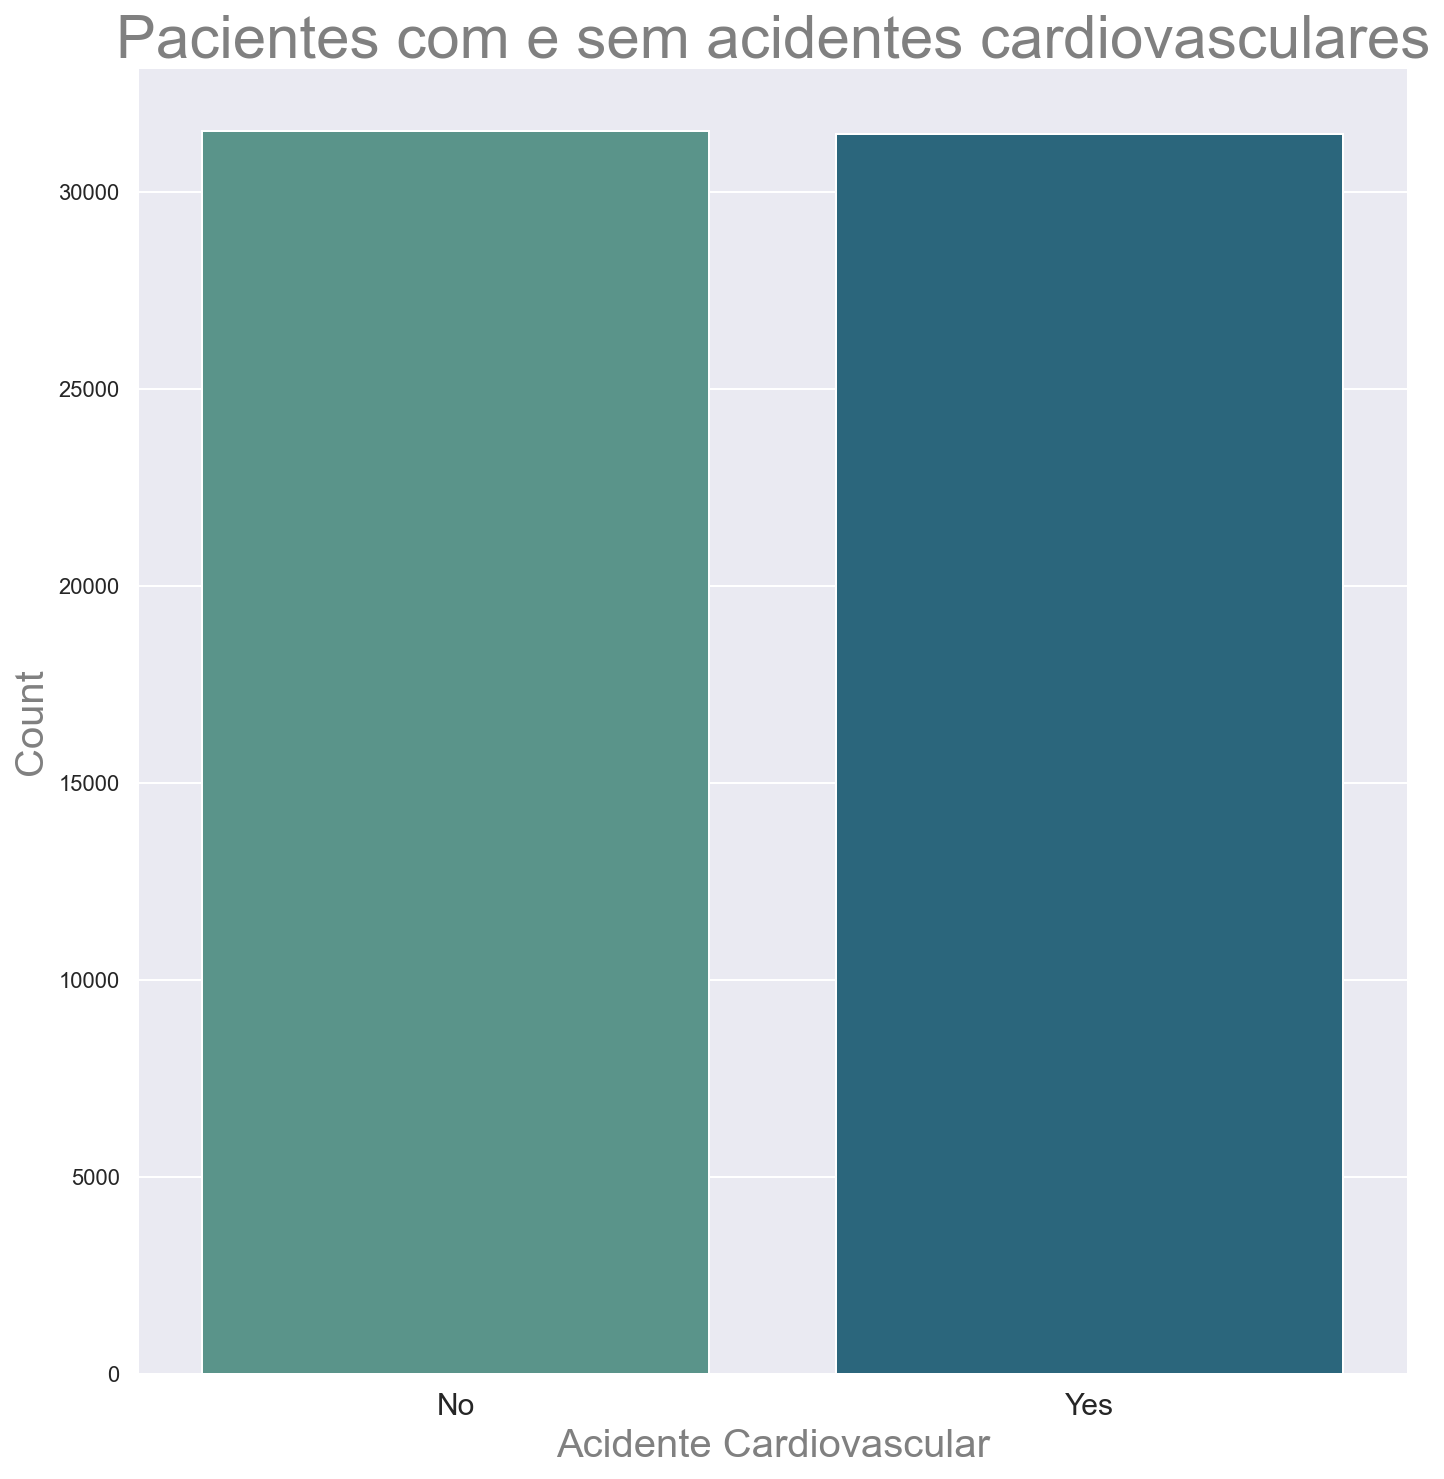

In [64]:
plt.subplot(121)
sns.countplot(df['cardio'], palette='crest')
sns.set_style('whitegrid')
plt.title('Pacientes com e sem acidentes cardiovasculares', size = 30, color = 'grey')
plt.xlabel('Acidente Cardiovascular', size = 20, color = 'grey')
plt.xticks(np.arange(2), labels=['No','Yes'], size = 15)
sns.set_style("whitegrid")
sns.despine( bottom = True, left = True)
plt.ylabel("Count", size = 20, color = 'grey');

**Pessoas com e sem acidente cardiovascular são quase iguais (em torno de 35.000).**

## 4.3 Análise Bivariada - Validação de Hipóteses

### 4.3.1 H1 - Idosos têm mais doenças cardiovasculares

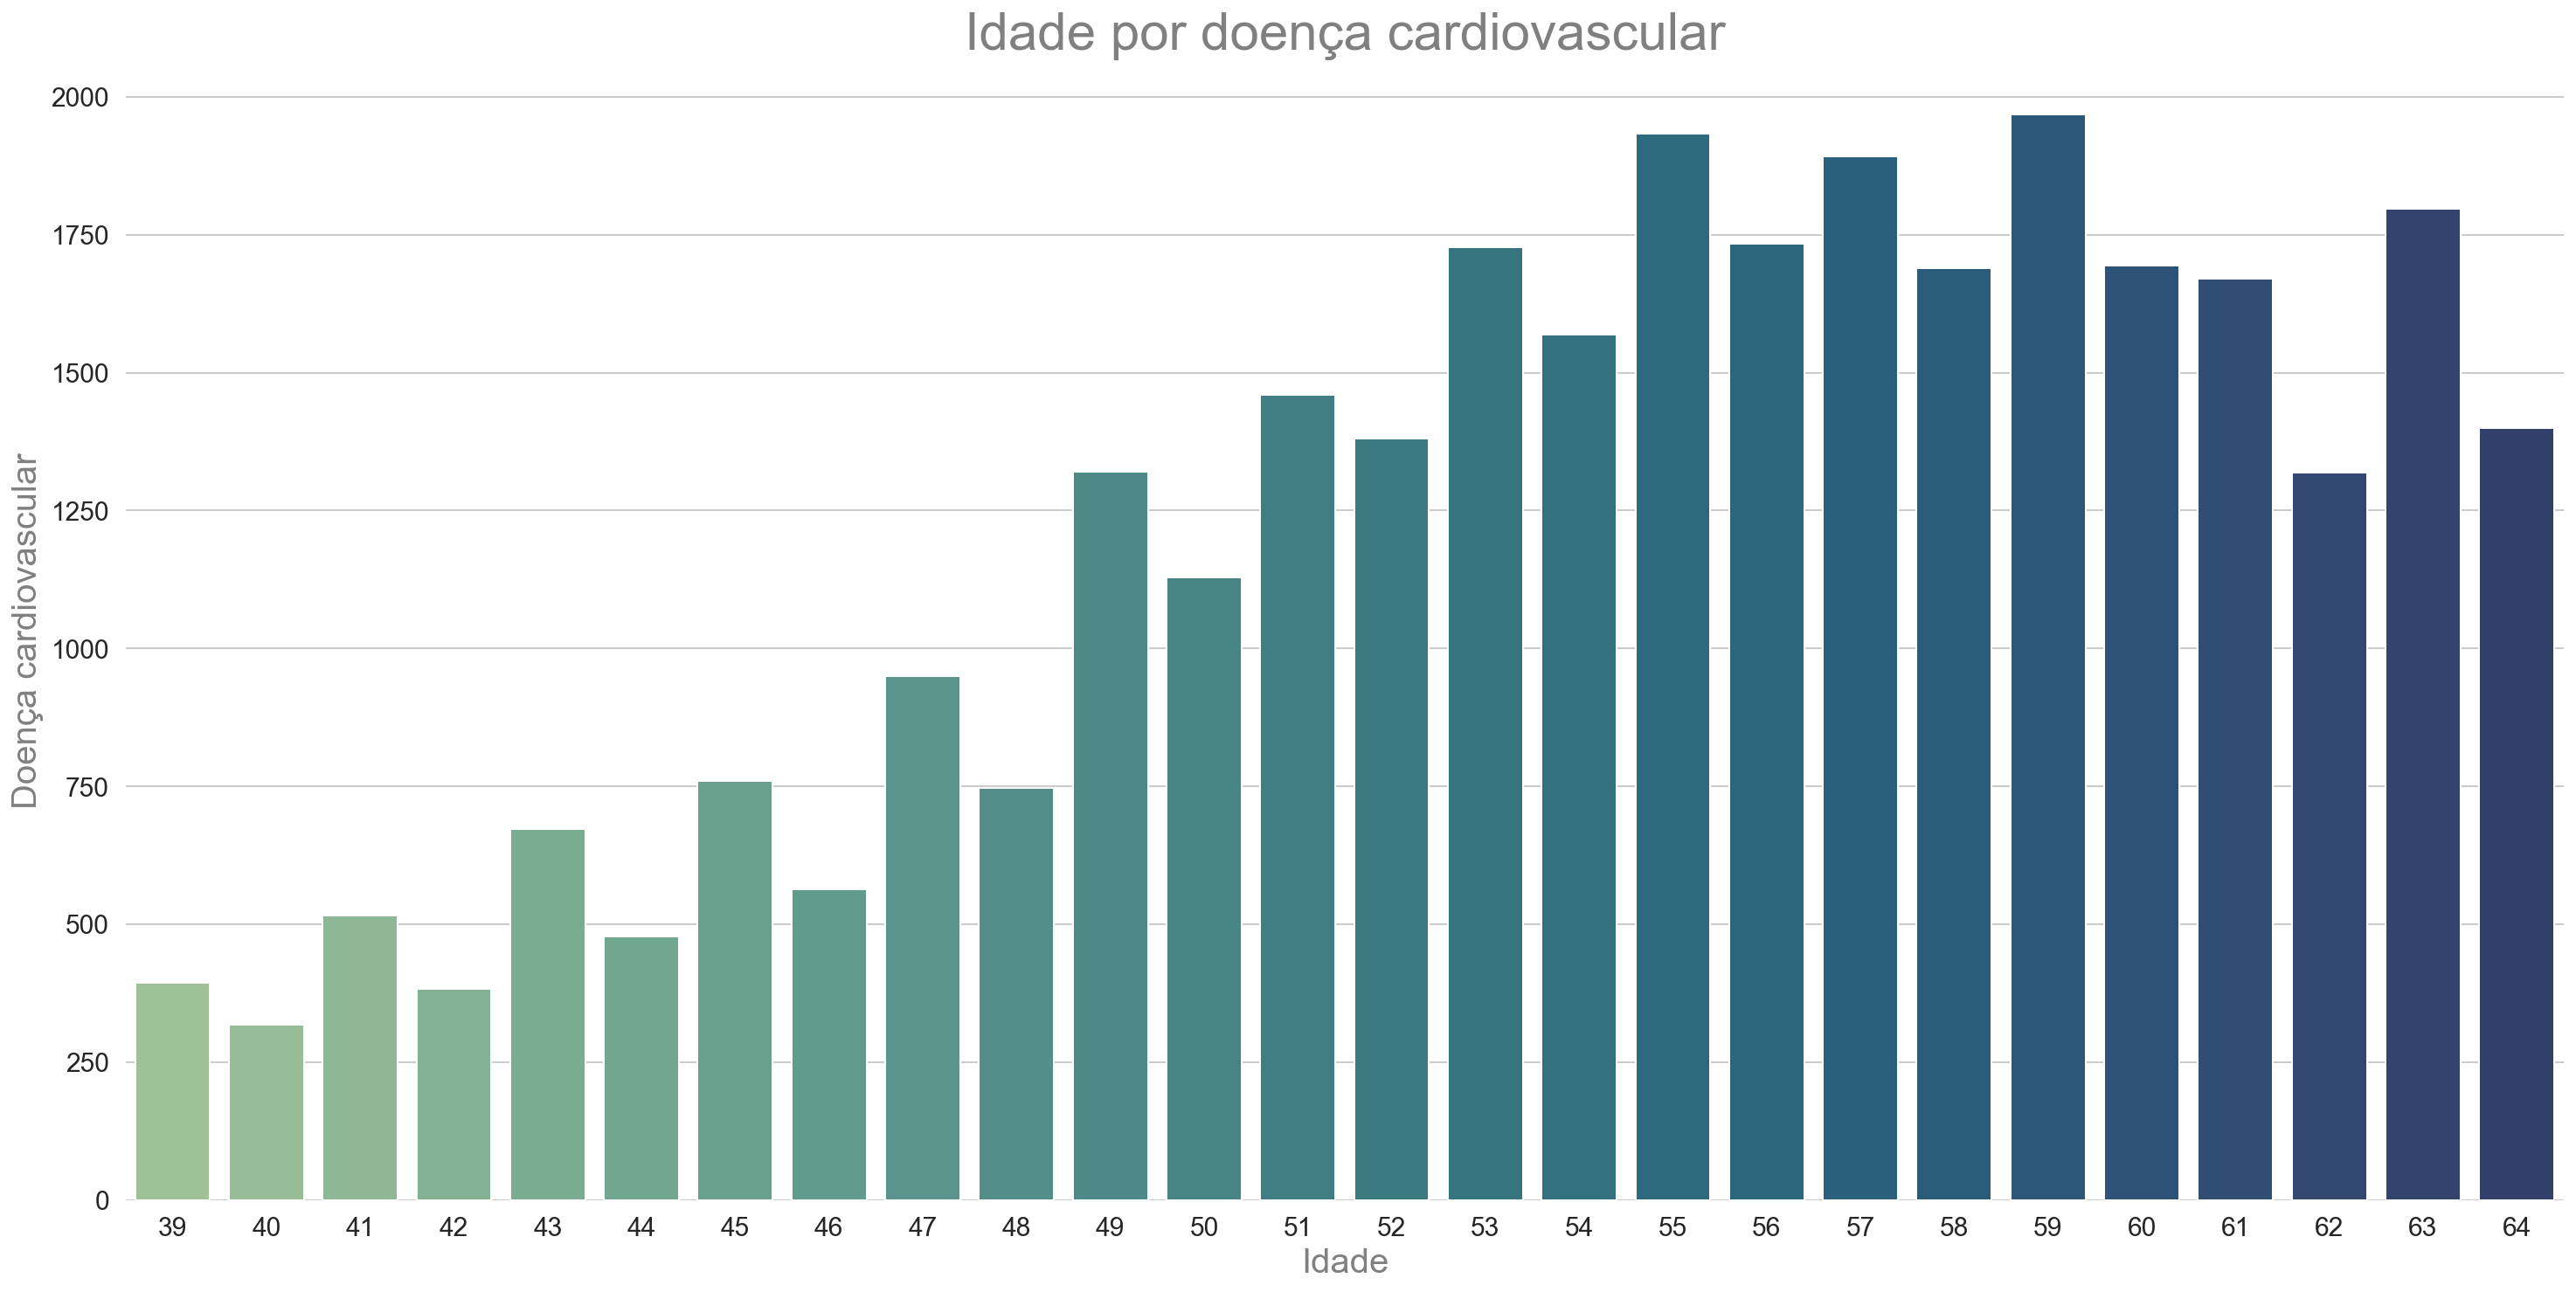

In [65]:
aux = df3[df3['cardio'] == 1 ][['age_years', 'cardio']].groupby('age_years').sum().reset_index()
sns.barplot( x = 'age_years', y = 'cardio', data = aux, palette = 'crest' );
plt.title('Idade por doença cardiovascular', size = 30, color = 'grey')
sns.set_style("whitegrid")
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Idade", size = 20, color = 'grey')
plt.ylabel("Doença cardiovascular", size = 20, color = 'grey');

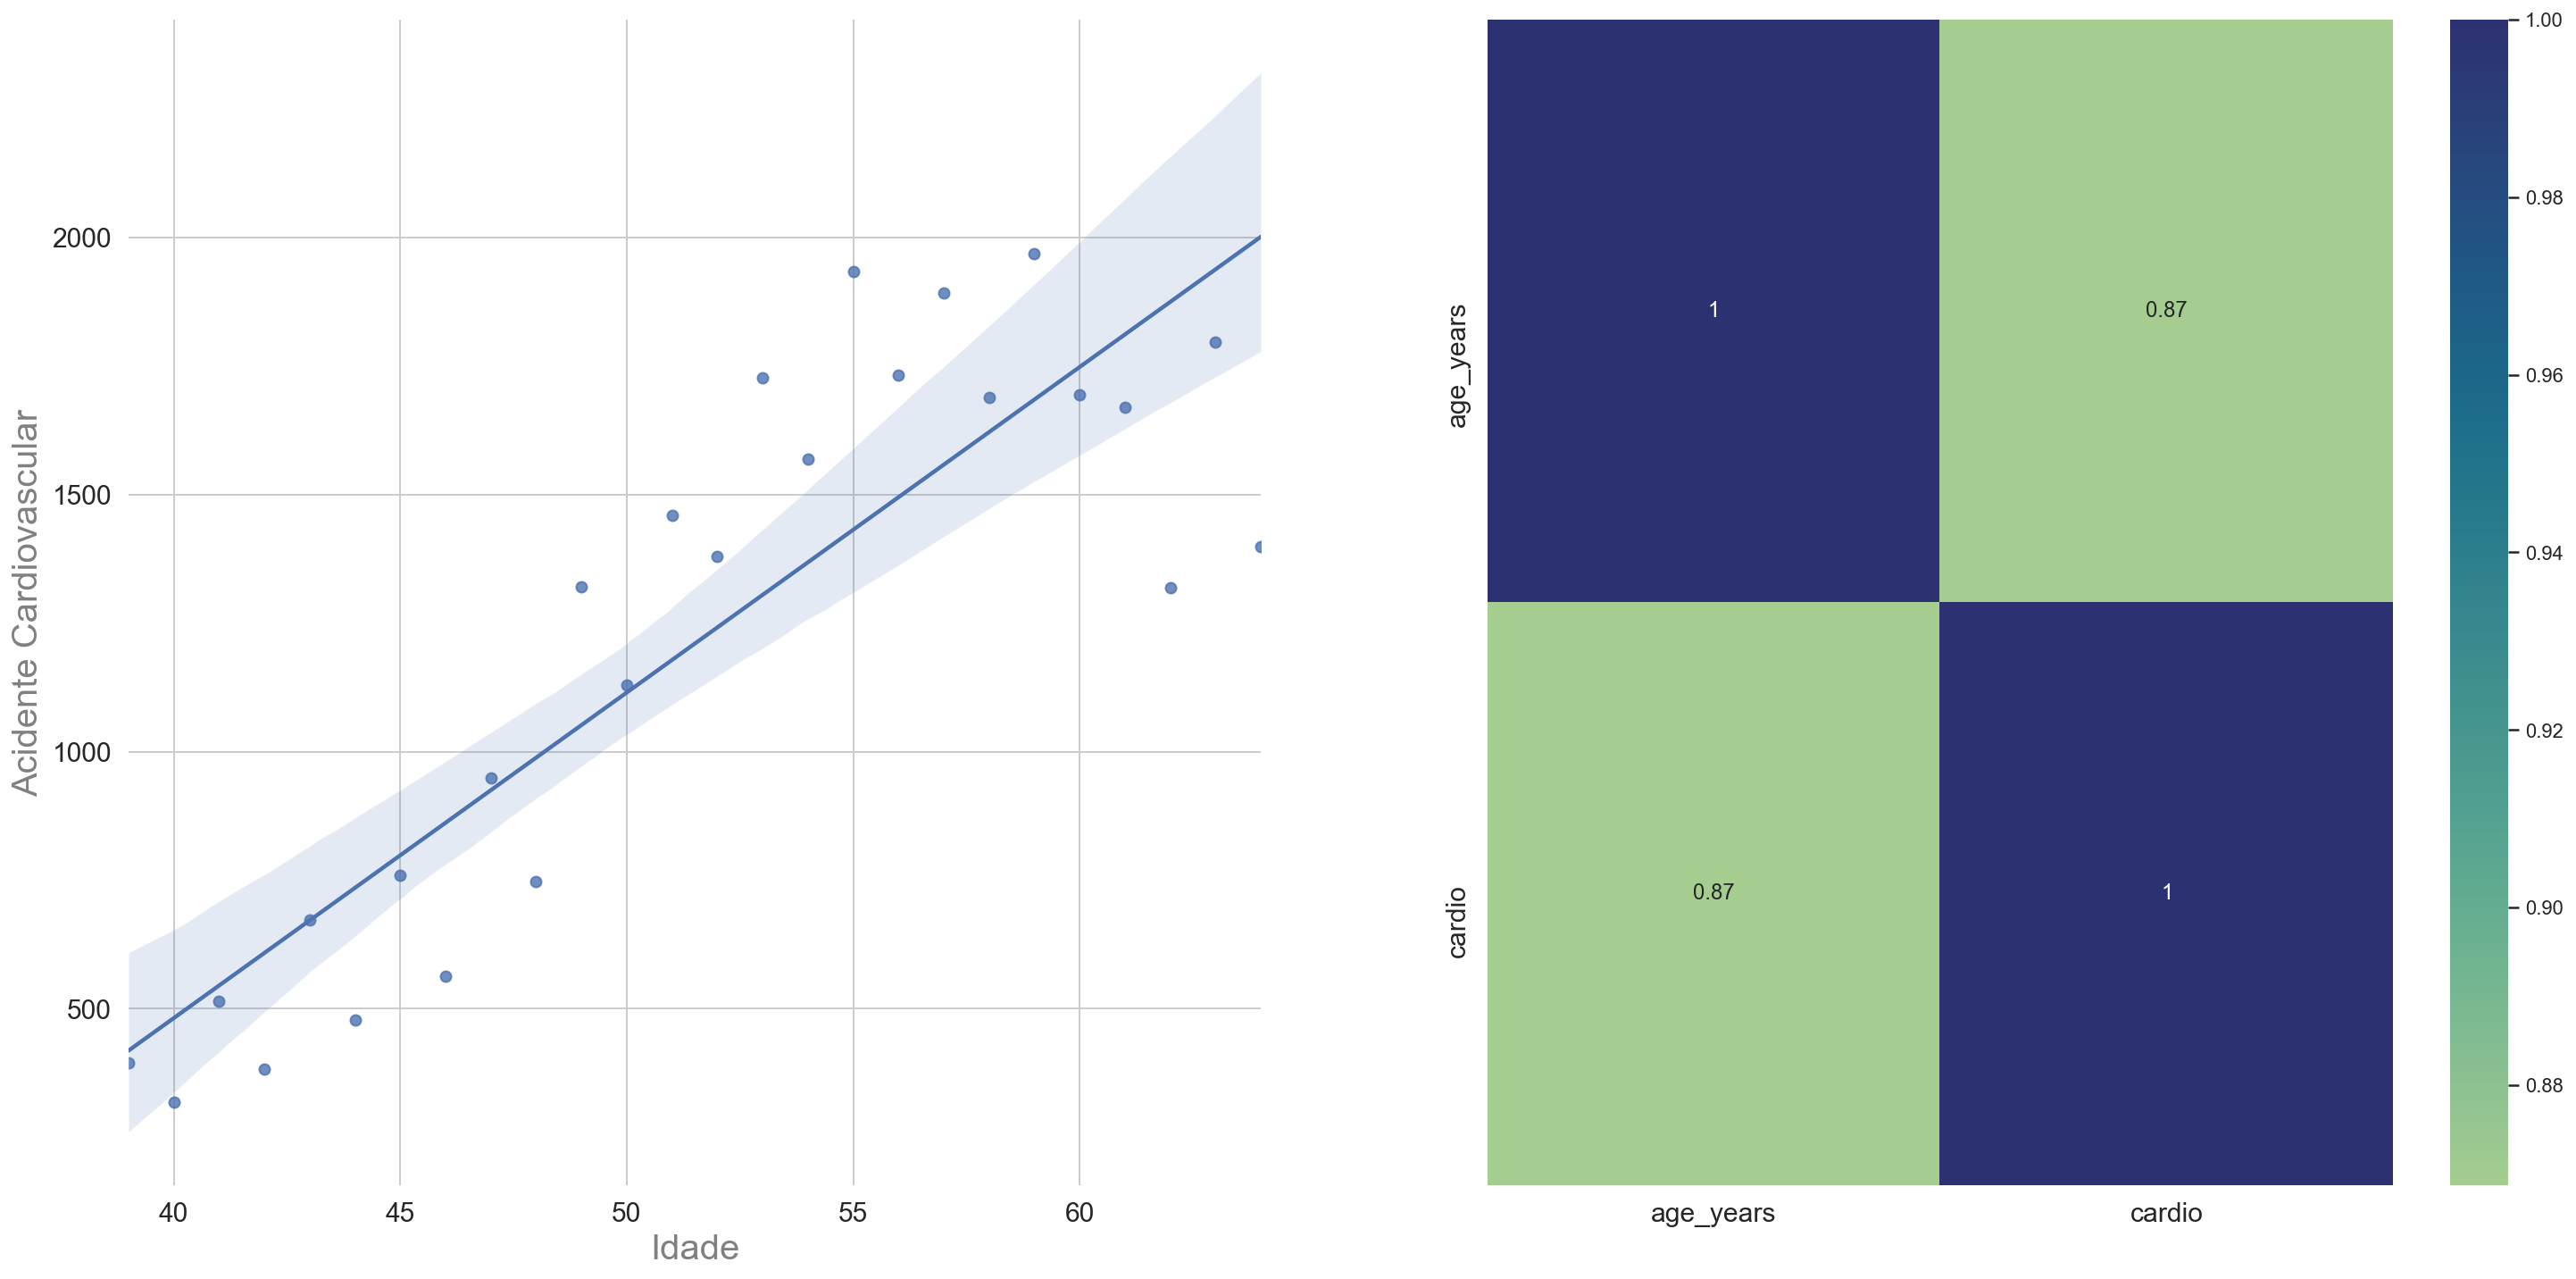

In [66]:
plt.subplot(121)
sns.regplot( x = 'age_years', y = 'cardio', data = aux)
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Idade", size = 20, color = 'grey')
plt.ylabel("Acidente Cardiovascular", size = 20, color = 'grey')

plt.subplot(122)
sns.heatmap( aux.corr( method='pearson' ), annot=True, cmap="crest" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15);

**Hipótese verdadeira e correlação é forte (0,87)**

### 4.3.2 H2 - Pessoas menores têm mais doenças cardiovasculares

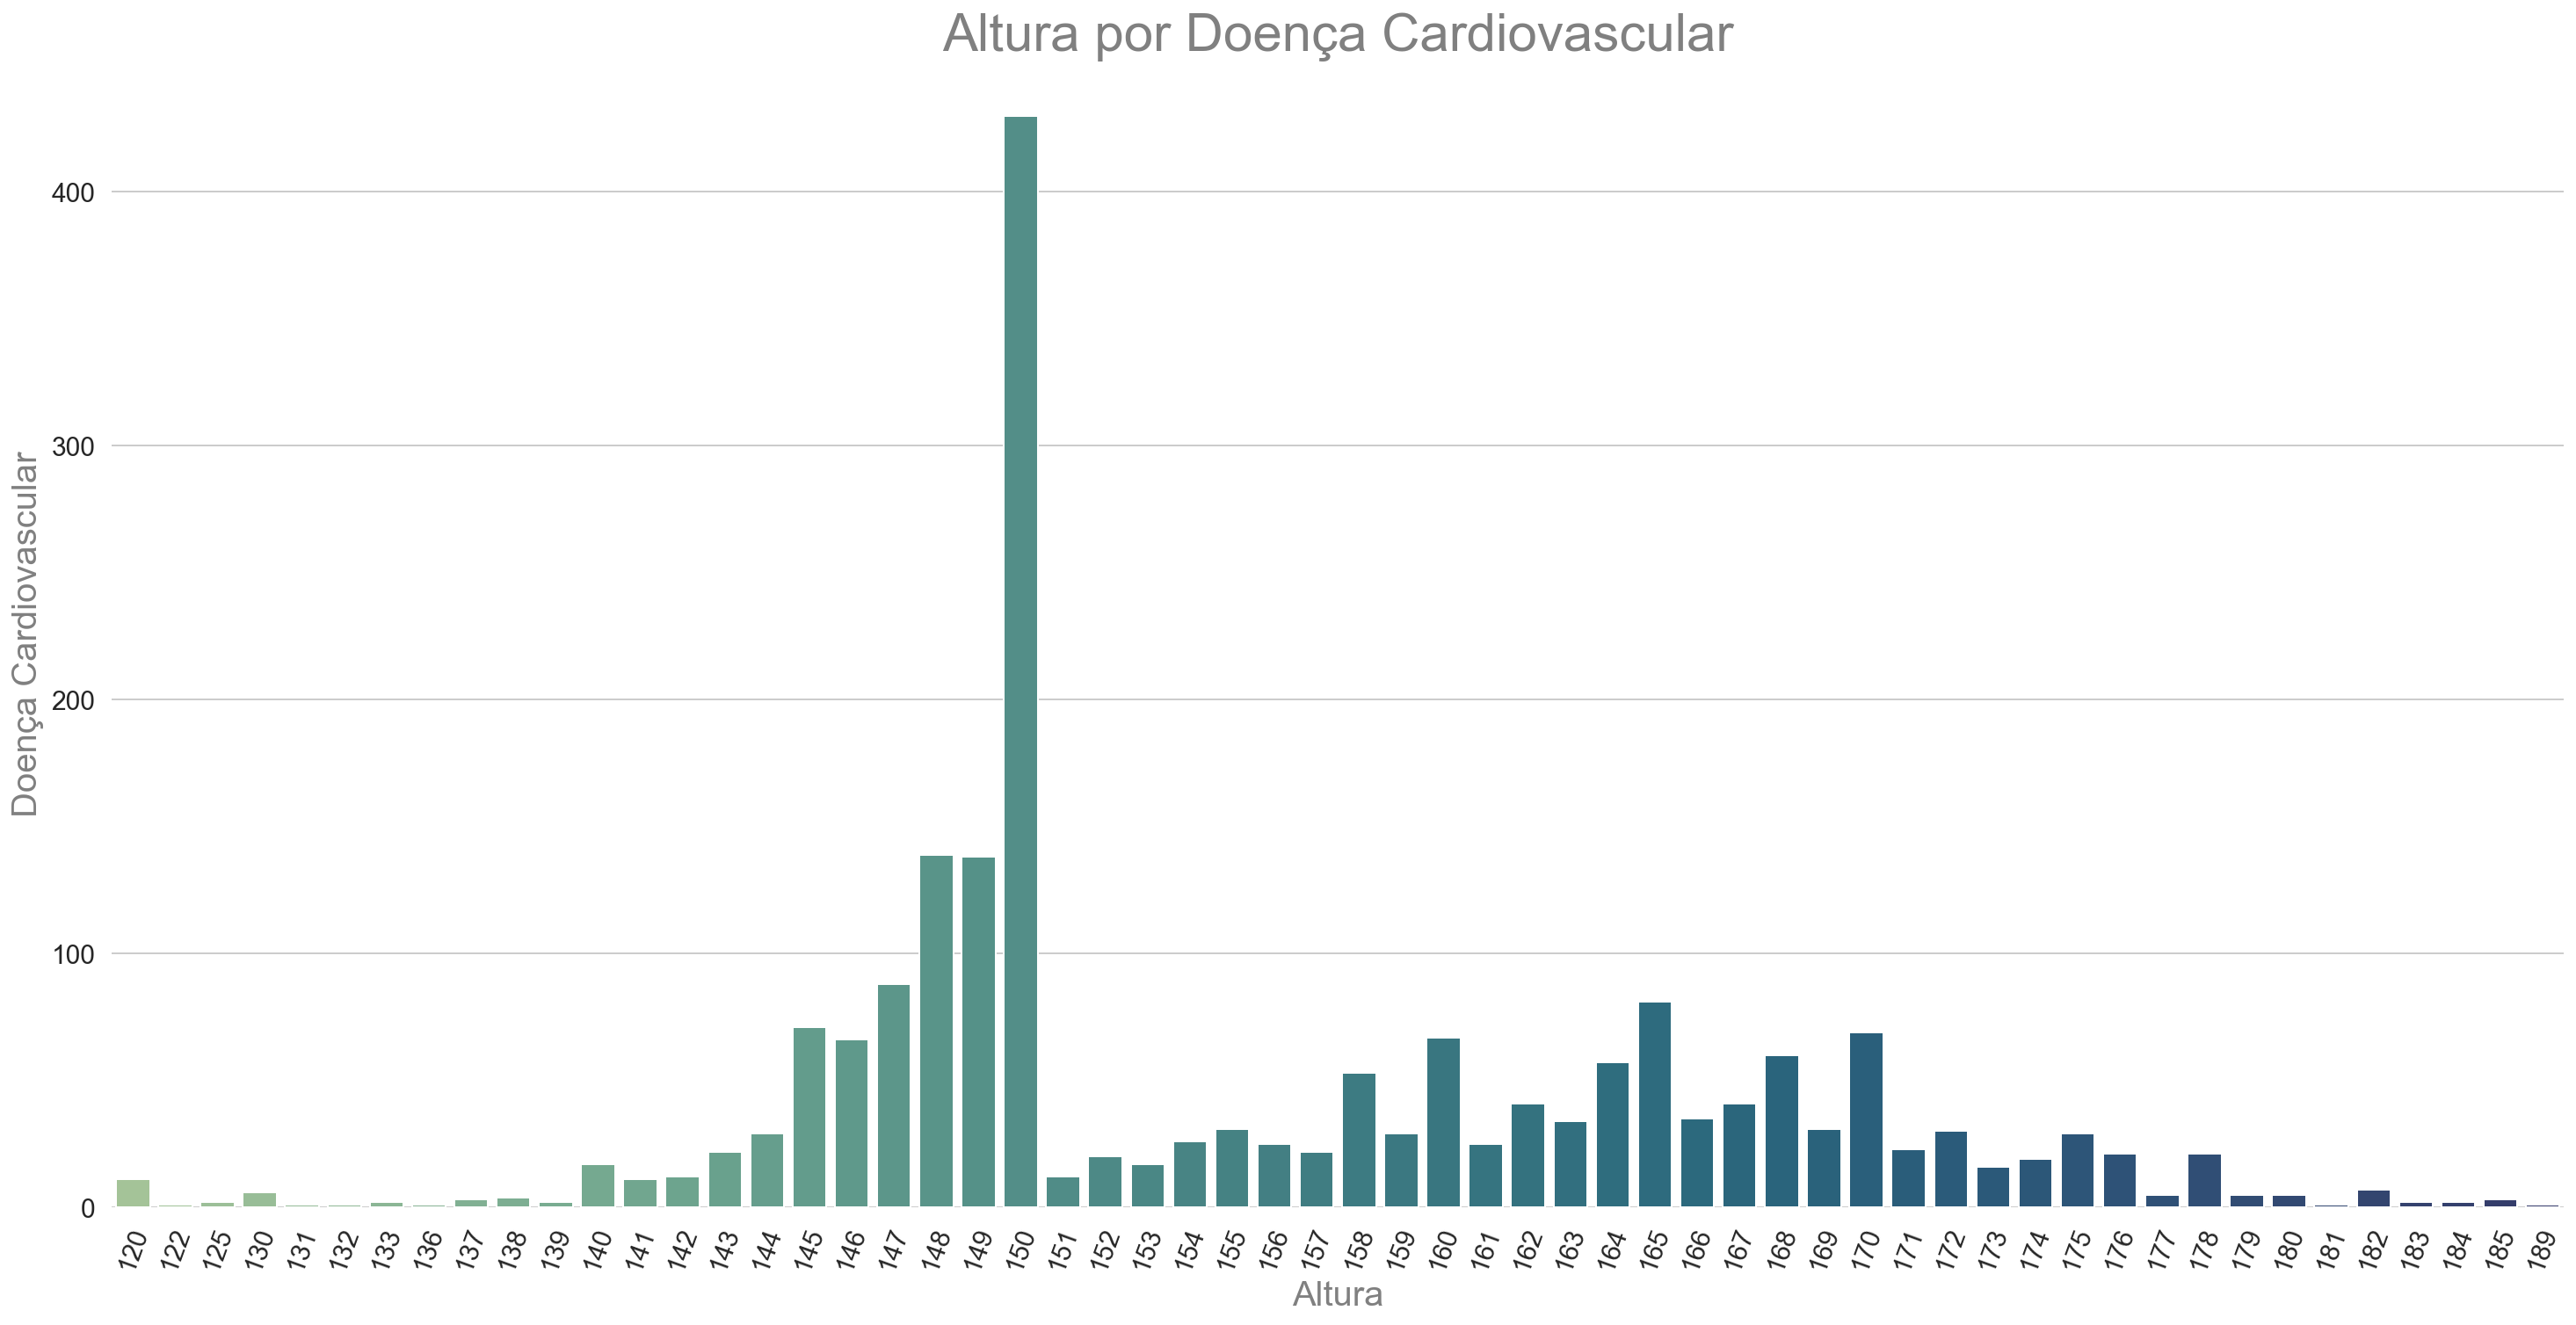

In [67]:
aux1 = df3[df3['height'] <= 150 ].sample(2000, replace=False) 
aux2 = df3[df3['height'] > 150 ].sample(2000, replace=False) 

aux3 = pd.concat([aux1, aux2])
aux4 = aux3[aux3['cardio'] == 1][['height', 'cardio']].groupby('height').sum().reset_index()

sns.barplot( x = 'height', y = 'cardio', data = aux4, palette = 'crest' );
plt.title('Altura por Doença Cardiovascular', size = 30, color = 'grey')
sns.set_style("whitegrid")
sns.despine( bottom = True, left = True)
plt.xticks( rotation = 70, size = 15 )
plt.yticks(size = 15)
plt.xlabel("Altura", size = 20, color = 'grey')
plt.ylabel("Doença Cardiovascular", size = 20, color = 'grey');

**Hipótese verdadeira, mas a correlação é baixa (-0,32)**

### 4.3.3 H3 - Homens têm mais doenças cardiovasculares

In [68]:
aux1 = df3[df3['gender'] == 1].sample(20000, replace=False) 
aux2 = df3[df3['gender'] == 2].sample(20000, replace=False) 

aux3 = pd.concat([aux1, aux2])
aux4 = aux3[aux3['cardio'] == 1][['cardio', 'gender']].groupby(['gender']).sum().reset_index()
aux4

gender  cardio
0       1    9895
1       2   10123

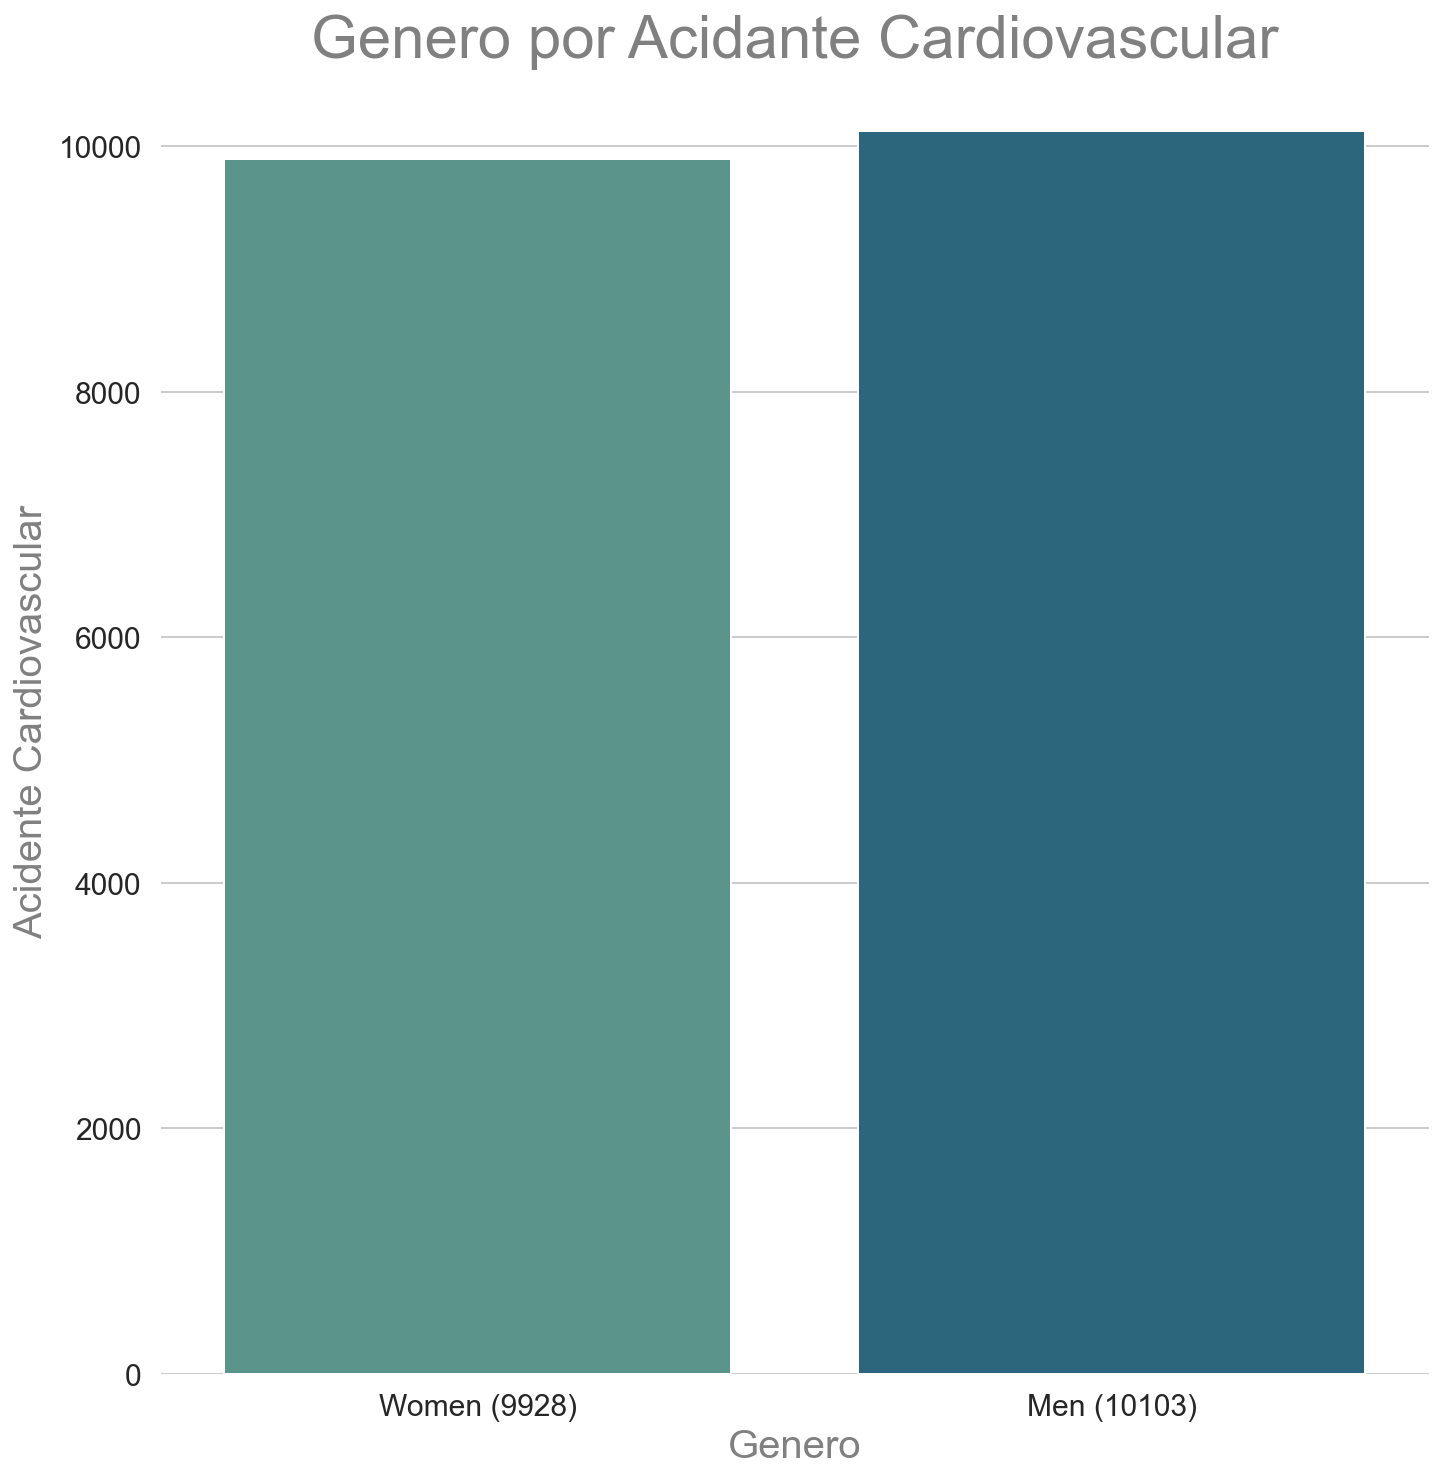

In [69]:
plt.subplot(121)
sns.barplot( x = 'gender', y = 'cardio', data = aux4, palette = 'crest' )
plt.title( 'Genero por Acidante Cardiovascular', size = 30, color = 'gray')
sns.despine(bottom = True, left = True)
plt.xlabel("Genero", size = 20, color = 'grey')
plt.ylabel("Acidente Cardiovascular", size = 20, color = 'grey')
plt.xticks(np.arange(2), ['Women (9928)', 'Men (10103)'], size = 15)
plt.yticks(size = 15);

**Hipótese verdadeira, mas a diferença é mínima**

### 4.3.4 H4 - Pessoas com maior pressão arterial têm mais doenças cardiovasculares

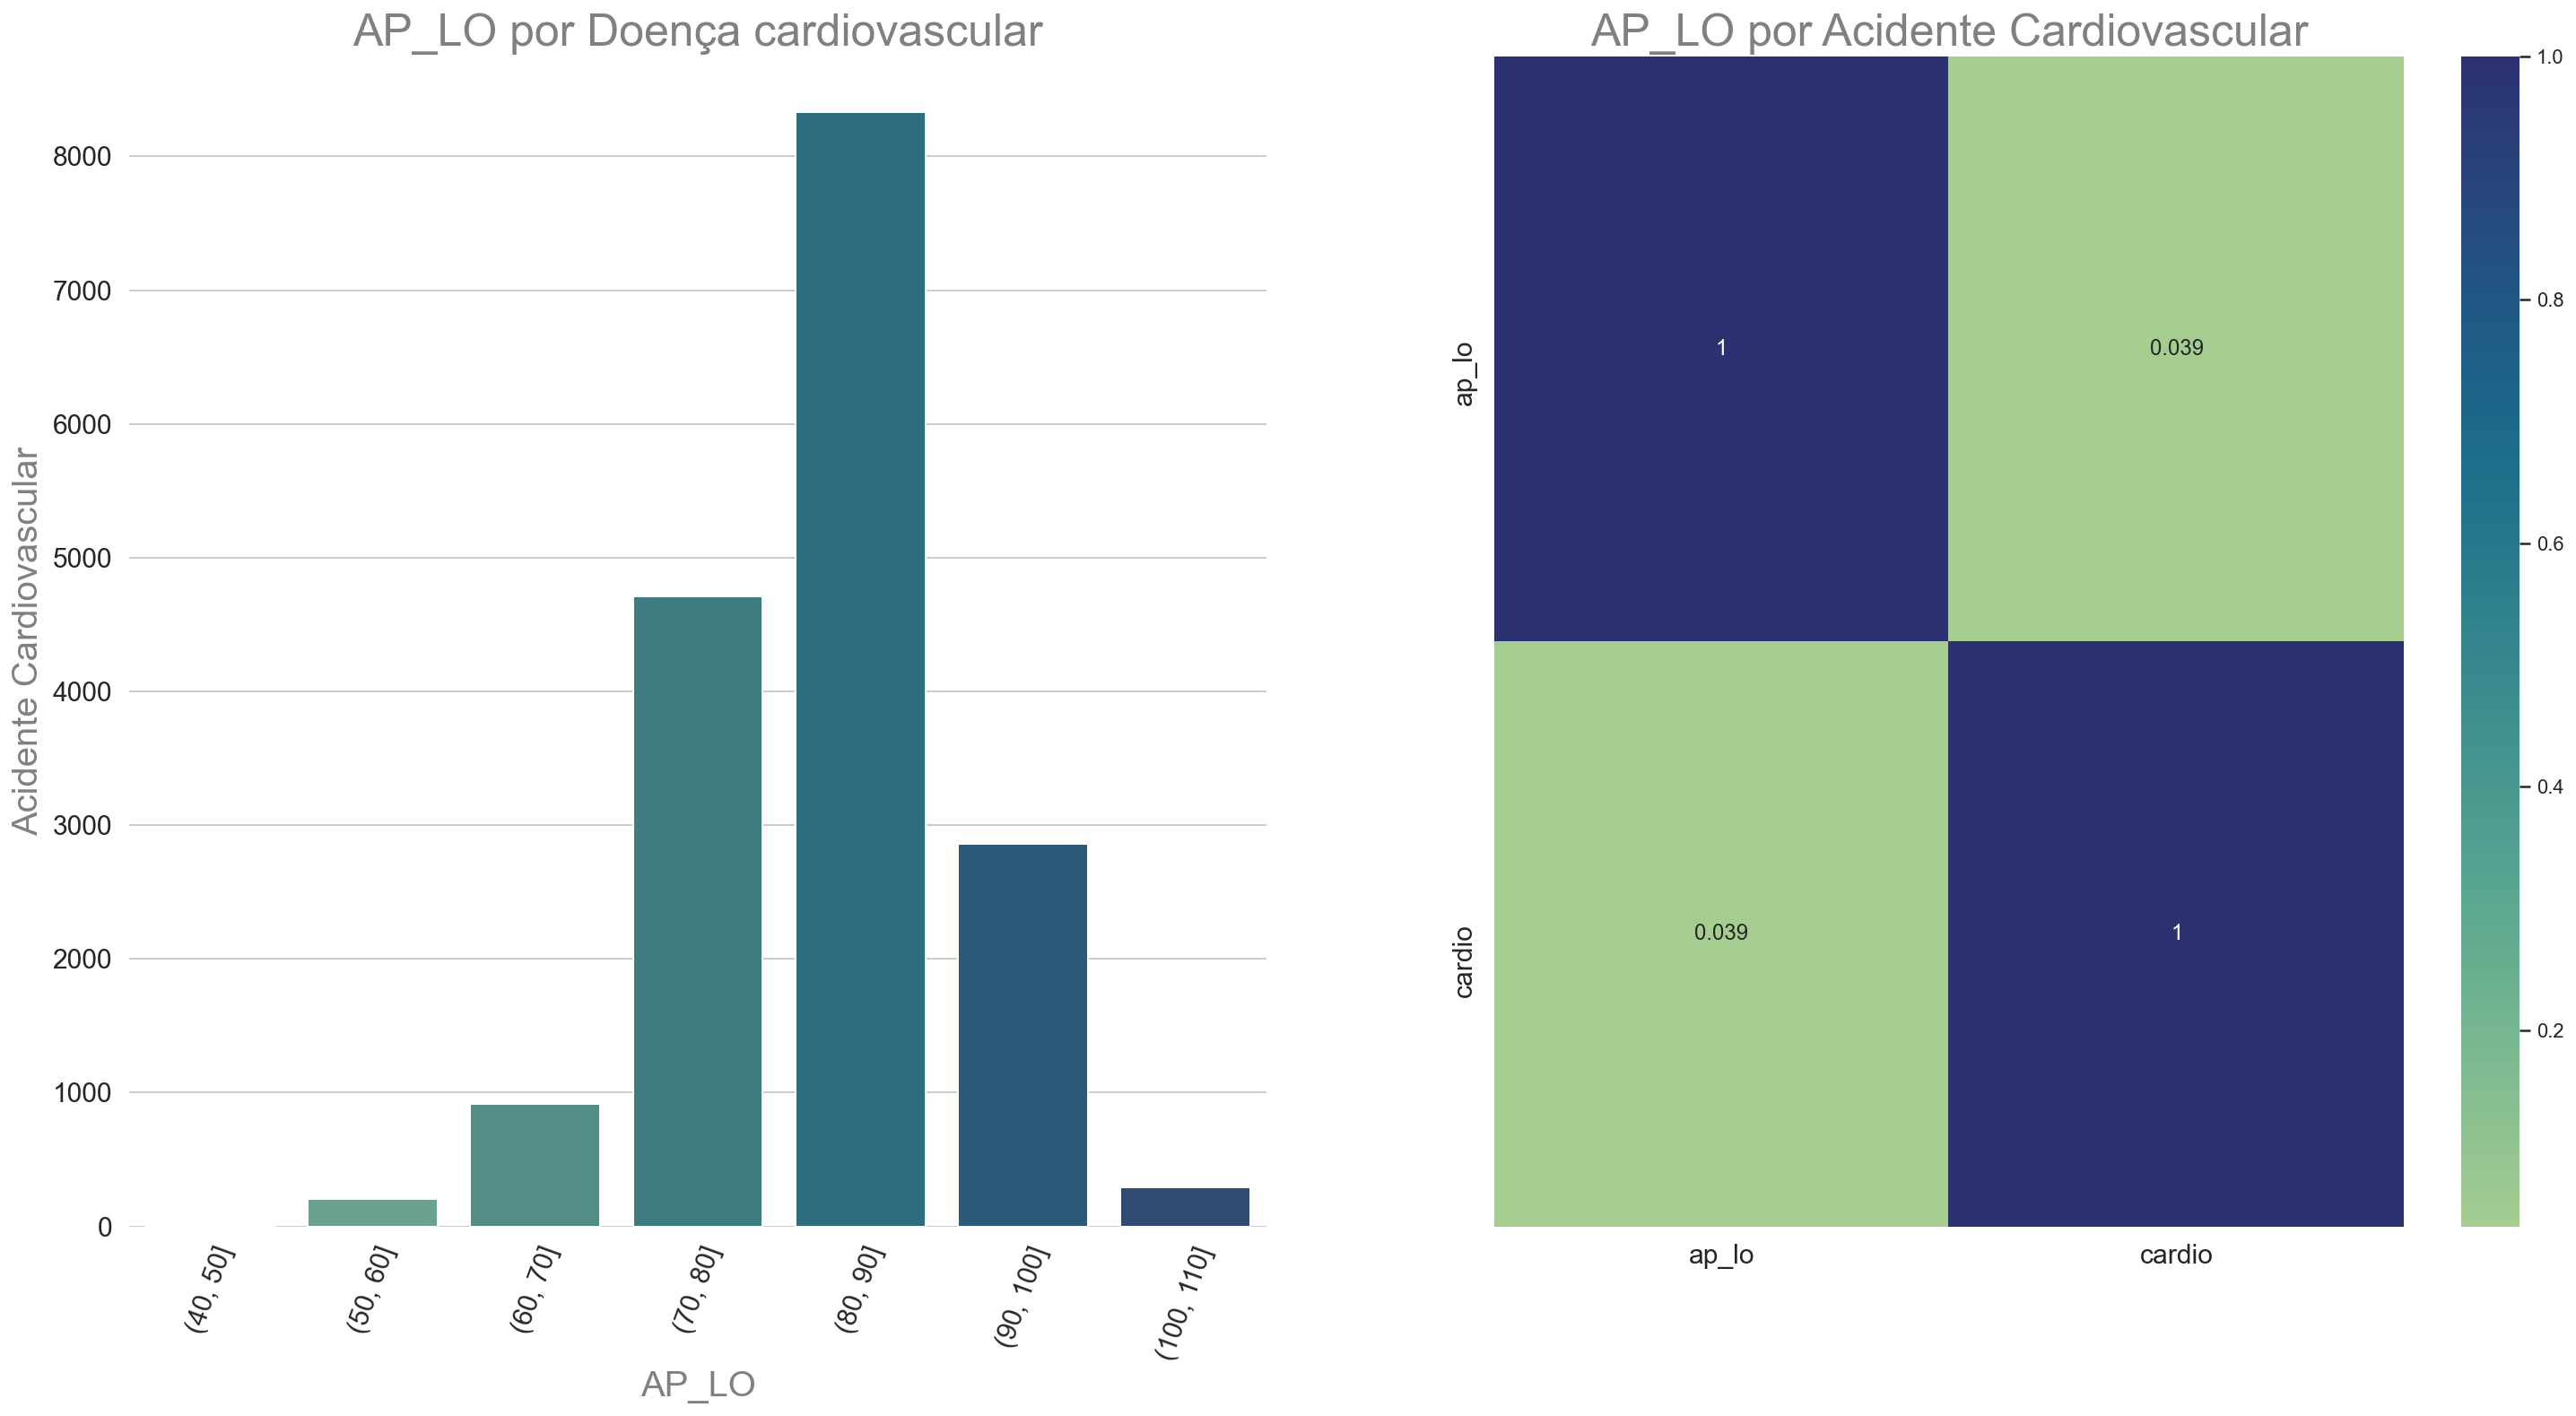

In [70]:
aux1 = df3[df3['ap_lo'] >= 90].sample(15000, replace=False) 
aux2 = df3[df3['ap_lo'] < 90].sample(15000, replace=False) 

aux3 = pd.concat([aux1, aux2])
aux4 = aux3[aux3['cardio'] == 1]

aux5 = aux4[['cardio', 'ap_lo']].groupby(['ap_lo']).sum().reset_index()

bins = list( np.arange( 40, 120, 10) )
aux5['ap_lo_bin'] = pd.cut( aux5[ 'ap_lo' ], bins = bins )
aux6 = aux5[['cardio', 'ap_lo_bin']].groupby(['ap_lo_bin']).sum().reset_index()

plt.subplot(121)
sns.barplot( x = 'ap_lo_bin', y = 'cardio', data = aux6, palette = 'crest' )
sns.despine( bottom = True, left = True)
plt.title( 'AP_LO por Doença cardiovascular', size = 25, color = 'gray')
plt.xlabel("AP_LO", size = 20, color = 'grey')
plt.ylabel("Acidente Cardiovascular", size = 20, color = 'grey')
plt.xticks(size = 15, rotation = 70)
plt.yticks(size = 15);

plt.subplot(122)
sns.heatmap( aux5.corr( method='pearson' ), annot=True, cmap="crest" )
sns.despine( bottom = True, left = True)
plt.title( 'AP_LO por Acidente Cardiovascular', size = 25, color = 'gray')
plt.xticks(size = 15)
plt.yticks(size = 15);

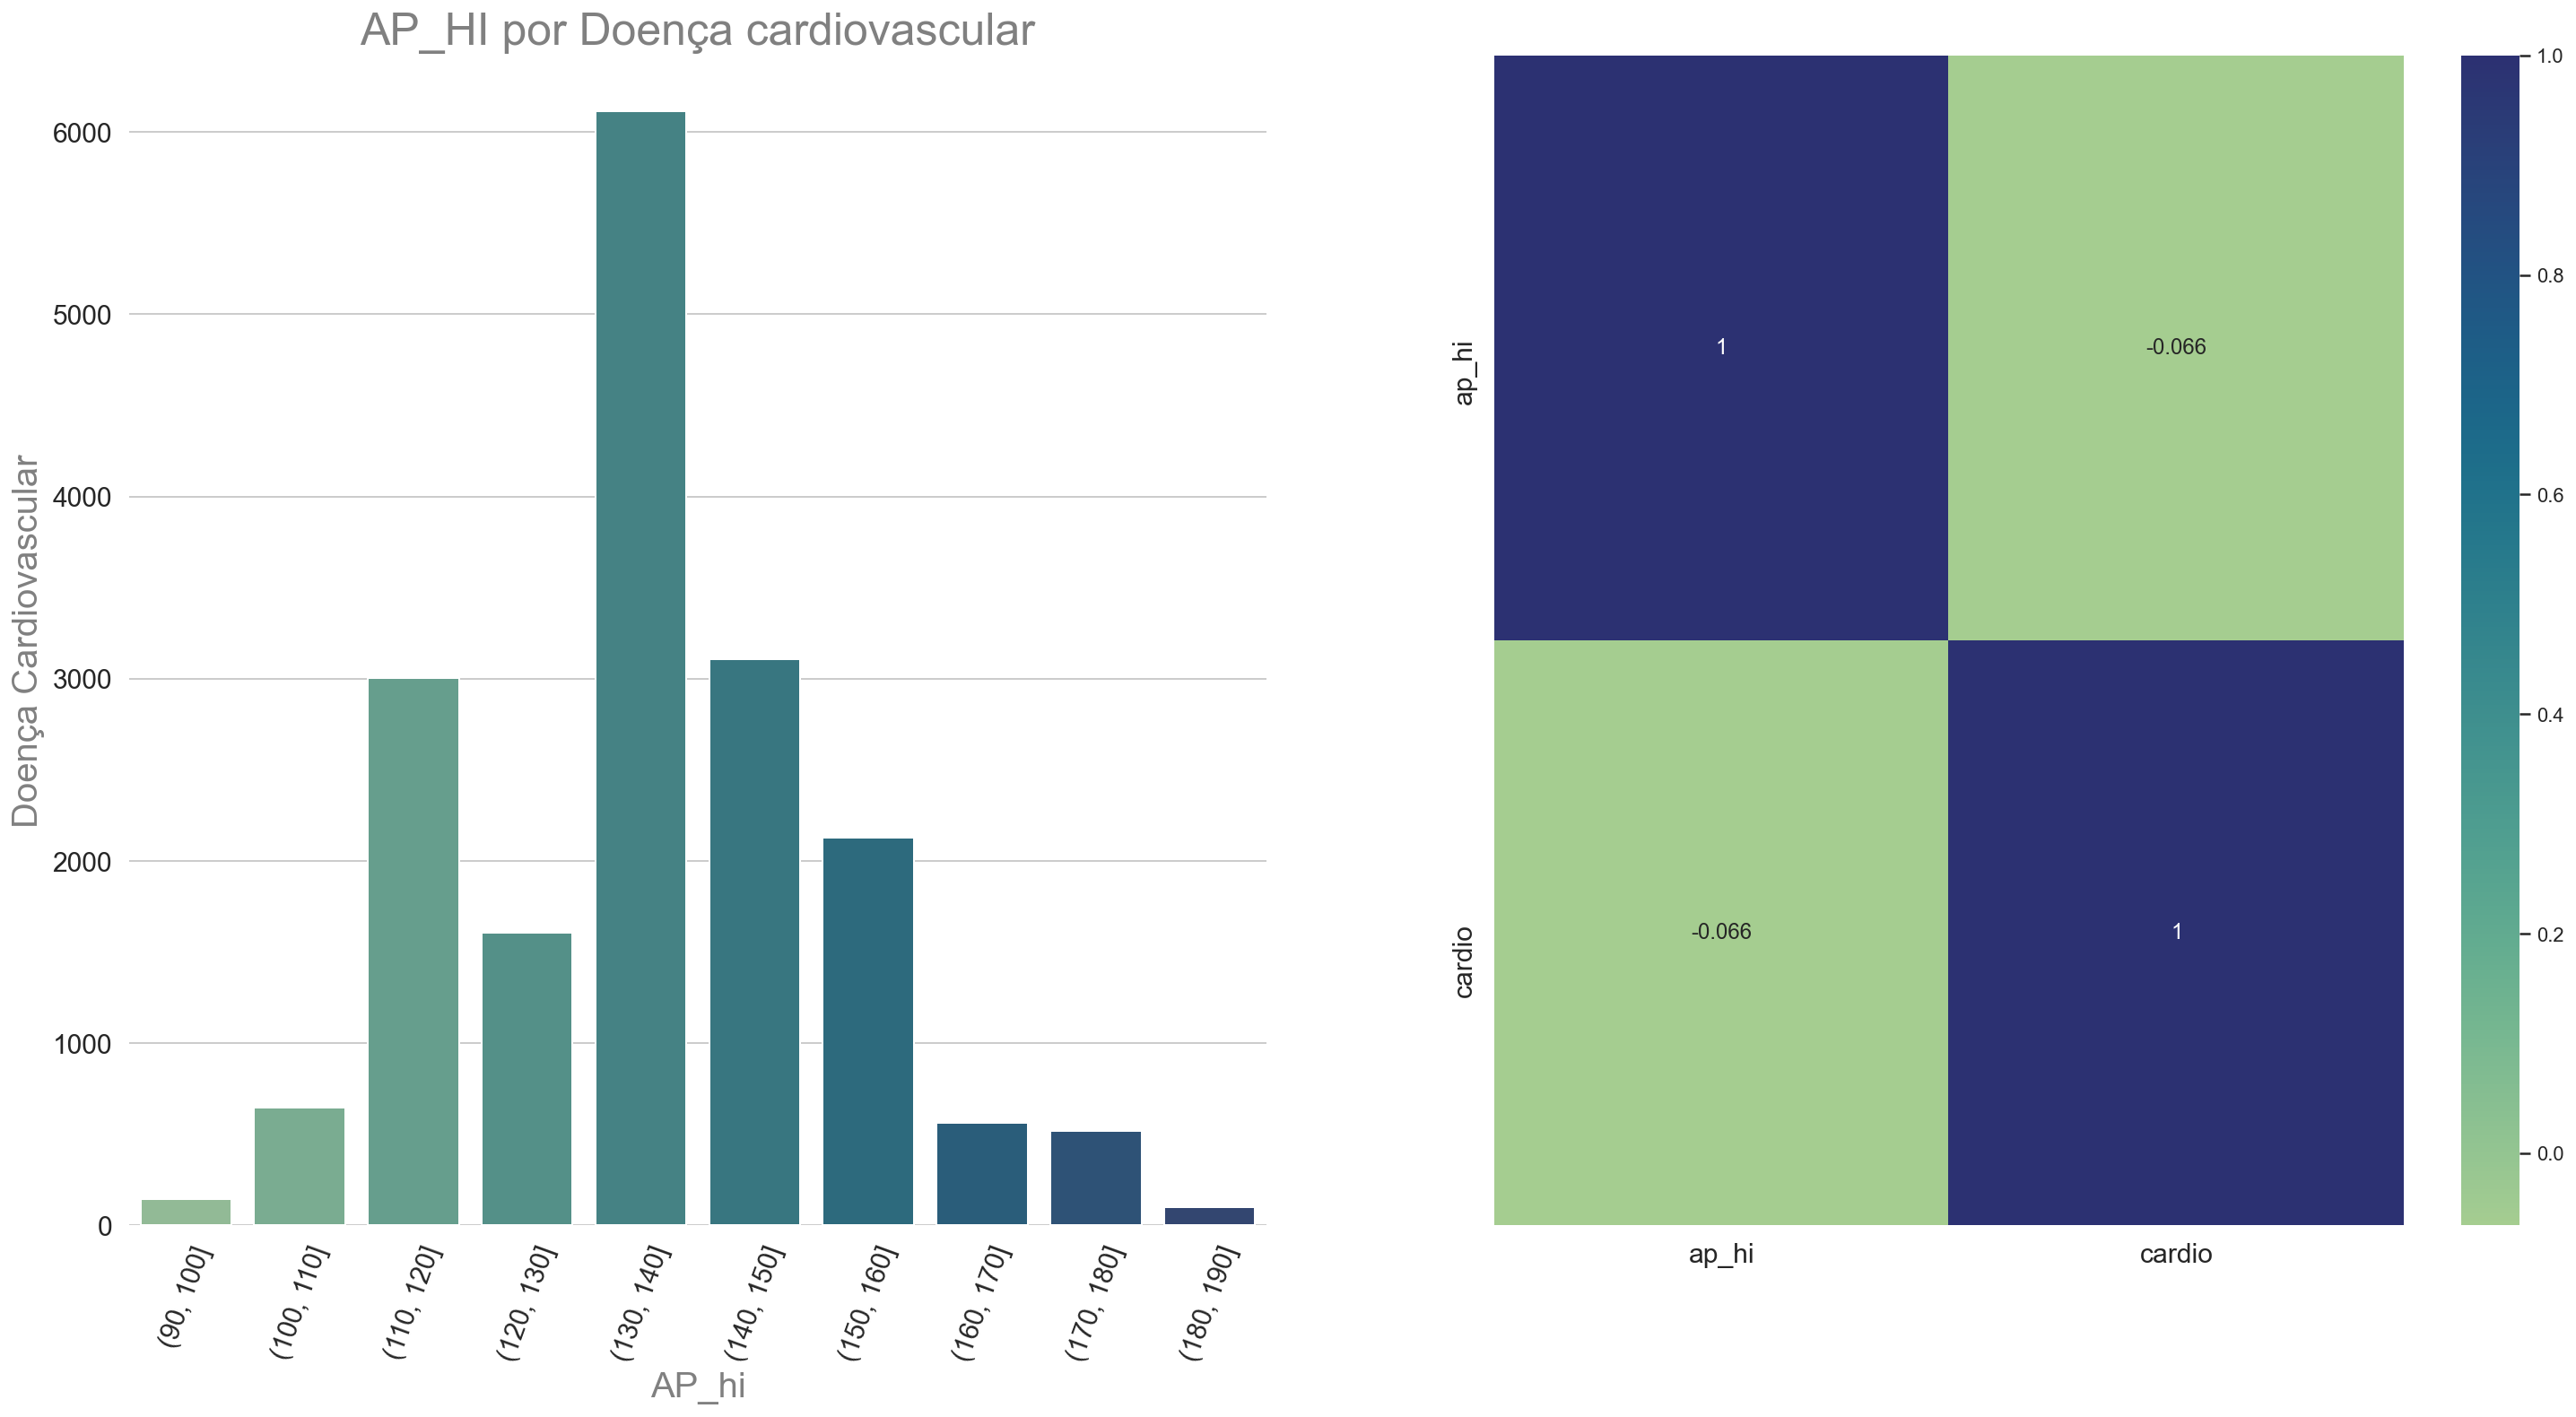

In [71]:
aux1 = df3[df3['ap_hi'] >= 140].sample(15000, replace=False) 
aux2 = df3[df3['ap_hi'] < 140].sample(15000, replace=False) 

aux3 = pd.concat([aux1, aux2])
aux4 = aux3[aux3['cardio'] == 1]

aux5 = aux4[['cardio', 'ap_hi']].groupby(['ap_hi']).sum().reset_index()

bins = list( np.arange( 90, 200, 10) )
aux5['ap_hi_bin'] = pd.cut( aux5[ 'ap_hi' ], bins = bins )
aux6 = aux5[['cardio', 'ap_hi_bin']].groupby(['ap_hi_bin']).sum().reset_index()

plt.subplot(121)
sns.barplot( x = 'ap_hi_bin', y = 'cardio', data = aux6, palette = 'crest' )
sns.despine( bottom = True, left = True)
plt.title( 'AP_HI por Doença cardiovascular', size = 25, color = 'gray')
plt.xlabel("AP_hi", size = 20, color = 'grey')
plt.ylabel("Doença Cardiovascular", size = 20, color = 'grey')
plt.xticks(size = 15, rotation = 70)
plt.yticks(size = 15)

plt.subplot(122)
sns.heatmap( aux5.corr( method='pearson' ), annot=True, cmap="crest" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15);

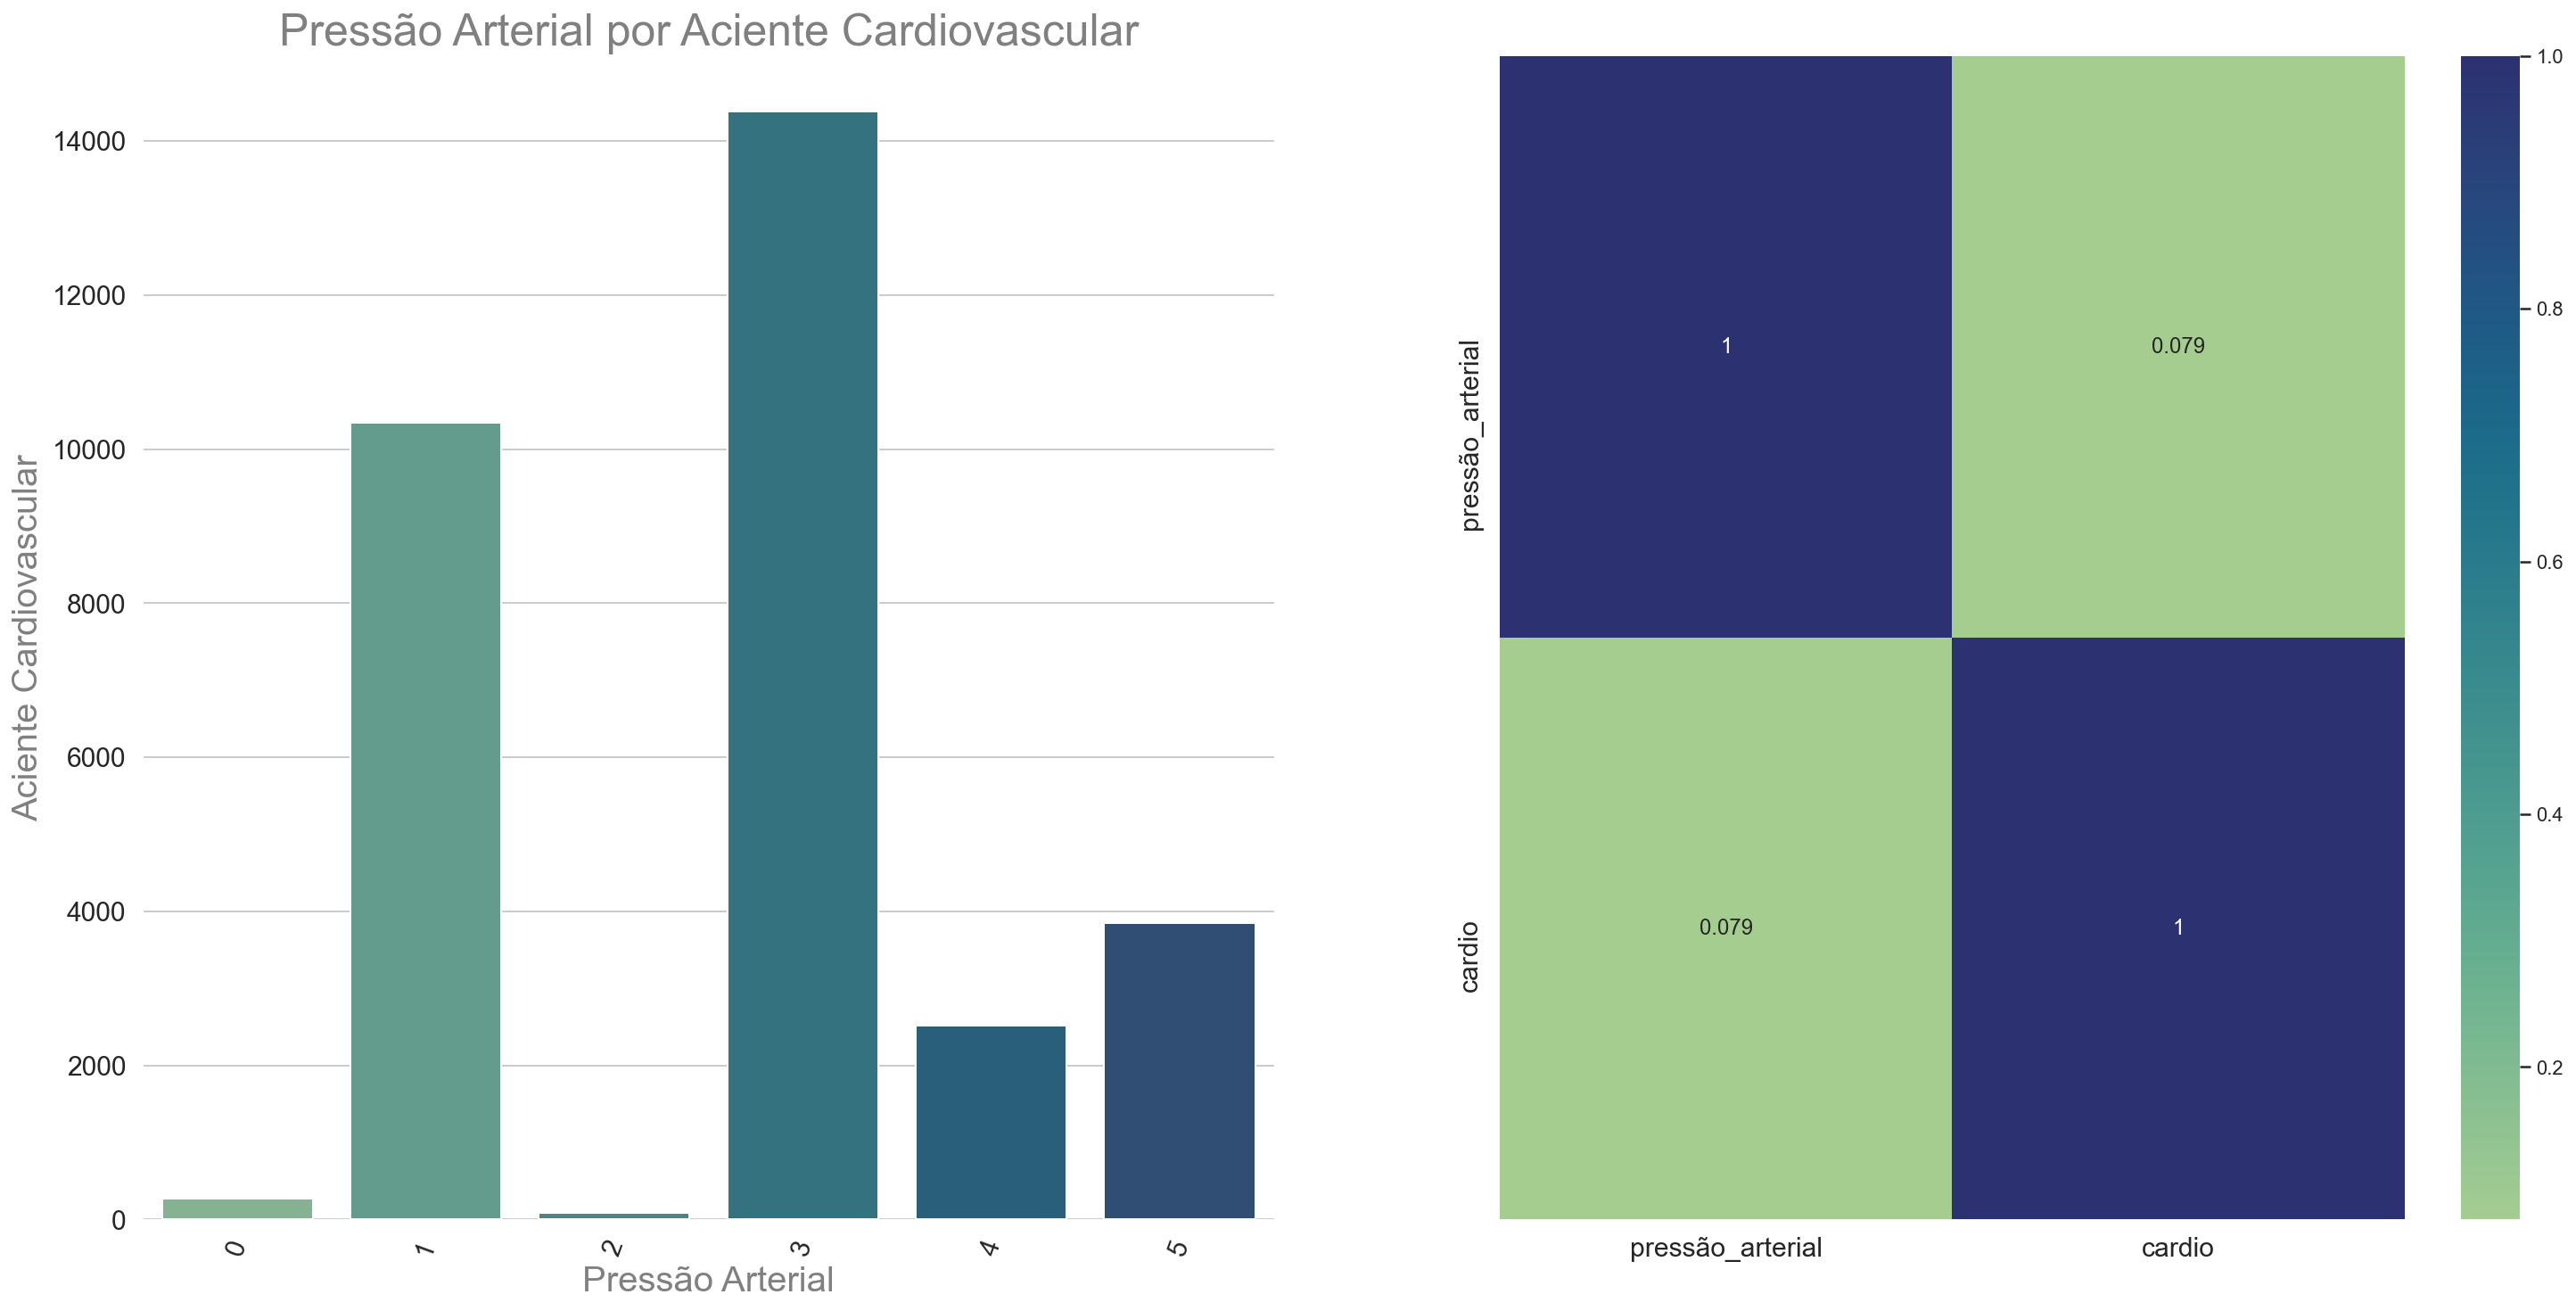

In [72]:
aux = df3[df3['cardio'] == 1][['cardio', 'pressão_arterial']].groupby(['pressão_arterial']).sum().reset_index()

plt.subplot(121)
sns.barplot( x = 'pressão_arterial', y = 'cardio', data = aux, palette = 'crest' )
sns.despine( bottom = True, left = True)
plt.title( 'Pressão Arterial por Aciente Cardiovascular', size = 25, color = 'gray')
plt.xlabel("Pressão Arterial", size = 20, color = 'grey')
plt.ylabel("Aciente Cardiovascular", size = 20, color = 'grey')
plt.xticks(size = 15, rotation = 70)
plt.yticks(size = 15)

plt.subplot(122)
sns.heatmap( aux.corr( method='pearson' ), annot=True, cmap="crest" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15);

**Falsa Hipóteses, as correlações são insignificantes**

### 4.3.5 H5 - Pessoas com colesterol mais alto têm mais doenças cardiovasculares

In [73]:
df3['cholesterol'].head()

33147    1
1100     1
51088    1
16518    3
68922    1
Name: cholesterol, dtype: int64

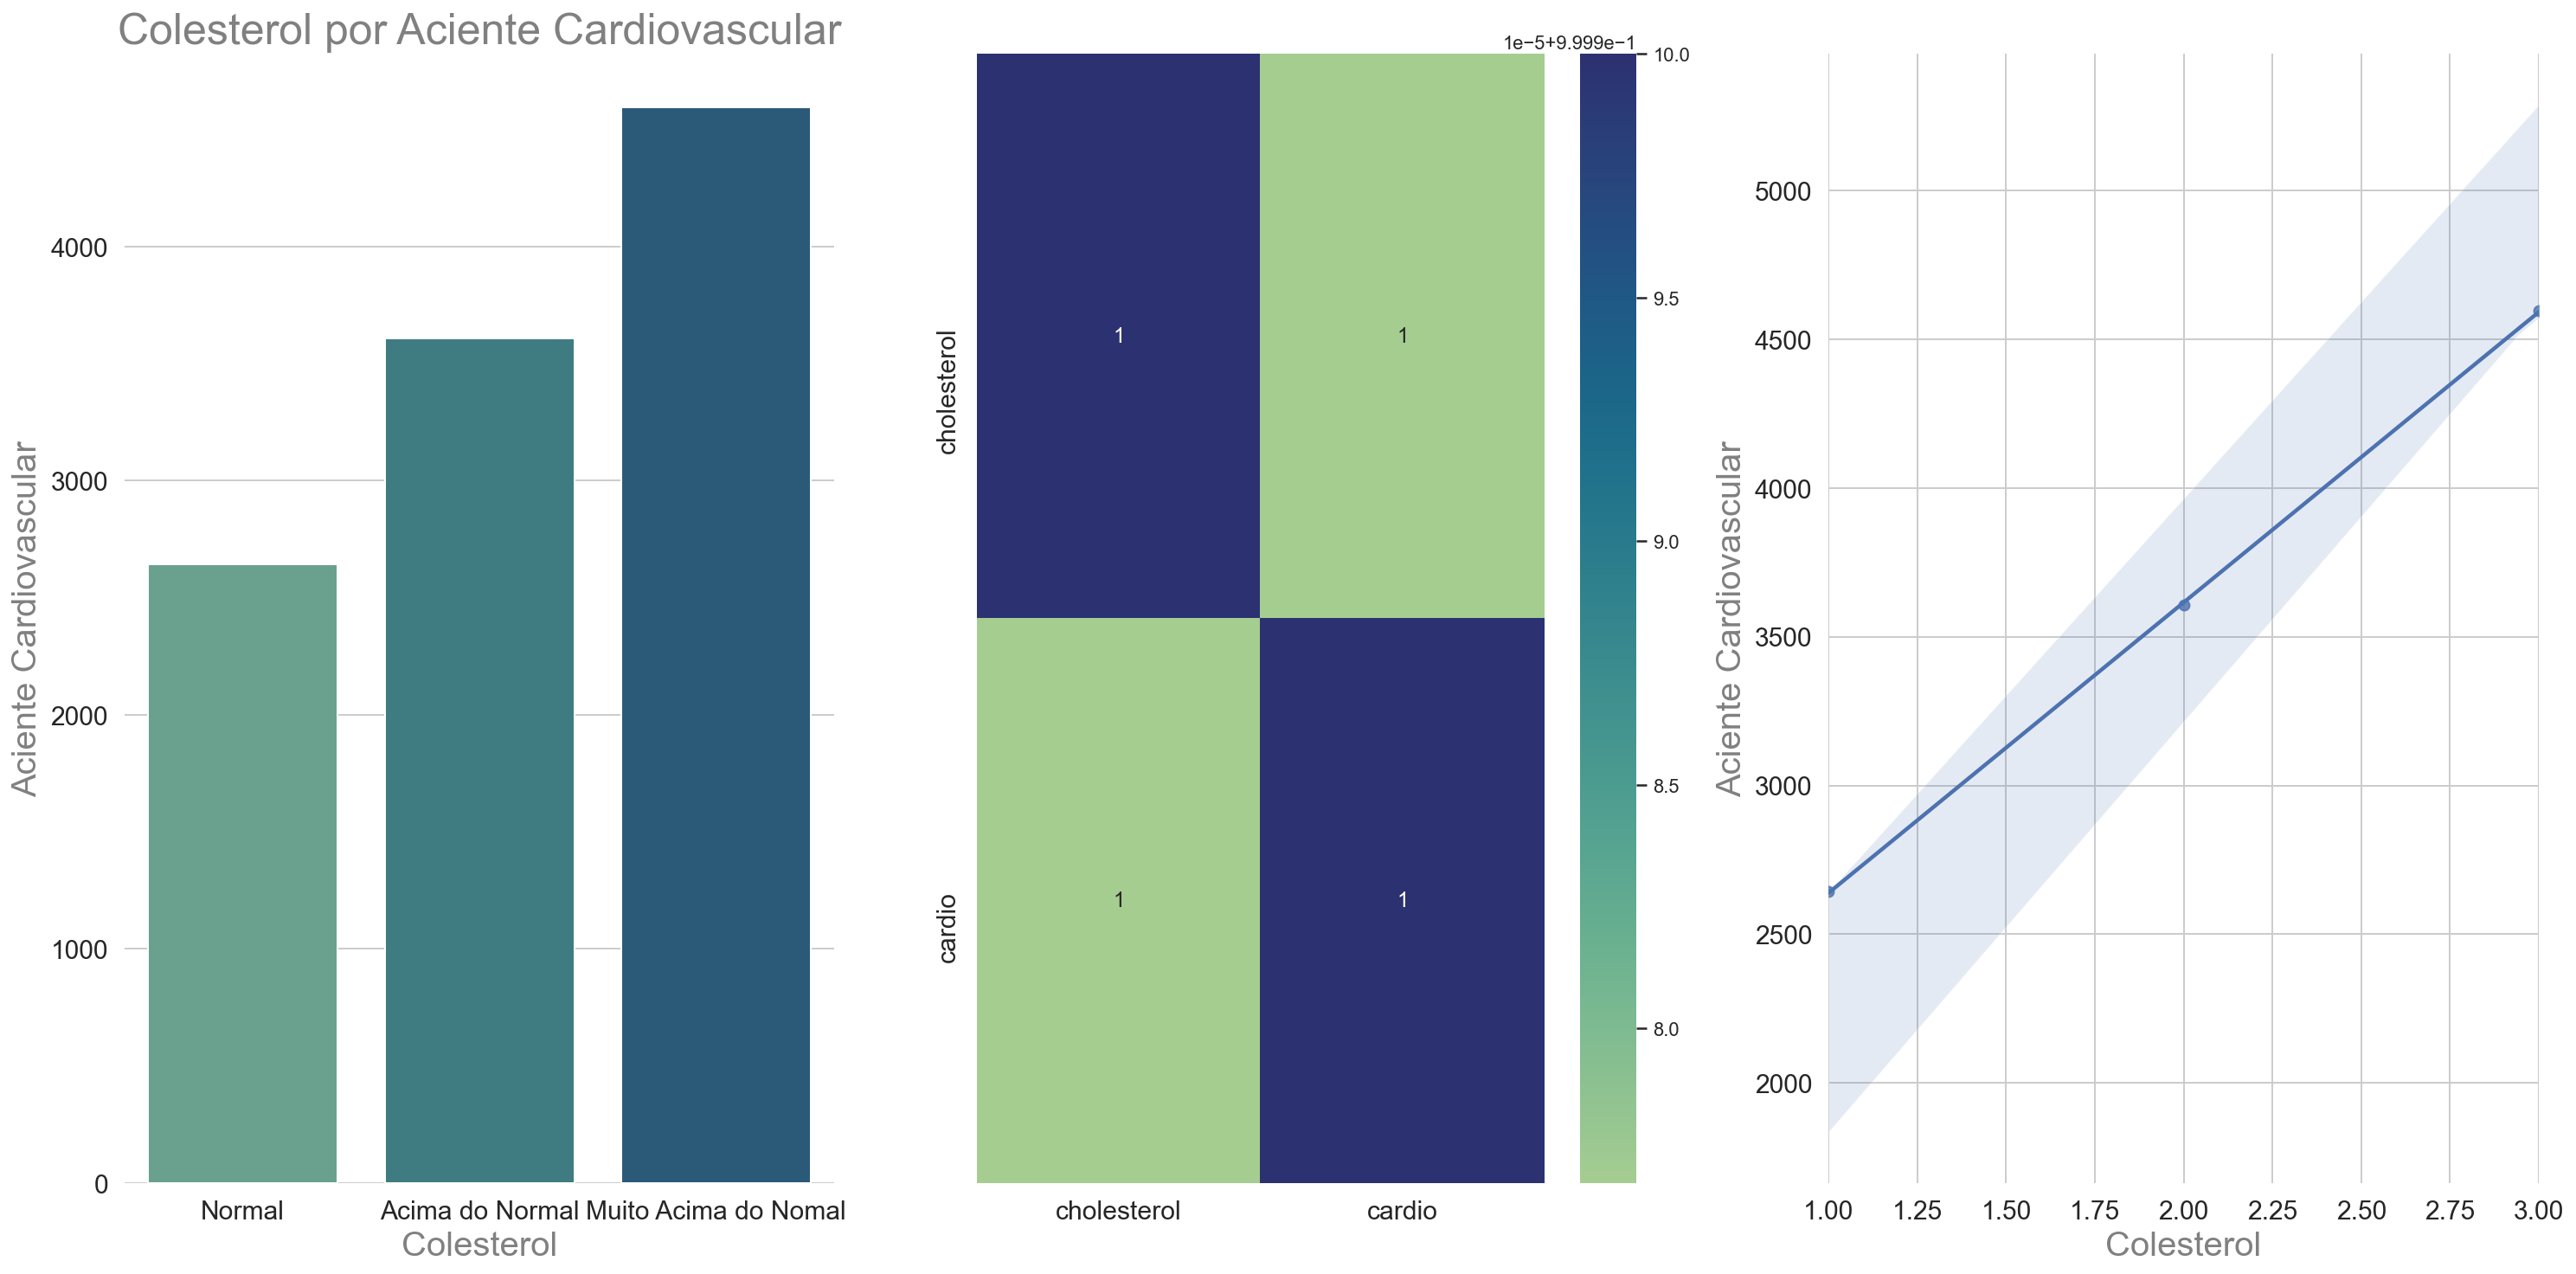

In [74]:
aux1 = df3[df3['cholesterol'] == 1].sample(6000, replace=False)
aux2 = df3[df3['cholesterol'] == 2].sample(6000, replace=False)
aux3 = df3[df3['cholesterol'] == 3].sample(6000, replace=False)
aux4 = pd.concat([aux1, aux2, aux3])
aux5 = aux4[aux4['cardio']==1][['cardio', 'cholesterol']].groupby(['cholesterol']).sum().reset_index()
        
plt.subplot(131)
sns.barplot( x = 'cholesterol', y = 'cardio', data = aux5, palette = 'crest' )
sns.despine( bottom = True, left = True)
plt.title( 'Colesterol por Aciente Cardiovascular', size = 25, color = 'gray')
plt.xlabel("Colesterol", size = 20, color = 'grey')
plt.ylabel("Aciente Cardiovascular", size = 20, color = 'grey')
plt.xticks(np.arange(3), ['Normal', 'Acima do Normal', 'Muito Acima do Nomal'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.subplot(132)
sns.heatmap( aux5.corr( method='pearson' ), annot=True, cmap="crest" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.subplot(133)
sns.regplot( x = 'cholesterol', y = 'cardio', data = aux5)
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Colesterol", size = 20, color = 'grey')
plt.ylabel("Aciente Cardiovascular", size = 20, color = 'grey');

 **Hipótese Verdadeira, a correlação é perfeita (1)**

### 4.3.6 H6 - Pessoas com maior glicose têm mais doenças cardiovasculares

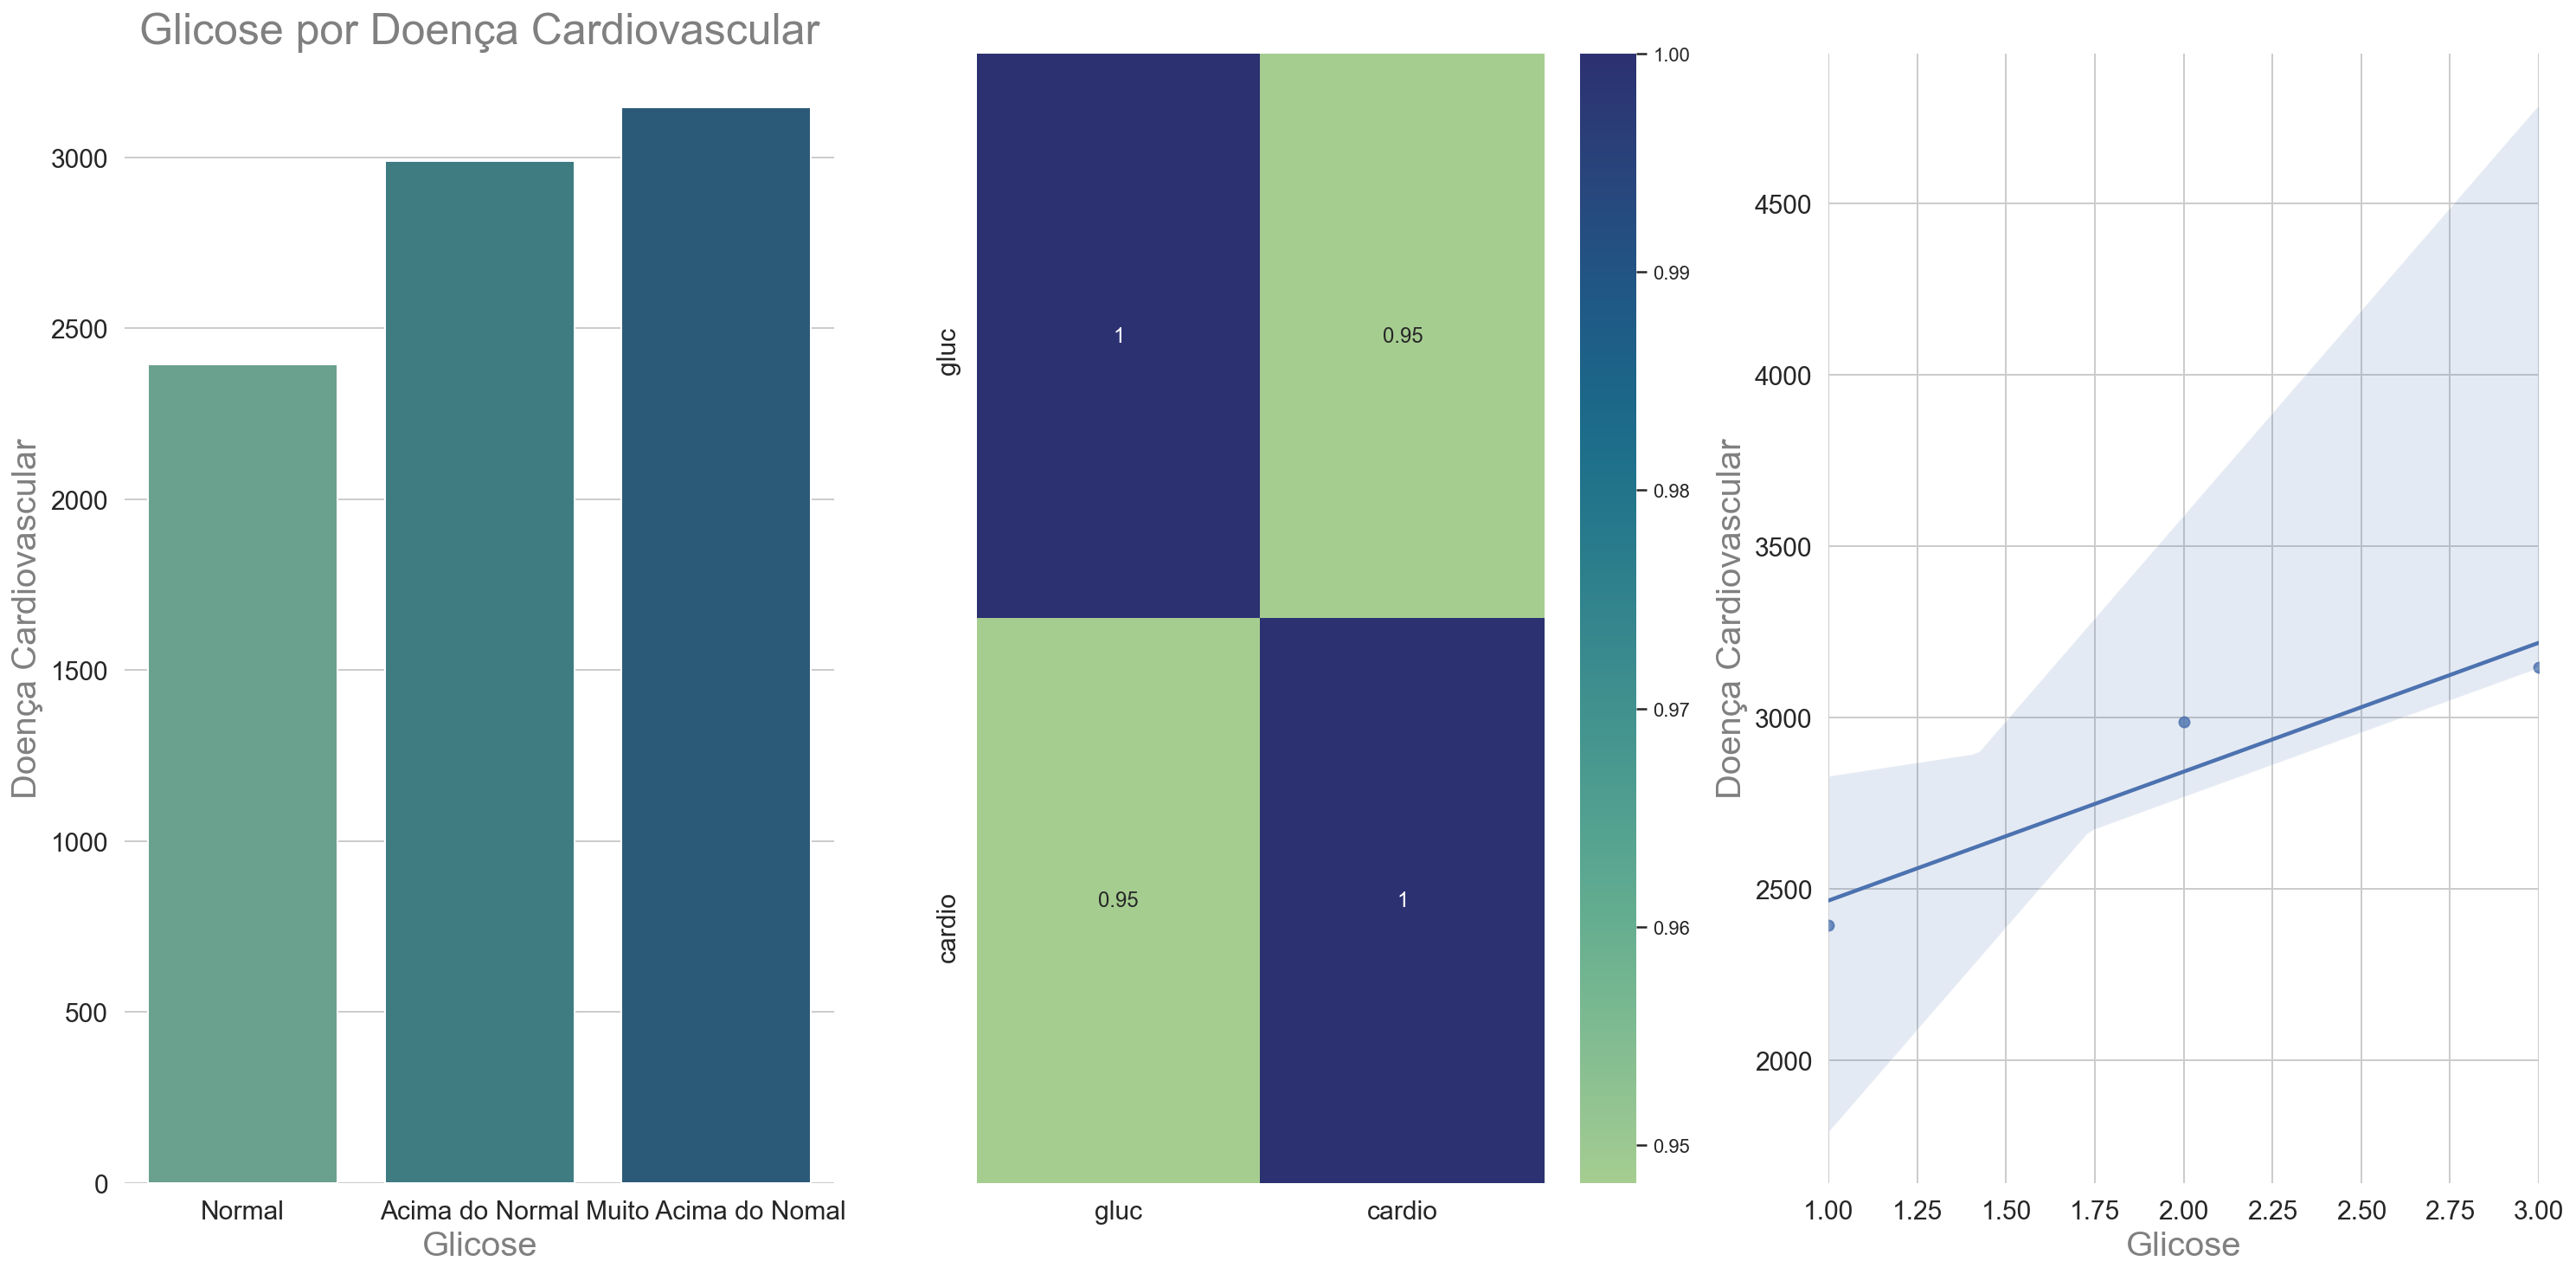

In [75]:
aux1 = df3[df3['gluc'] == 1].sample(5000, replace=True)
aux2 = df3[df3['gluc'] == 2].sample(5000, replace=True)
aux3 = df3[df3['gluc'] == 3].sample(5000, replace=True)
aux4 = pd.concat([aux1, aux2, aux3])
aux5 = aux4[aux4['cardio']==1][['cardio', 'gluc']].groupby(['gluc']).sum().reset_index()
        
plt.subplot(131)
sns.barplot( x = 'gluc', y = 'cardio', data = aux5, palette = 'crest' )
sns.despine( bottom = True, left = True)
plt.title( 'Glicose por Doença Cardiovascular', size = 25, color = 'gray')
plt.xlabel("Glicose", size = 20, color = 'grey')
plt.ylabel("Doença Cardiovascular", size = 20, color = 'grey')
plt.xticks(np.arange(3), ['Normal', 'Acima do Normal', 'Muito Acima do Nomal'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.subplot(132)
sns.heatmap( aux5.corr( method='pearson' ), annot=True, cmap="crest" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.subplot(133)
sns.regplot( x = 'gluc', y = 'cardio', data = aux5)
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Glicose", size = 20, color = 'grey')
plt.ylabel("Doença Cardiovascular", size = 20, color = 'grey');

**Hipótese Verdadeira, a correlação é muito forte (0,95)**

### 4.3.7 H7 - Pessoas que fumam têm mais doenças cardiovasculares

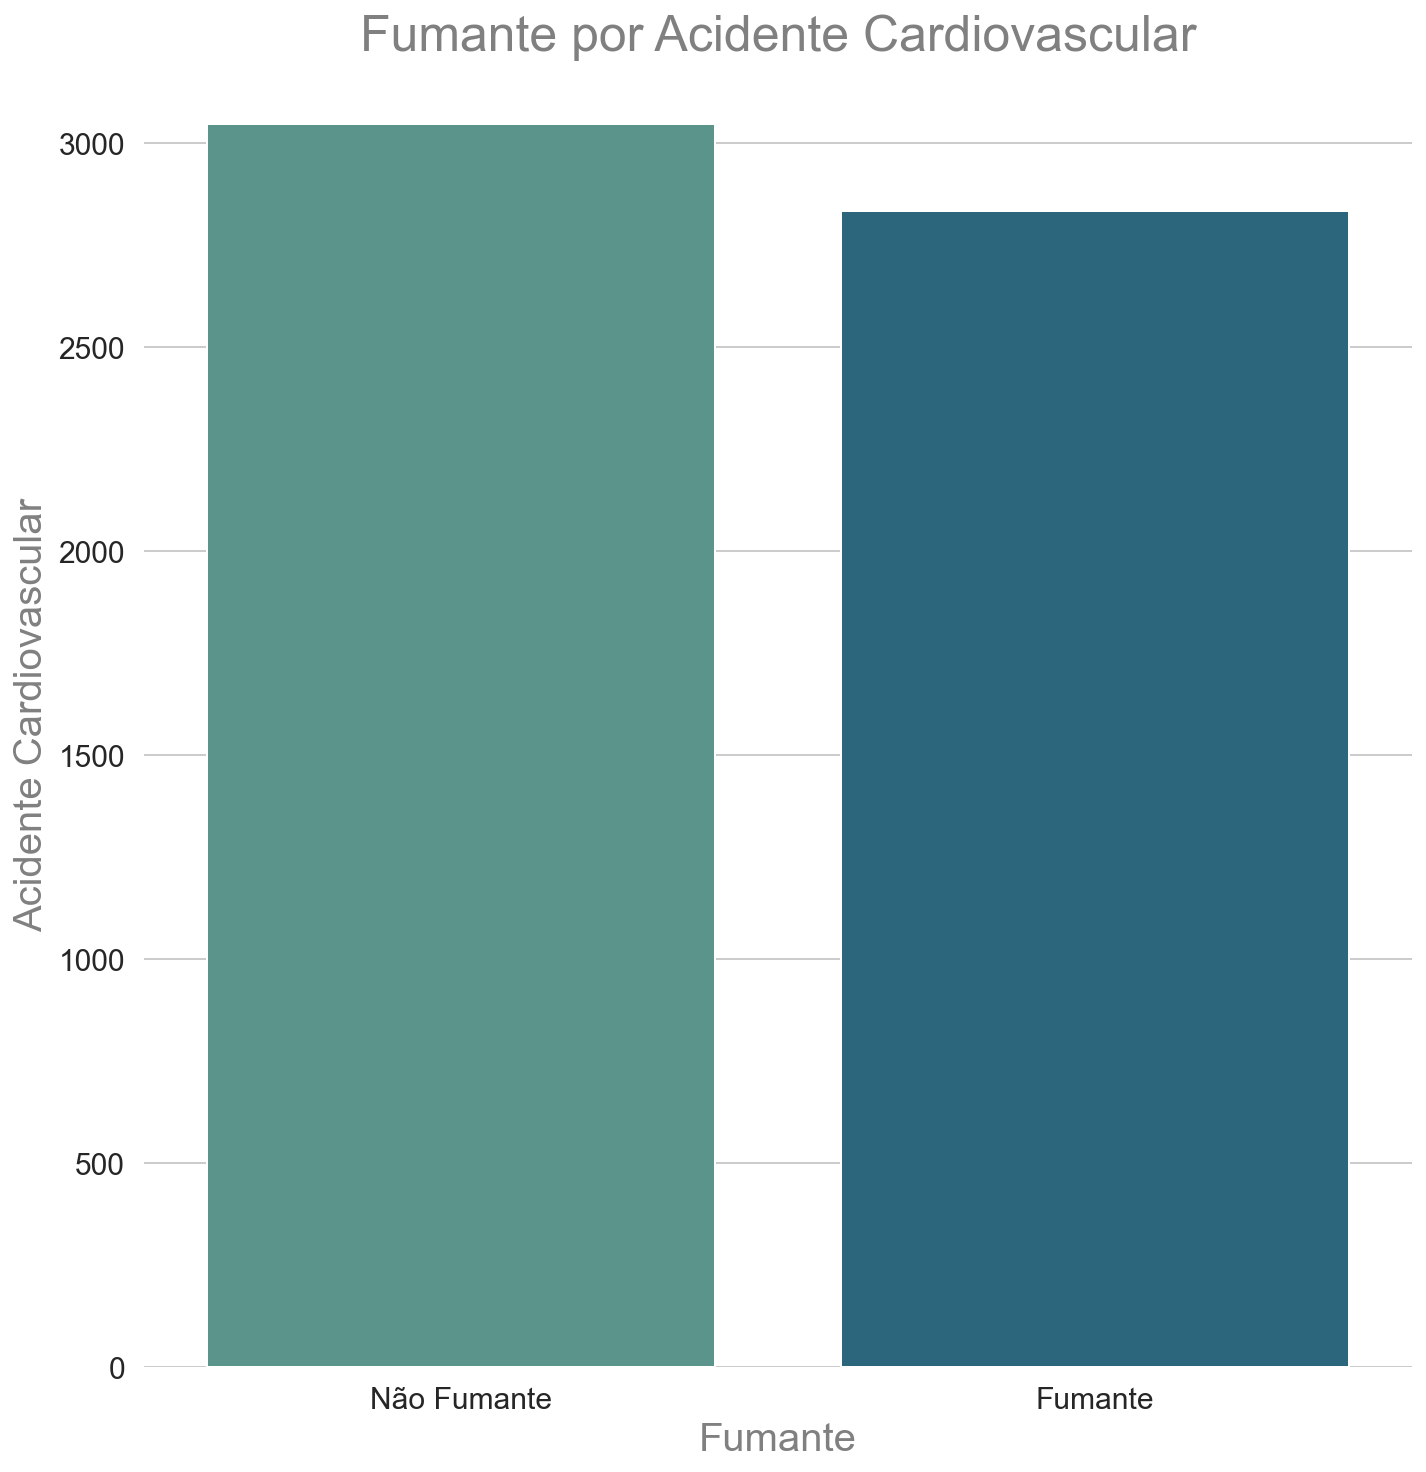

In [76]:
aux1 = df3[df3['smoke'] == 0].sample(6000, replace=True)
aux2 = df3[df3['smoke'] == 1].sample(6000, replace=True)
aux3 = pd.concat([aux1, aux2])
aux4 = aux3[aux3['cardio']==1][['cardio', 'smoke']].groupby(['smoke']).sum().reset_index()

plt.subplot(121)
sns.barplot( x = 'smoke', y = 'cardio', data = aux4, palette = 'crest' )
sns.despine( bottom = True, left = True)
plt.title( 'Fumante por Acidente Cardiovascular', size = 25, color = 'gray')
plt.xlabel("Fumante", size = 20, color = 'grey')
plt.ylabel("Acidente Cardiovascular", size = 20, color = 'grey')
plt.xticks(np.arange(2), ['Não Fumante', 'Fumante'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

**Falsa hipótese, mas a diferença é mínima**

### 4.3.8 H8 - Pessoas que bebem álcool têm mais doenças cardiovasculares

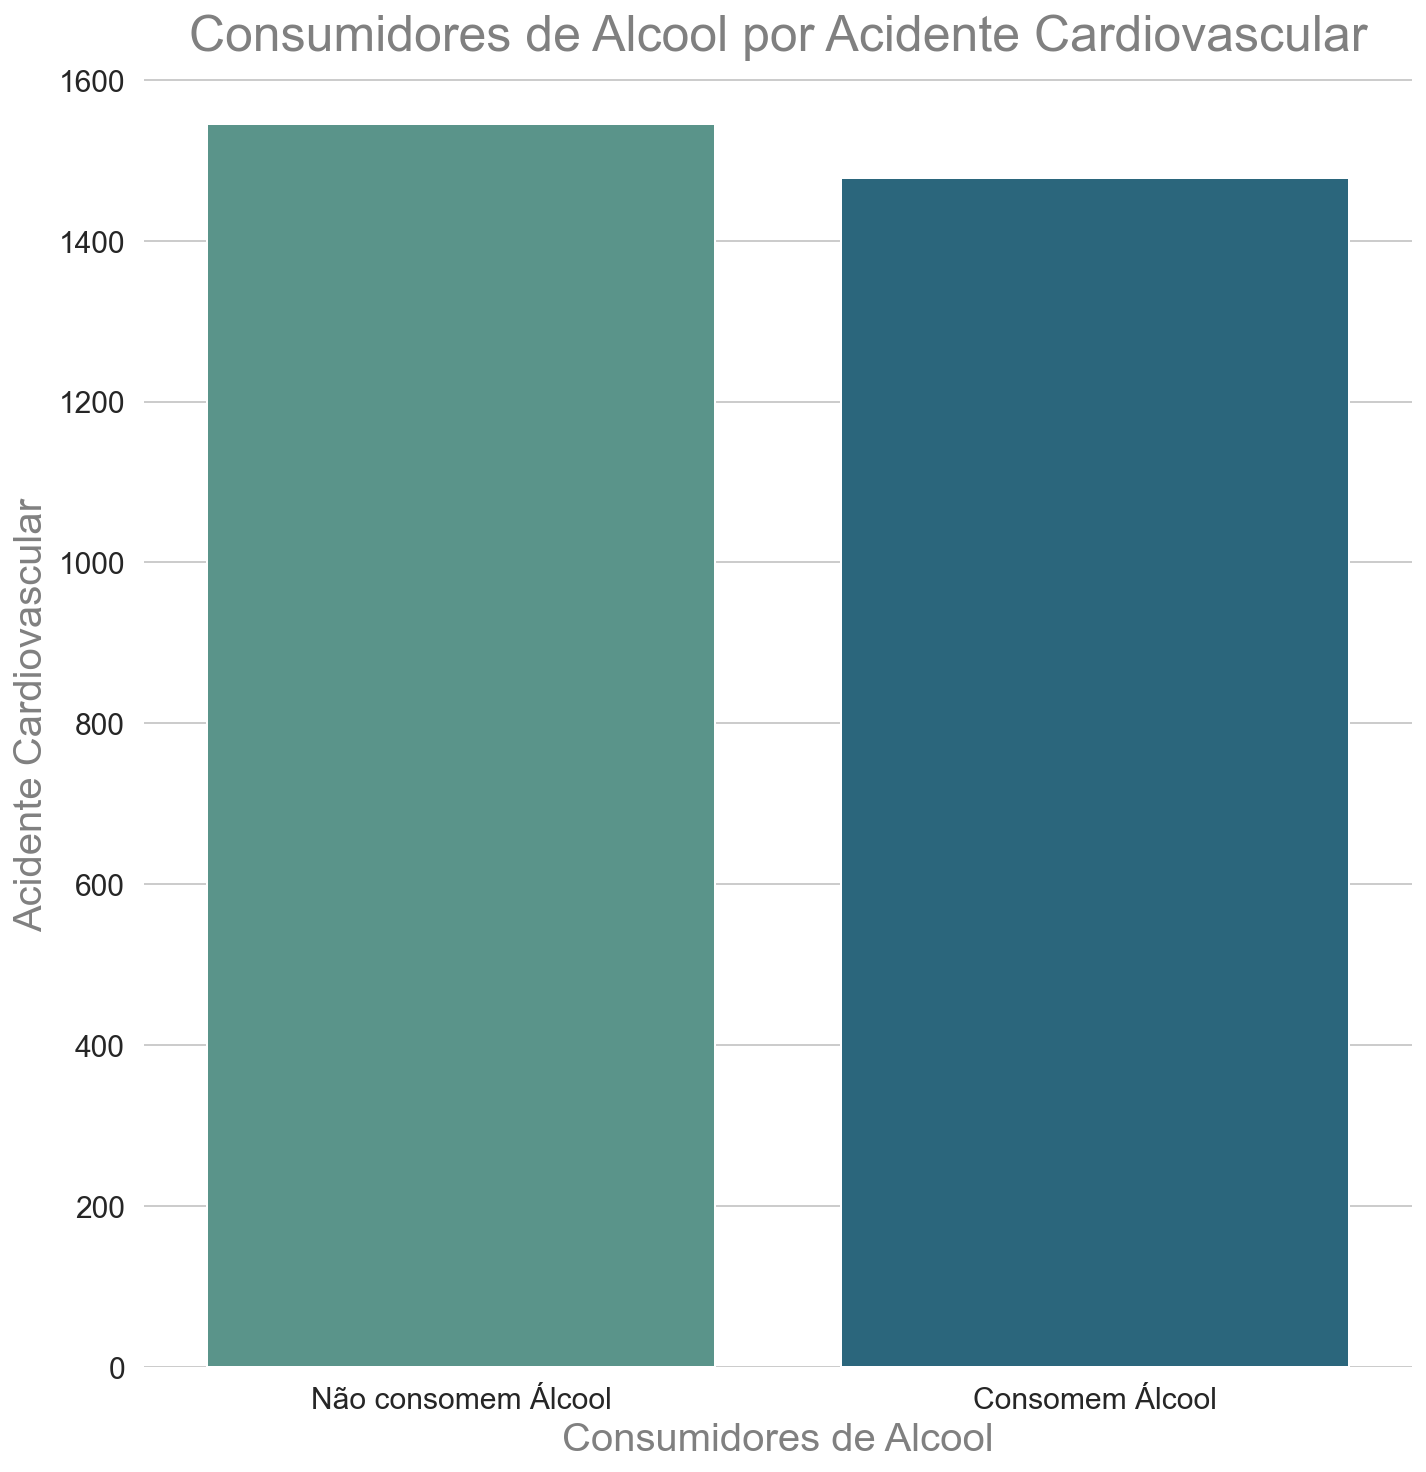

In [77]:
aux1 = df3[df3['alco'] == 0].sample(3000, replace=True)
aux2 = df3[df3['alco'] == 1].sample(3000, replace=True)
aux3 = pd.concat([aux1, aux2])
aux4 = aux3[aux3['cardio']==1][['cardio', 'alco']].groupby(['alco']).sum().reset_index()

plt.subplot(121)
sns.barplot( x = 'alco', y = 'cardio', data = aux4, palette = 'crest' )
sns.despine( bottom = True, left = True)
plt.title( 'Consumidores de Alcool por Acidente Cardiovascular', size = 25, color = 'gray')
plt.xlabel("Consumidores de Alcool", size = 20, color = 'grey')
plt.ylabel("Acidente Cardiovascular", size = 20, color = 'grey')
plt.xticks(np.arange(2), ['Não consomem Álcool', 'Consomem Álcool'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

**Falsa hipótese, mas a diferença é mínima**

### 4.3.9 H9 - Pessoas sedentárias têm mais doenças cardiovasculares

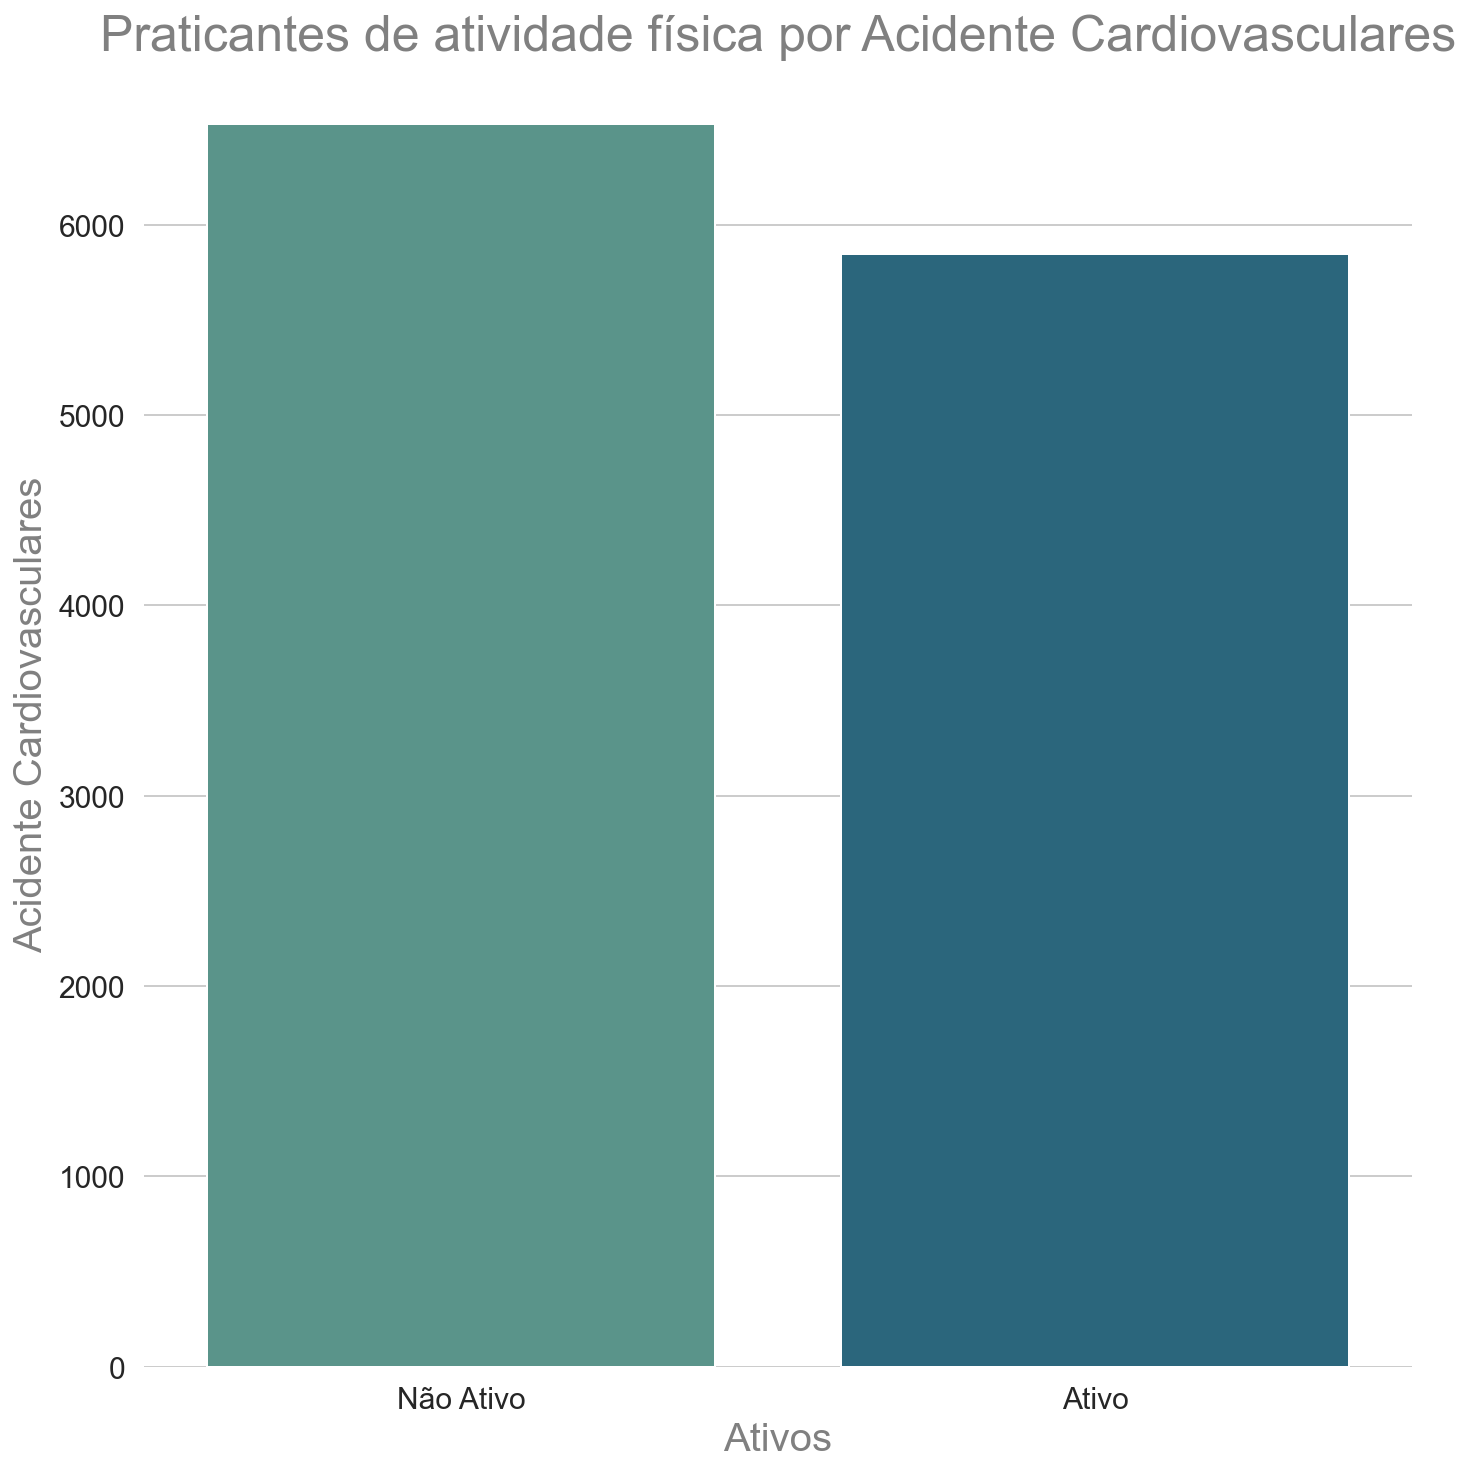

In [78]:
aux1 = df3[df3['active'] == 0].sample(12000, replace=True)
aux2 = df3[df3['active'] == 1].sample(12000, replace=True)
aux3 = pd.concat([aux1, aux2])
aux4 = aux3[aux3['cardio']==1][['cardio', 'active']].groupby(['active']).sum().reset_index()

plt.subplot(121)
sns.barplot( x = 'active', y = 'cardio', data = aux4, palette = 'crest' )
sns.despine( bottom = True, left = True)
plt.title( 'Praticantes de atividade física por Acidente Cardiovasculares', size = 25, color = 'gray')
plt.xlabel("Ativos", size = 20, color = 'grey')
plt.ylabel("Acidente Cardiovasculares", size = 20, color = 'grey')
plt.xticks(np.arange(2), ['Não Ativo', 'Ativo'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

**Falsa hipótese, mas a diferença é mínima**

### 4.3.10 H10 - Pessoas com IMC mais elevado têm mais doenças cardiovasculares

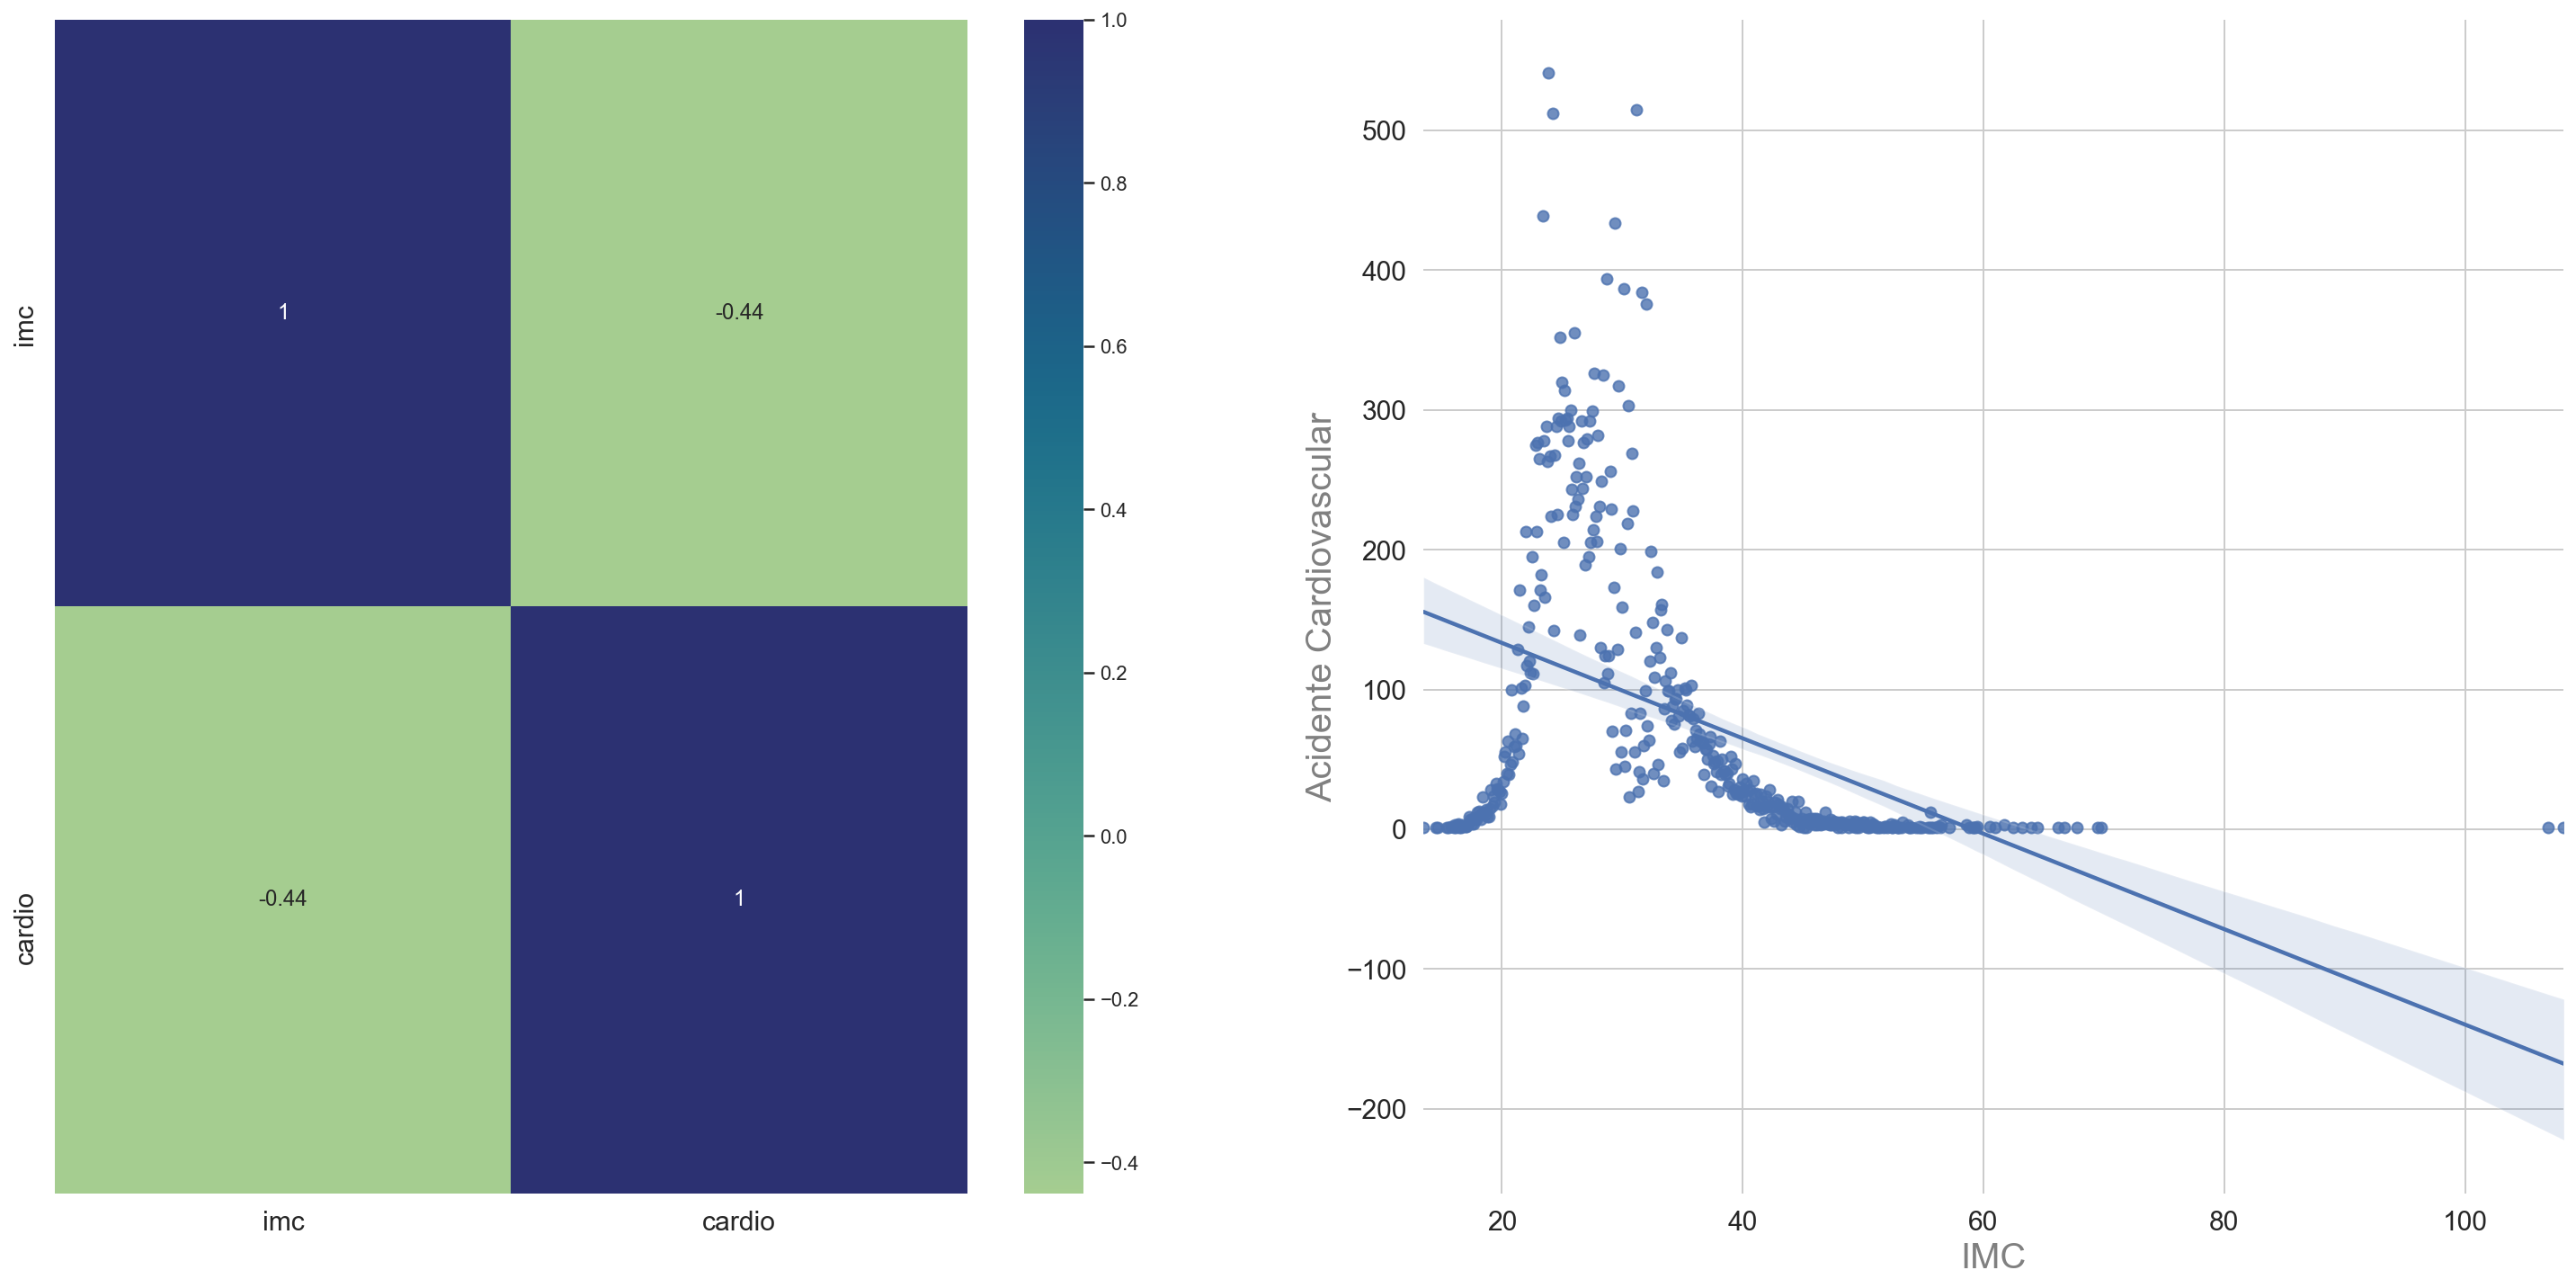

In [79]:
aux = df3[df3['cardio']==1][['cardio', 'imc']].groupby(['imc']).sum().reset_index()
        
plt.subplot(121)
sns.heatmap( aux.corr( method='pearson' ), annot=True, cmap="crest" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.subplot(122)
sns.regplot( x = 'imc', y = 'cardio', data = aux)
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("IMC", size = 20, color = 'grey')
plt.ylabel("Acidente Cardiovascular", size = 20, color = 'grey');

**Falsa hipótese, a correlação é moderada negativa, mas os dados não são lineares**

### 4.3.10 H11 Pessoas com maior escala de risco de doenças cardiovasculares têm mais doenças cardiovasculares

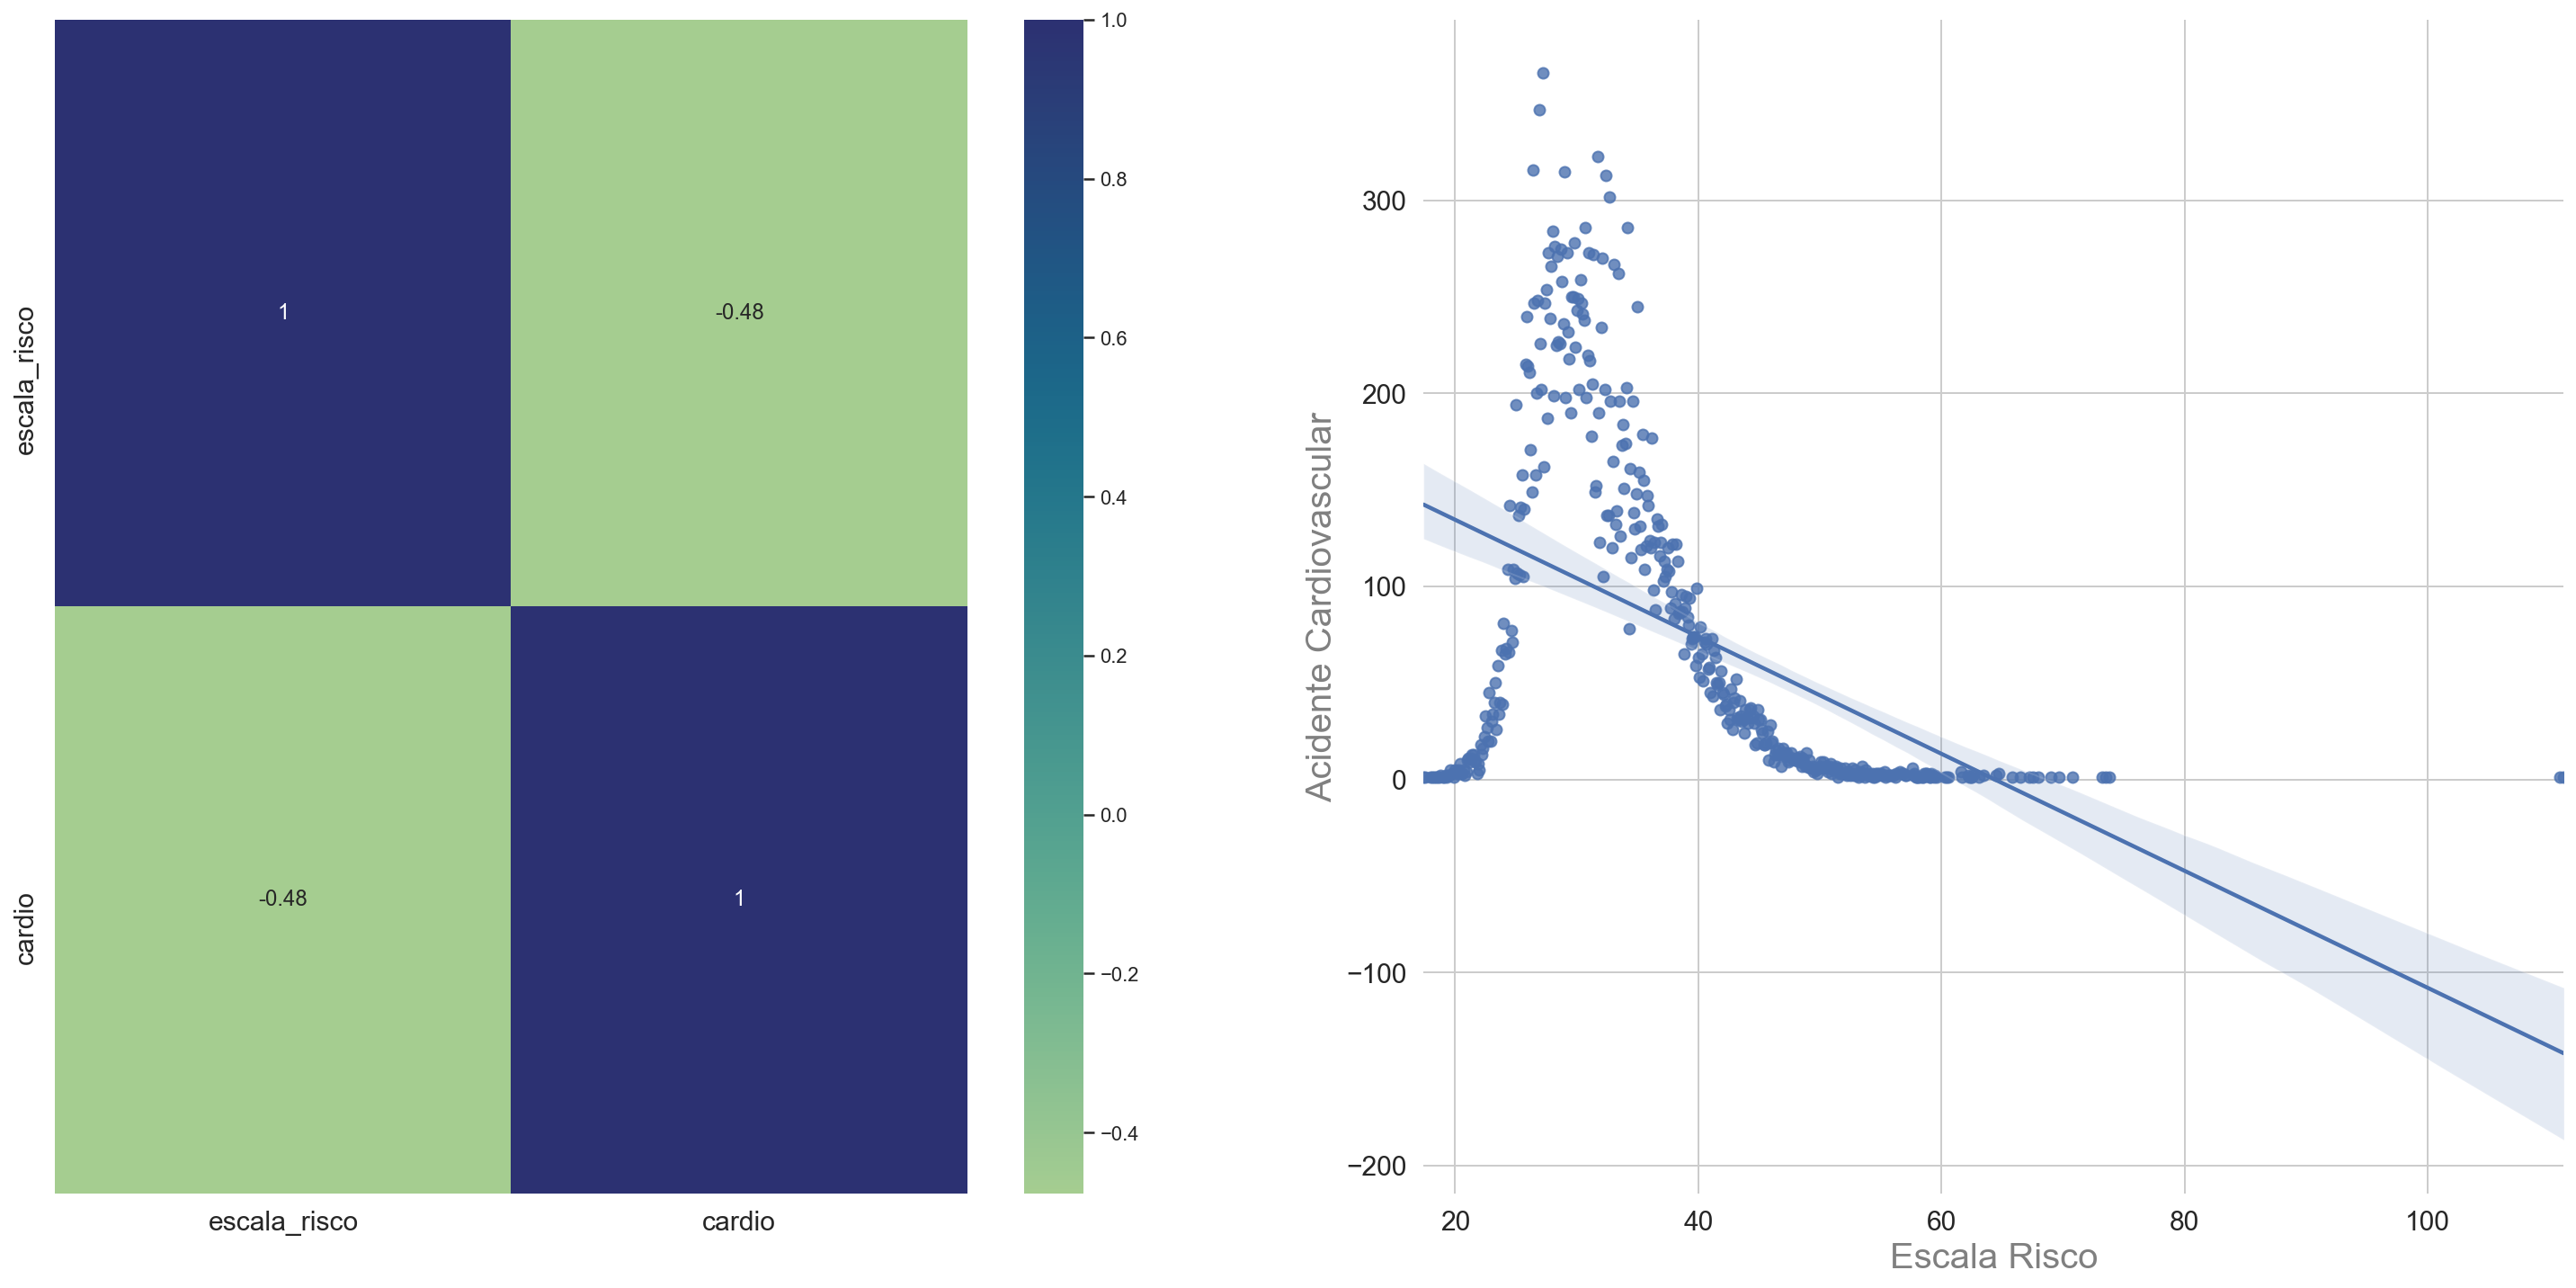

In [80]:
aux = df3[df3['cardio']==1][['cardio', 'escala_risco']].groupby(['escala_risco']).sum().reset_index()
        
plt.subplot(121)
sns.heatmap( aux.corr( method='pearson' ), annot=True, cmap="crest" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.subplot(122)
sns.regplot( x = 'escala_risco', y = 'cardio', data = aux)
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Escala Risco", size = 20, color = 'grey')
plt.ylabel("Acidente Cardiovascular", size = 20, color = 'grey');

**Falsa hipótese, a correlação é moderada negativa, mas os dados não são lineares**

## 4.3 Análise multivariada

### 4.3.1 Correlação entre Variáveis Numéricas

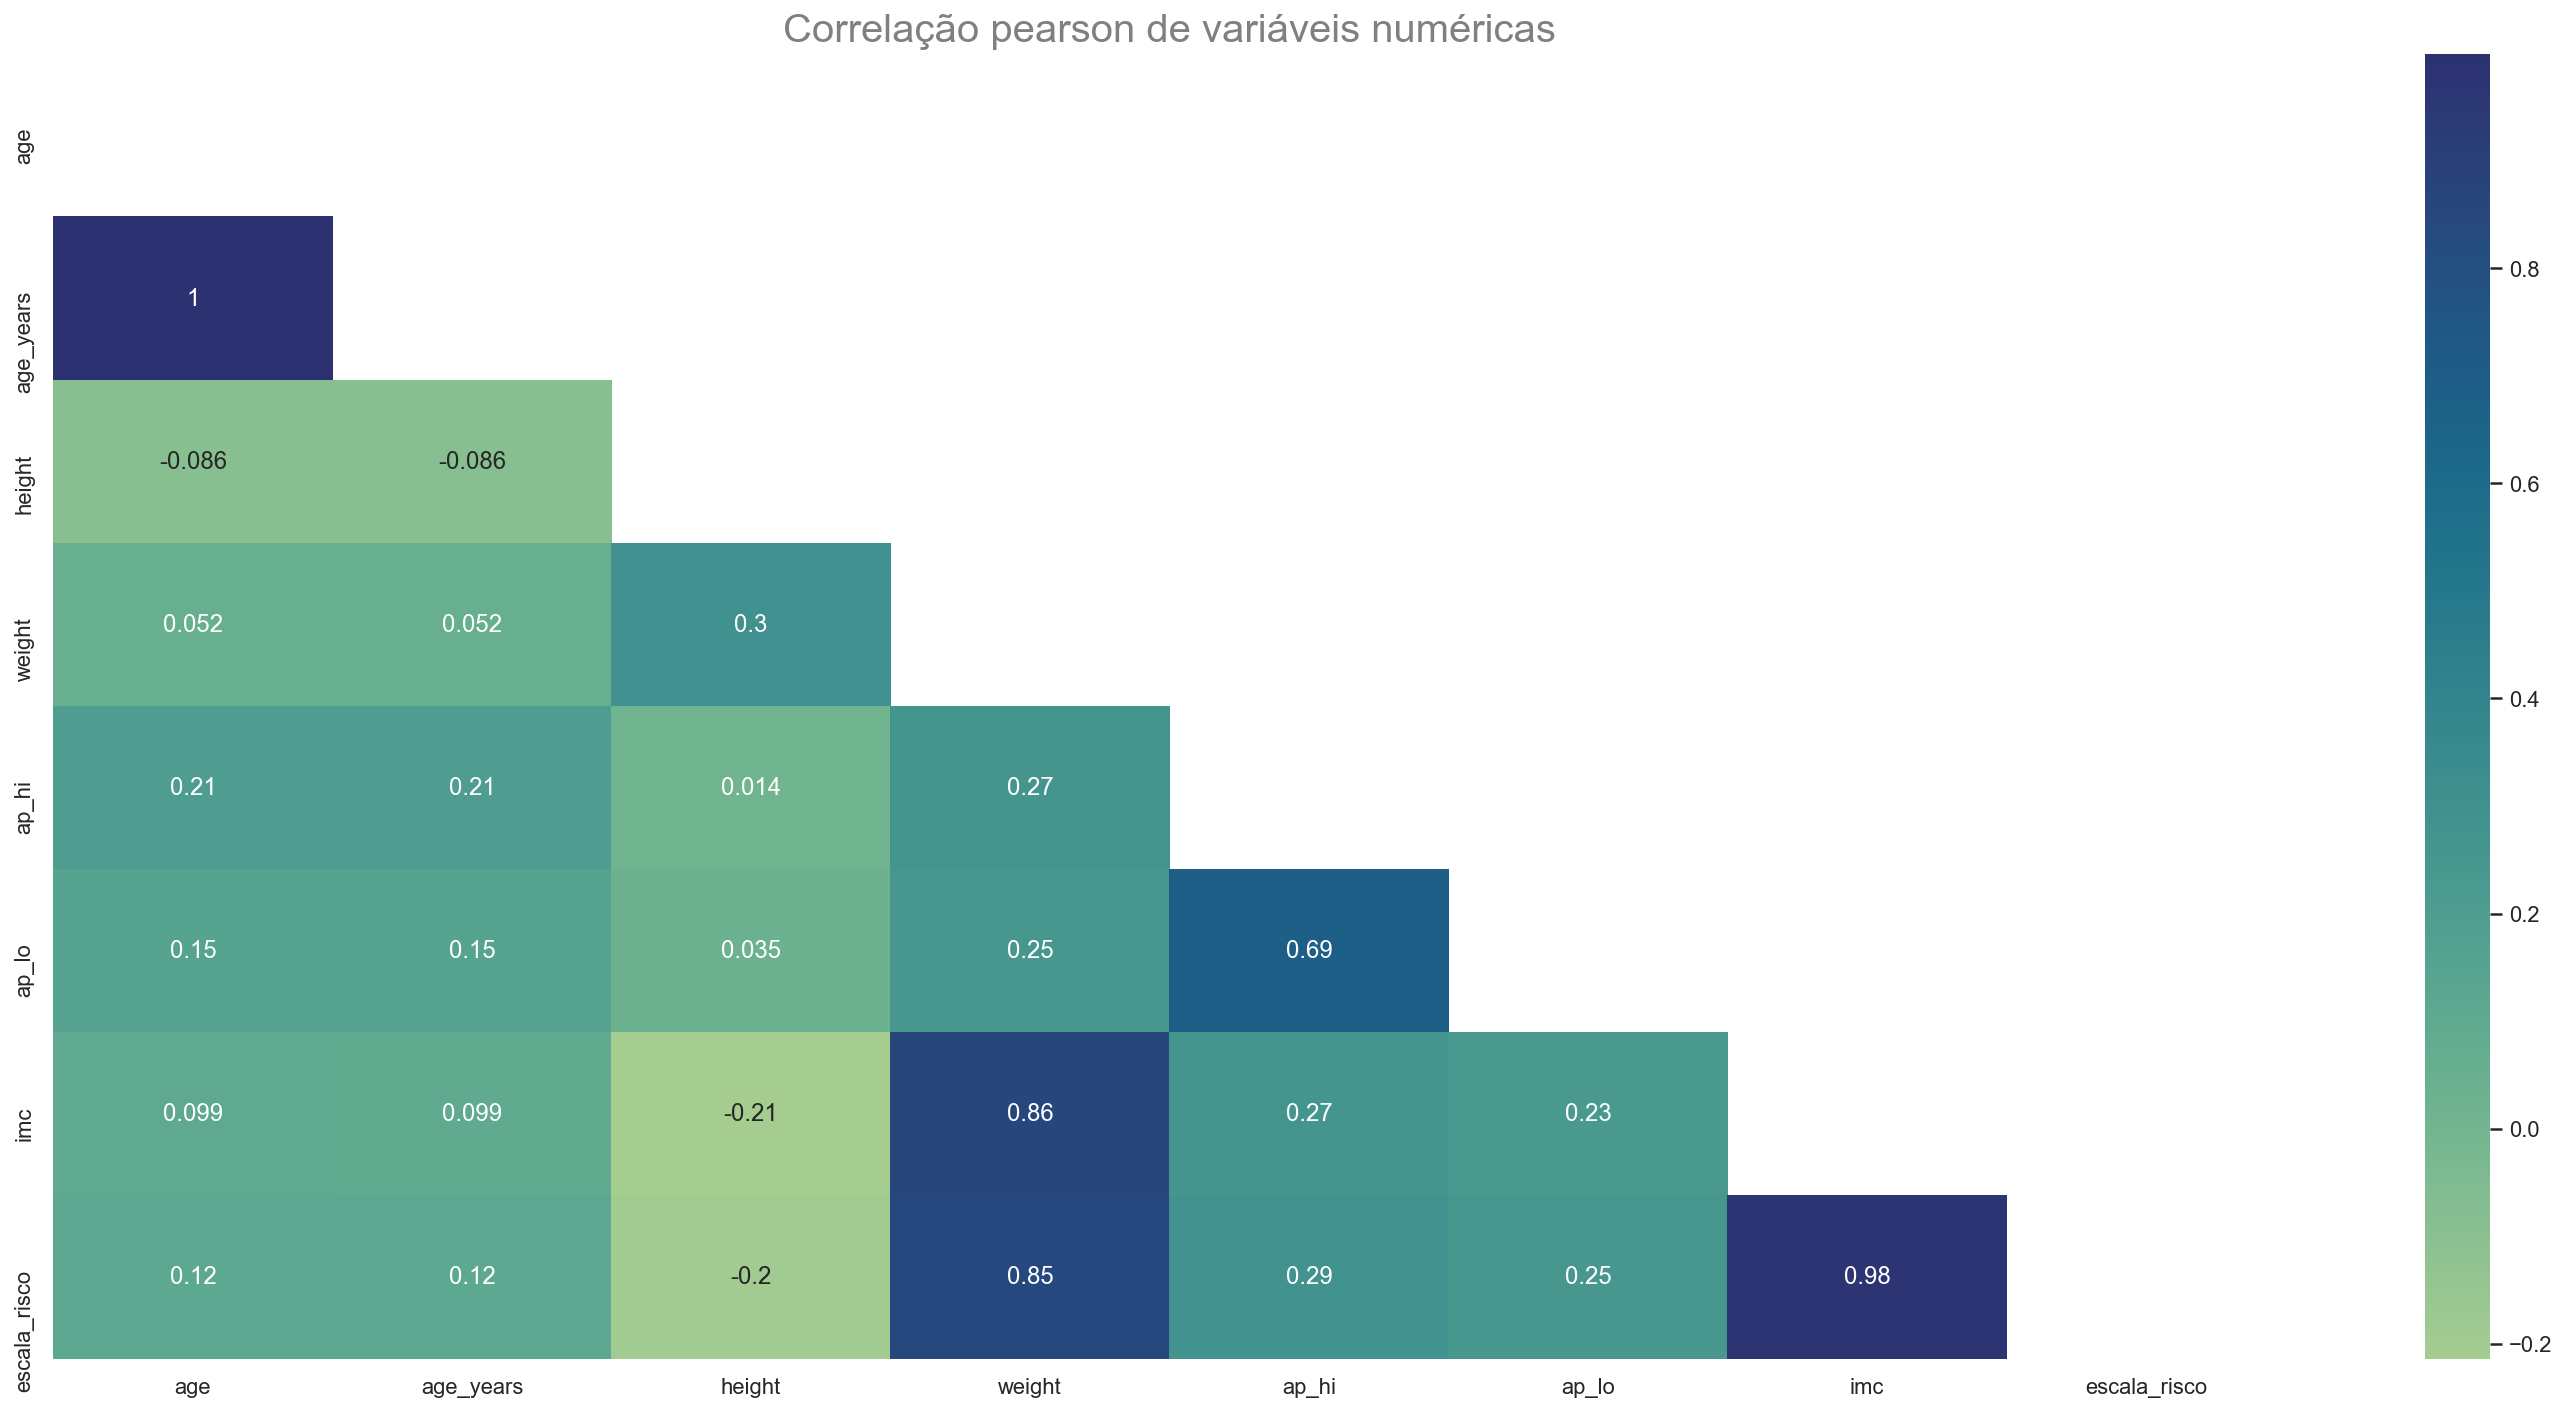

In [81]:
# Pearson Correlation
corr = num_var.corr( method = 'pearson' )

# Creating a with mask for the superior triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    # Creating the chart with mask
    ax = sns.heatmap(corr, mask=mask, annot = True, cmap = 'crest')
    plt.title("Correlação pearson de variáveis numéricas", size=20, color='gray');

**Pontos Chaves:**

As correlações positivas mais fortes estão entre:

imc x escala_risco (0.98),                                                                        
peso x imc (0.86)                                                                                                            
peso x escala_risco (0.85)                                                                                                     
ap_hi x ap_lo (0.69).                                                                                                           

### 4.3.2 Correlação entre Variáveis Numéricas e Binárias

In [82]:
num_var.columns

Index(['age', 'age_years', 'height', 'weight', 'ap_hi', 'ap_lo', 'imc',
       'escala_risco'],
      dtype='object')

In [83]:
bin_var.columns

Index(['gender', 'smoke', 'alco', 'active'], dtype='object')

In [84]:
#  Todas combinações possiveis.
x0 = pointbiserialr(bin_var['gender'], num_var['age_years'])[0]
x1 = pointbiserialr(bin_var['gender'], num_var['age'])[0]
x2 = pointbiserialr(bin_var['gender'], num_var['height'])[0]
x3 = pointbiserialr(bin_var['gender'], num_var['weight'])[0]
x4 = pointbiserialr(bin_var['gender'], num_var['ap_hi'])[0]
x5 = pointbiserialr(bin_var['gender'], num_var['ap_lo'])[0]
x6 = pointbiserialr(bin_var['gender'], num_var['imc'])[0]
x7 = pointbiserialr(bin_var['gender'], num_var['escala_risco'])[0]


x08 = pointbiserialr(bin_var['smoke'], num_var['age_years'])[0]
x8 = pointbiserialr(bin_var['smoke'], num_var['age'])[0]
x9 = pointbiserialr(bin_var['smoke'], num_var['height'])[0]
x10 = pointbiserialr(bin_var['smoke'], num_var['weight'])[0]
x11 = pointbiserialr(bin_var['smoke'], num_var['ap_hi'])[0]
x12 = pointbiserialr(bin_var['smoke'], num_var['ap_lo'])[0]
x13 = pointbiserialr(bin_var['smoke'], num_var['imc'])[0]
x14 = pointbiserialr(bin_var['smoke'], num_var['escala_risco'])[0]

x015 = pointbiserialr(bin_var['alco'], num_var['age_years'])[0]
x15 = pointbiserialr(bin_var['alco'], num_var['age'])[0]
x16 = pointbiserialr(bin_var['alco'], num_var['height'])[0]
x17 = pointbiserialr(bin_var['alco'], num_var['weight'])[0]
x18 = pointbiserialr(bin_var['alco'], num_var['ap_hi'])[0]
x19 = pointbiserialr(bin_var['alco'], num_var['ap_lo'])[0]
x20 = pointbiserialr(bin_var['alco'], num_var['imc'])[0]
x21 = pointbiserialr(bin_var['alco'], num_var['escala_risco'])[0]

x022 = pointbiserialr(bin_var['active'], num_var['age_years'])[0]
x22 = pointbiserialr(bin_var['active'], num_var['age'])[0]
x23 = pointbiserialr(bin_var['active'], num_var['height'])[0]
x24 = pointbiserialr(bin_var['active'], num_var['weight'])[0]
x25 = pointbiserialr(bin_var['active'], num_var['ap_hi'])[0]
x26 = pointbiserialr(bin_var['active'], num_var['ap_lo'])[0]
x27 = pointbiserialr(bin_var['active'], num_var['imc'])[0]
x28 = pointbiserialr(bin_var['active'], num_var['escala_risco'])[0]

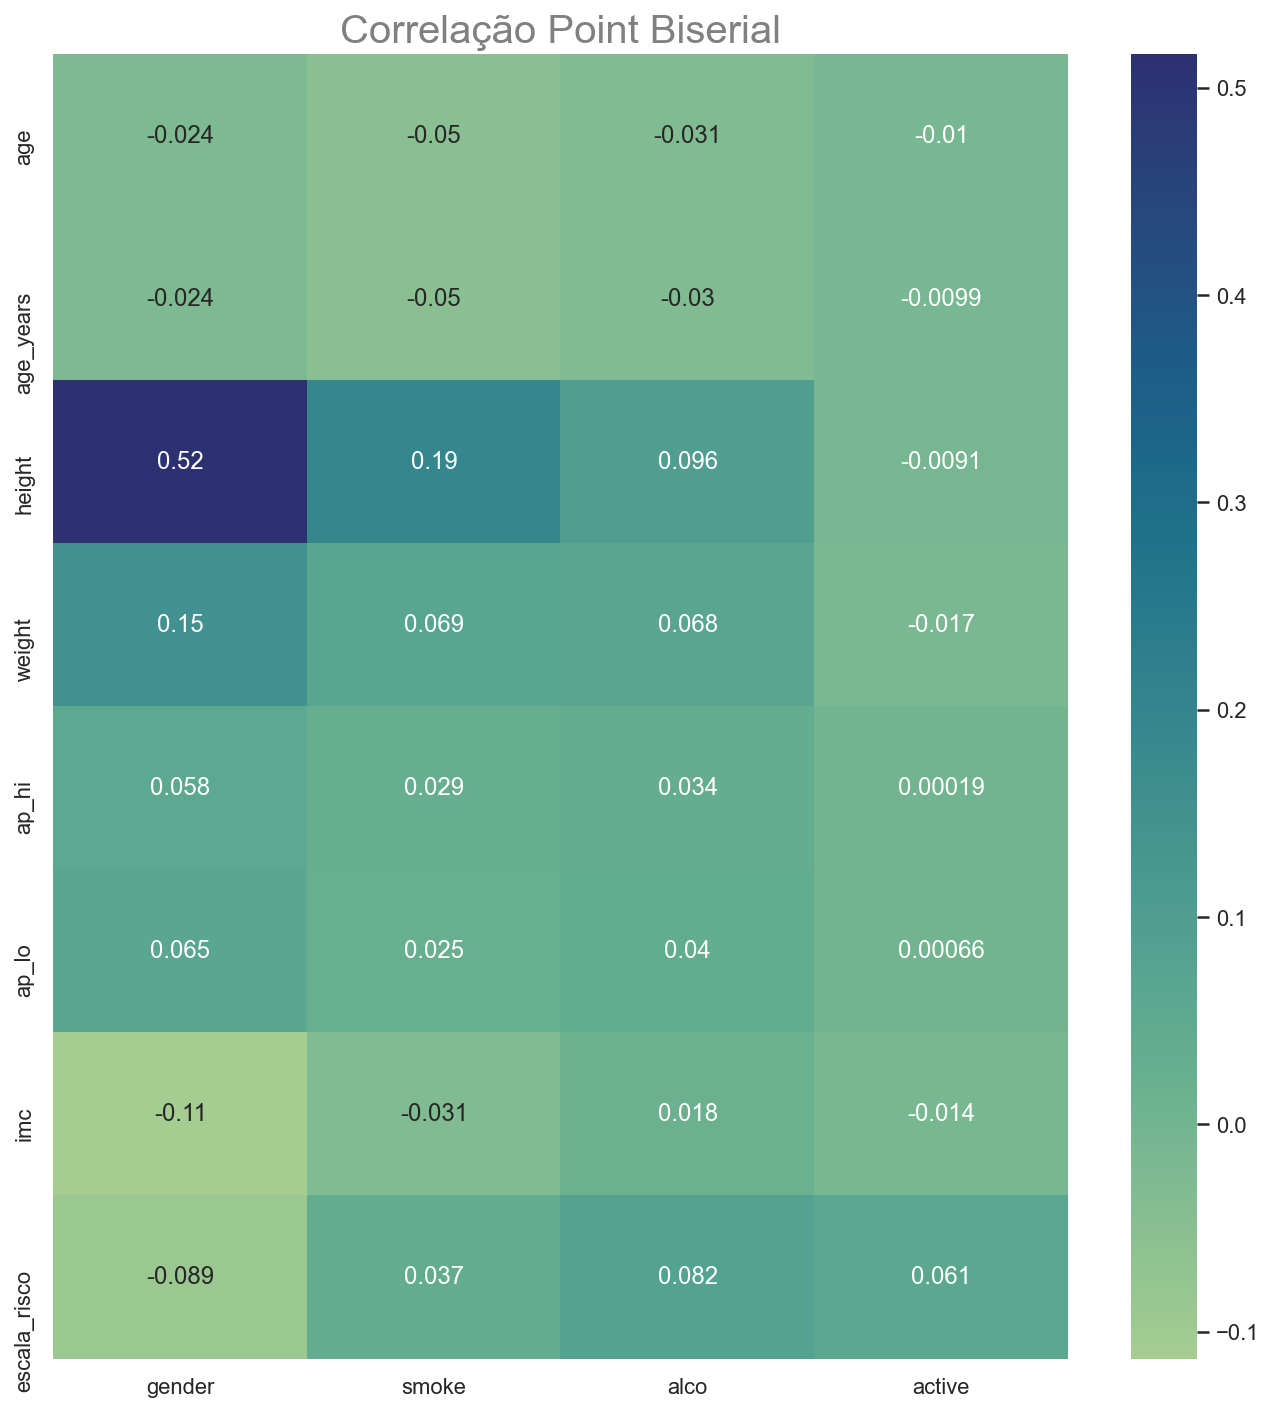

In [85]:
# Criando um DataFrame
dfx = pd.DataFrame({'gender':[x0, x1, x2, x3, x4, x5, x6, x7],
                    'smoke': [x08, x8, x9, x10, x11, x12, x13, x14],
                    'alco':  [x015, x15, x16, x17, x18, x19, x20, x21],
                    'active':[x022, x22, x23, x24, x25, x26, x27, x28]})

# Sets the index equal to columns
dfx = dfx.set_index(num_var.columns)

# Heatmap
plt.subplot(121)
sns.heatmap(dfx, annot=True, annot_kws={"fontsize":12}, cmap='crest')
plt.title("Correlação Point Biserial", size=20, color='gray');

**A única correlação moderada positiva é betwenn gênero x altura (0,52)**

### 4.3.3 Correlação entre Variáveis Categóricas

#### 4.3.3.1 Colesterol

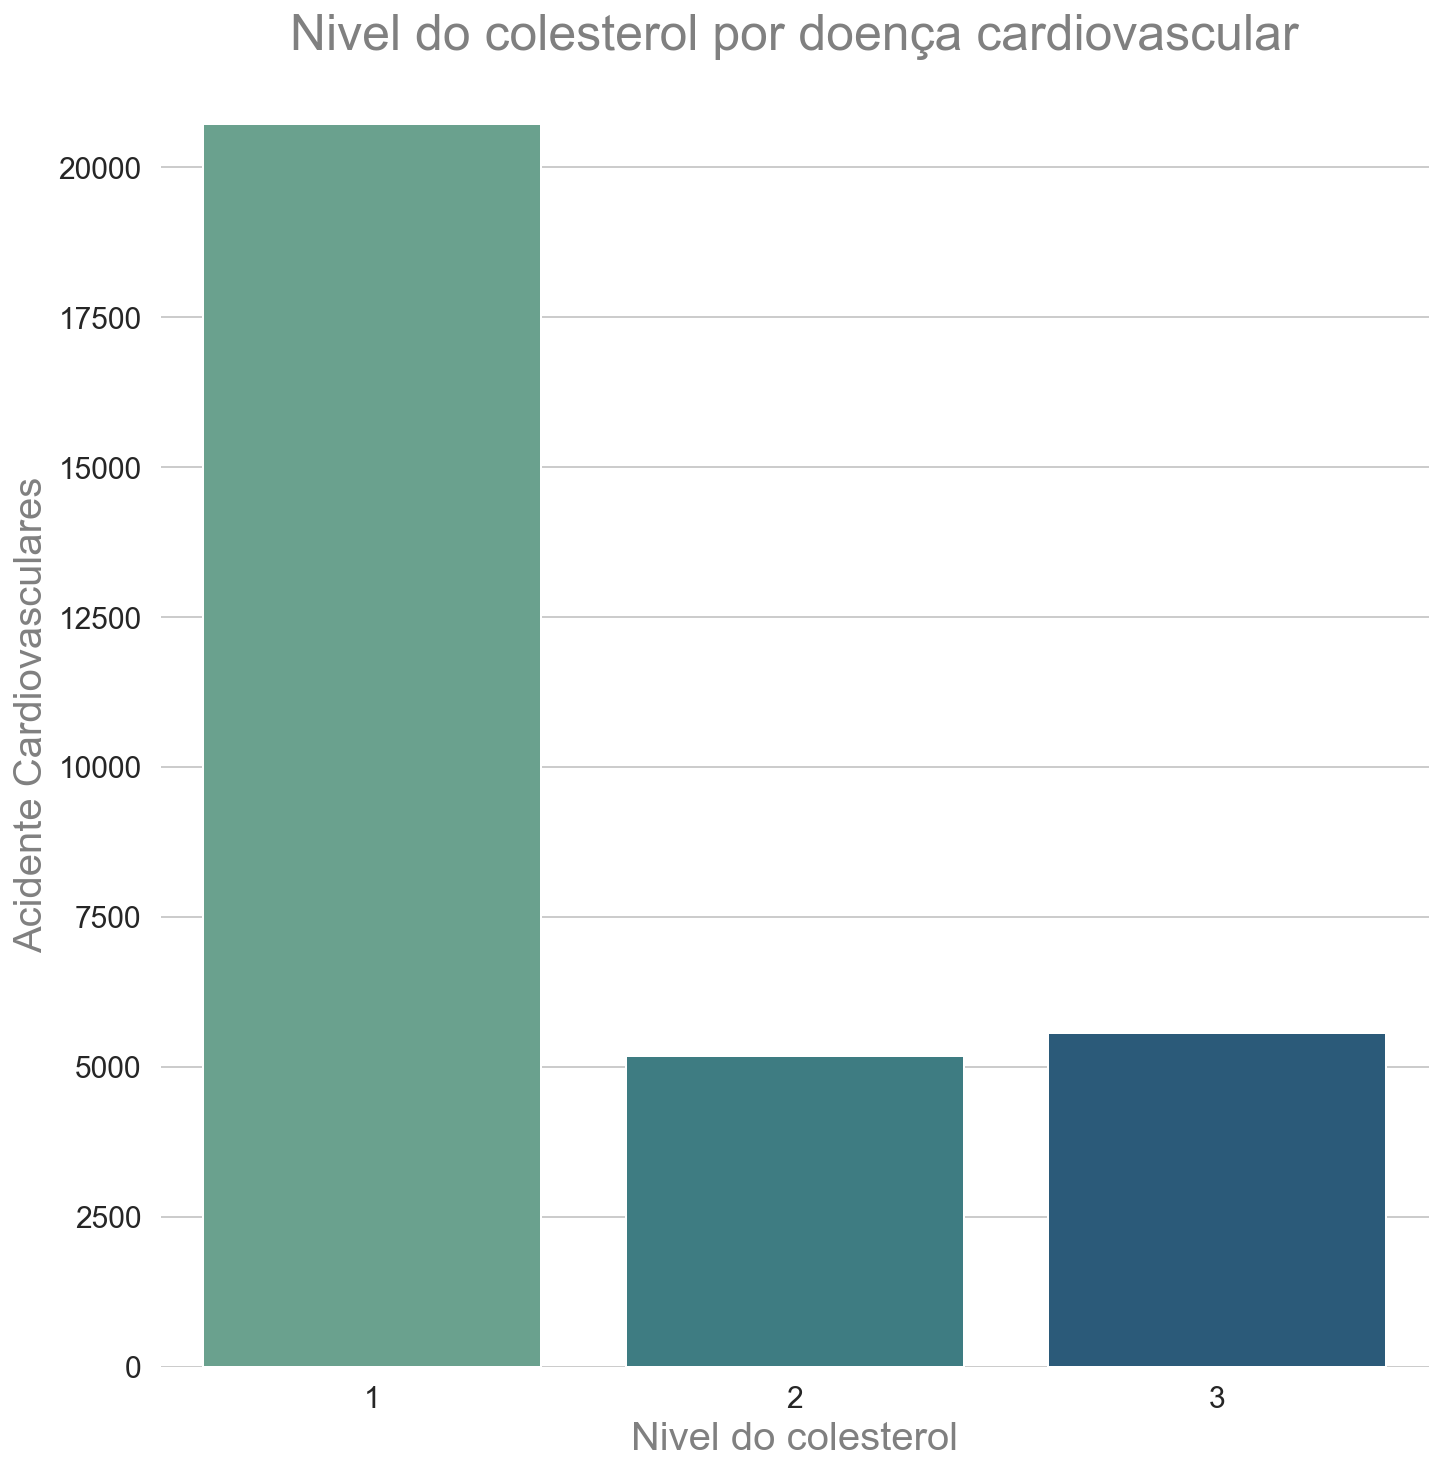

In [86]:
aux = df3[df3['cardio']==1][['cardio', 'cholesterol']].groupby(['cholesterol']).sum().reset_index()
plt.subplot(121)
sns.barplot( x = 'cholesterol', y = 'cardio', data = aux, palette = 'crest' )
sns.despine( bottom = True, left = True)
plt.title( 'Nivel do colesterol por doença cardiovascular', size = 25, color = 'gray')
plt.xlabel("Nivel do colesterol", size = 20, color = 'grey')
plt.ylabel("Acidente Cardiovasculares", size = 20, color = 'grey')
plt.xticks(np.arange(3), ['1', '2', '3'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

In [87]:
cholesterol = cat_var['cholesterol'].value_counts().tolist()
porcen = list()
cholesterol_cardio = aux['cardio'].tolist()
porcen.append("{:.2f}".format(aux['cardio'][0]/cholesterol[0]))
porcen.append("{:.2f}".format(aux['cardio'][1]/cholesterol[1]))
porcen.append("{:.2f}".format(aux['cardio'][2]/cholesterol[2]))
porcen
porcentagem = pd.DataFrame(np.array([cholesterol,cholesterol_cardio,porcen]),
                           columns=['colesterol-1','colesterol-2','colesterol-3'],
                           index=(["Total", "Com Acidente Cardiovascular", "Pocentagem %"]))
porcentagem

colesterol-1 colesterol-2 colesterol-3
Total                              47128         8614         7258
Com Acidente Cardiovascular        20724         5175         5558
Pocentagem %                        0.44         0.60         0.77

Assim, é possível observar que apesar de o colesterol ter menos quantidade de pessoas no nível 3, 77% desse grupo possuem acidentes cardiovasculares.

#### 4.3.3.2 Glicose

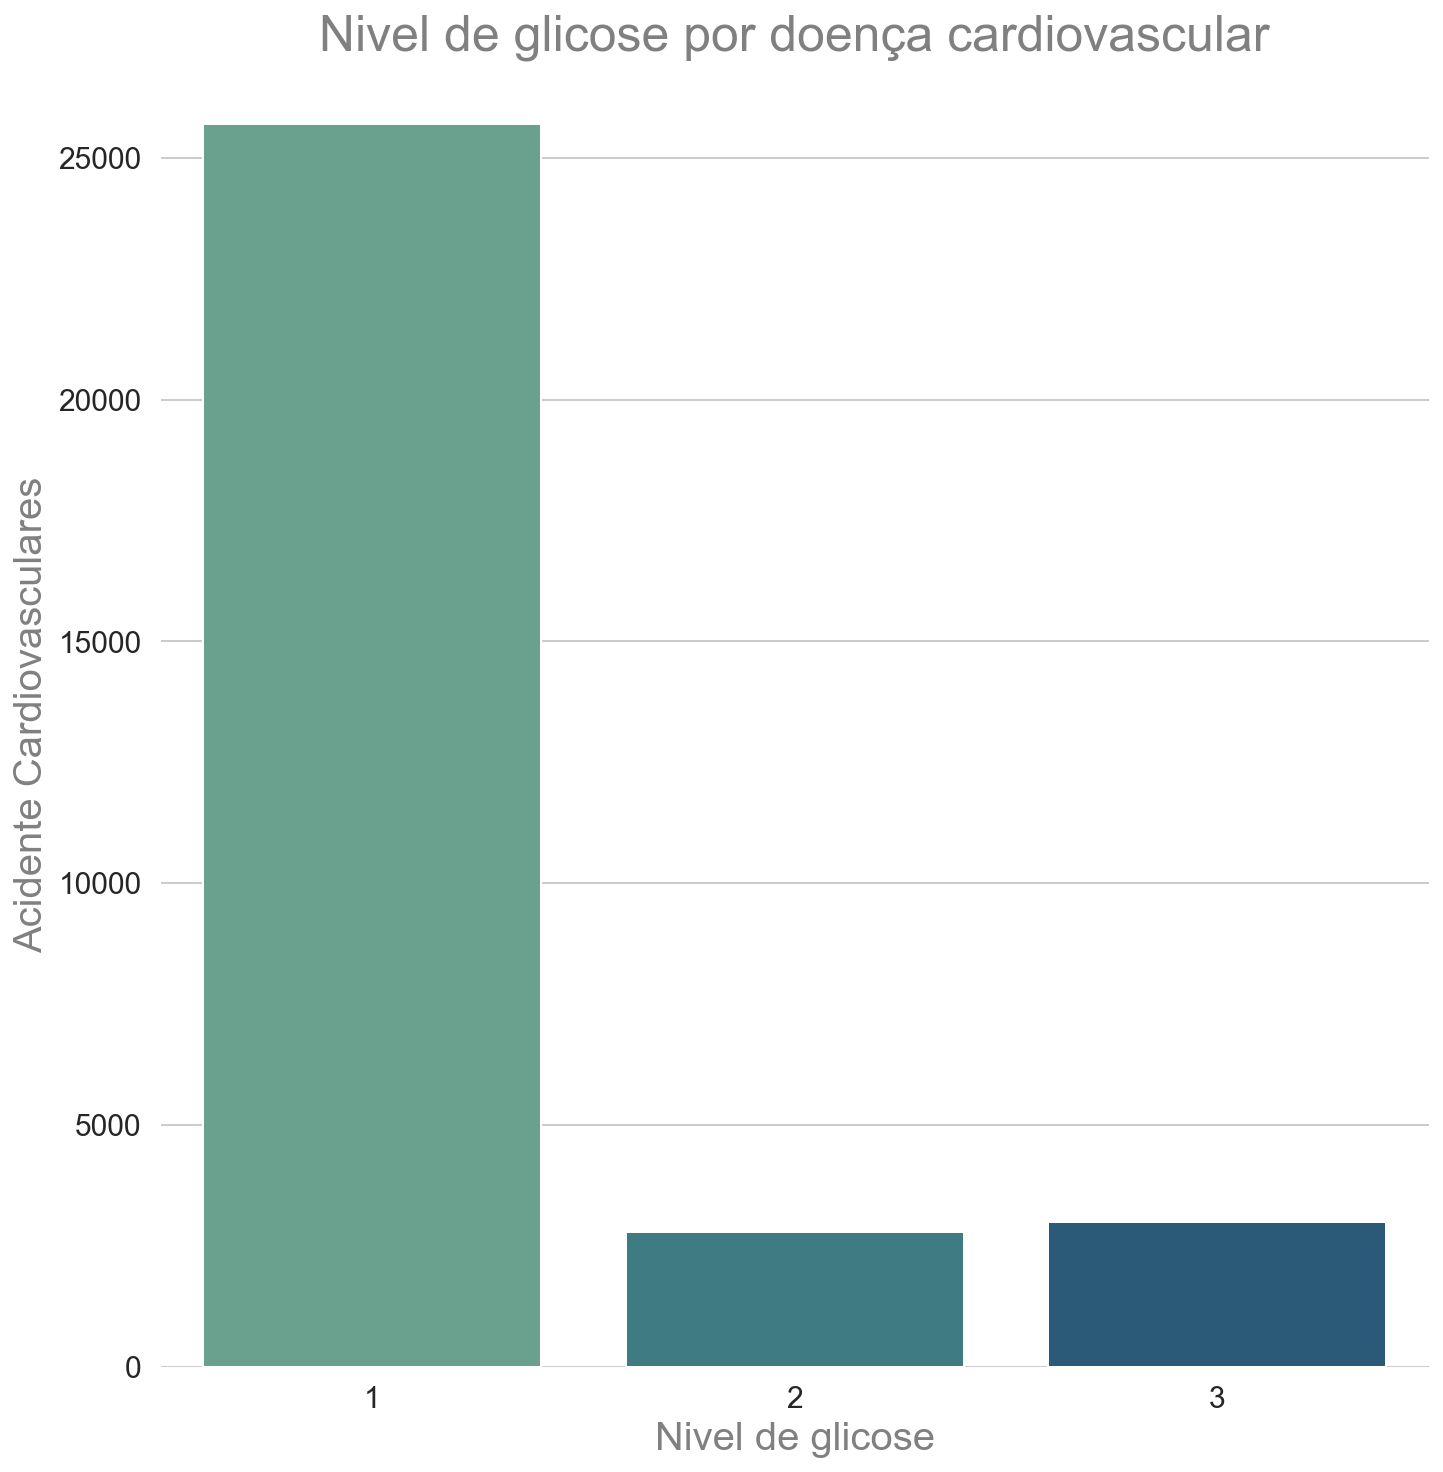

In [88]:
aux = df3[df3['cardio']==1][['cardio', 'gluc']].groupby(['gluc']).sum().reset_index()
plt.subplot(121)
sns.barplot( x = 'gluc', y = 'cardio', data = aux, palette = 'crest' )
sns.despine( bottom = True, left = True)
plt.title( 'Nivel de glicose por doença cardiovascular', size = 25, color = 'gray')
plt.xlabel("Nivel de glicose", size = 20, color = 'grey')
plt.ylabel("Acidente Cardiovasculares", size = 20, color = 'grey')
plt.xticks(np.arange(3), ['1', '2', '3'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

In [89]:
glicose = cat_var['gluc'].value_counts().tolist()
porcen = list()
porcen.append("{:.2f}".format(aux['cardio'][0]/glicose[0]))
porcen.append("{:.2f}".format(aux['cardio'][1]/glicose[1]))
porcen.append("{:.2f}".format(aux['cardio'][2]/glicose[2]))
porcen
porcentagem = pd.DataFrame(np.array([cholesterol,cholesterol_cardio,porcen]),
                           columns=['glicose-1','glicose-2','glicose-3'],
                           index=(["Total", "Com Acidente Cardiovascular", "Pocentagem %"]))
porcentagem

glicose-1 glicose-2 glicose-3
Total                           47128      8614      7258
Com Acidente Cardiovascular     20724      5175      5558
Pocentagem %                     0.48      0.58      0.64

Assim, é possível observar que apesar de o glicose ter menos quantidade de pessoas no nível 3, 64% desse grupo possuem acidentes cardiovasculares.

#### 4.3.3.3 Pressão Arterial

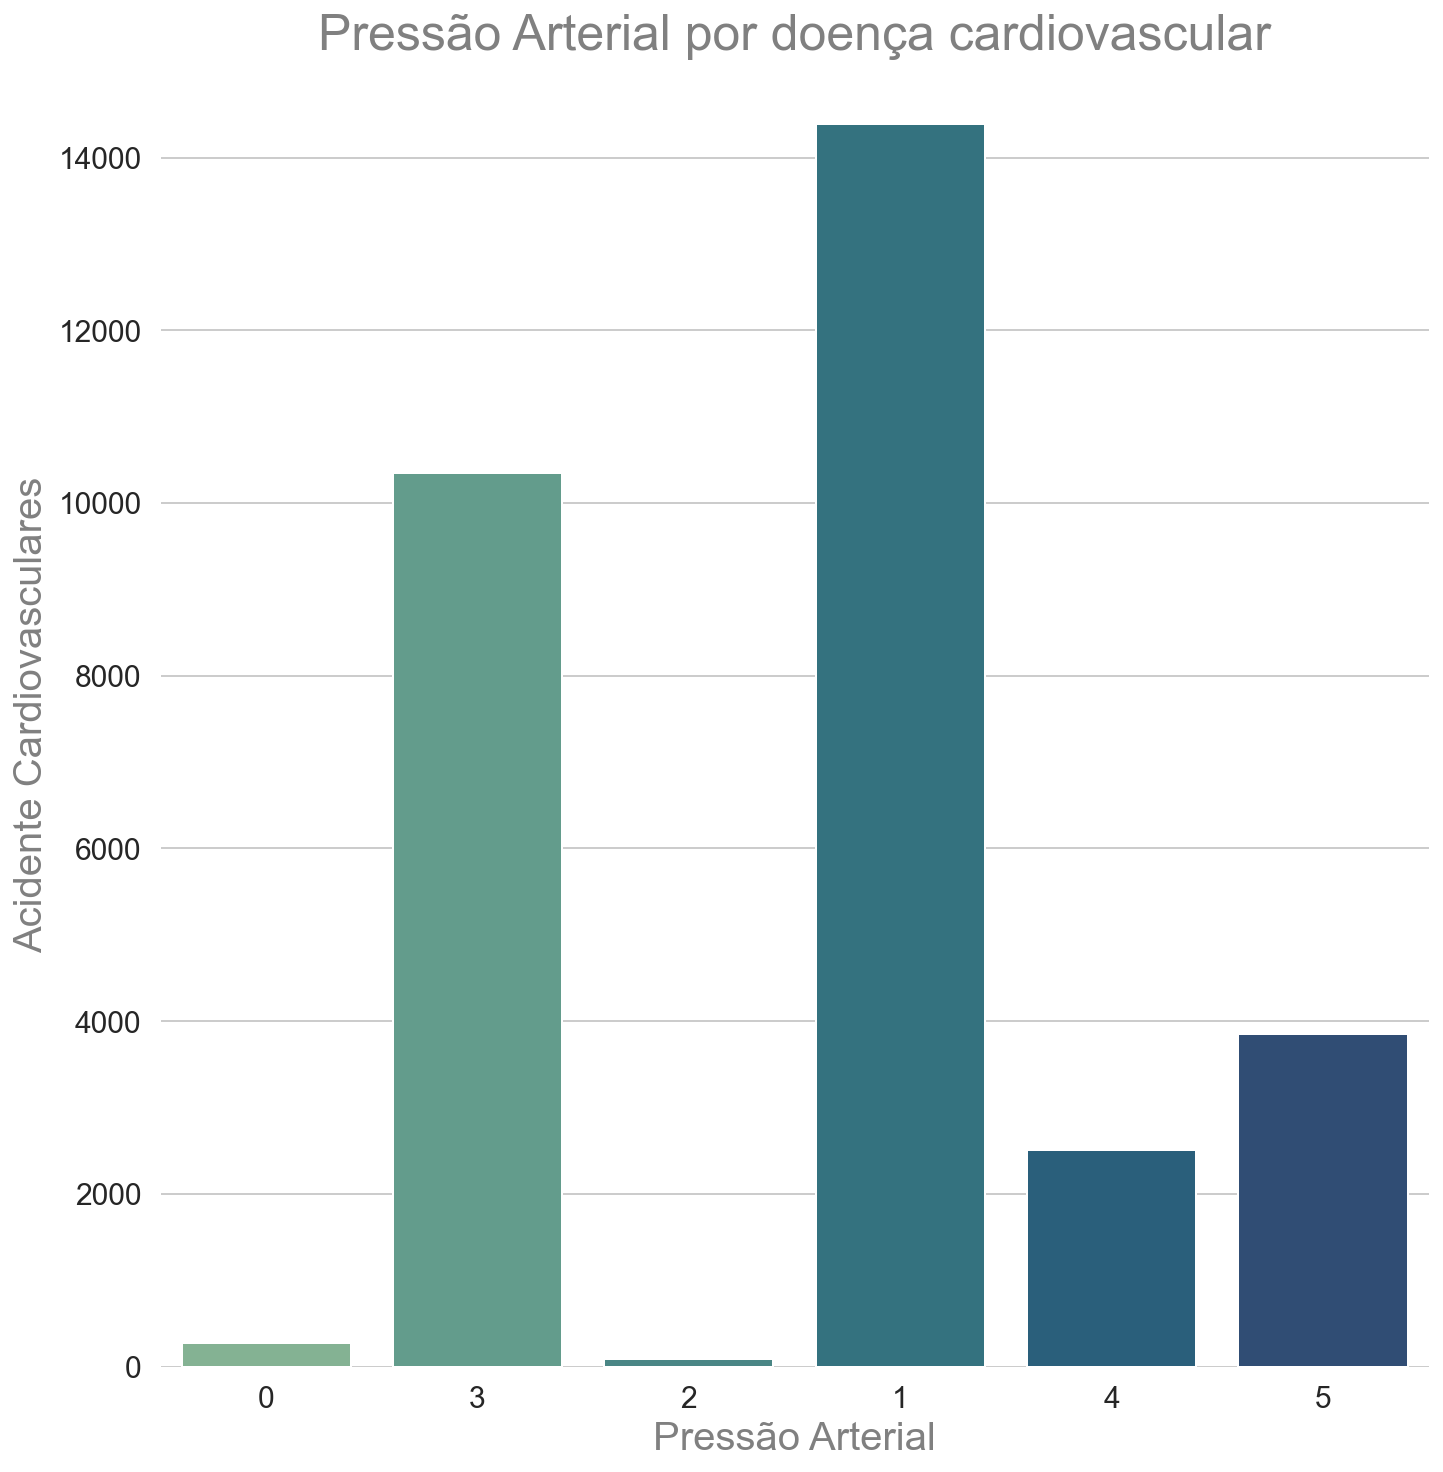

In [90]:
aux = df3[df3['cardio']==1][['cardio', 'pressão_arterial']].groupby(['pressão_arterial']).sum().reset_index()
plt.subplot(121)
sns.barplot( x = 'pressão_arterial', y = 'cardio', data = aux, palette = 'crest' )
sns.despine( bottom = True, left = True)
plt.title( 'Pressão Arterial por doença cardiovascular', size = 25, color = 'gray')
plt.xlabel("Pressão Arterial", size = 20, color = 'grey')
plt.ylabel("Acidente Cardiovasculares", size = 20, color = 'grey')
plt.xticks(np.arange(6), ['0','3','2','1','4','5'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

# 5.0 Data preparation

In [91]:
df4 = df3.copy()

# Salvar o id para ser usado depois
df_id = df4['id']

# Drop colunas sem utilidade
df4.drop(['id','age_years'],axis=1, inplace=True)


In [92]:
df4.sample()

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active  cardio     imc imc_status  imc_diff  pressão_arterial pressão_arterial_status  escala_risco
52259  21174       2     176     132    140     90            3     1      0     0       0       1 42.6000  obeso g-3   20.9000                 3           hipertenção_1       46.6000

## 5.1 Configurar atributos para pré-processamento - Incluir nenhuma engenharia de recursos

 Há uma necessidade de reeesclaing dados porque eles variam muito. Foi escolhido um Min Max Scaler.

In [93]:
# define categorias de string para gênero

df4['gender'] = df4['gender'].apply(lambda x: 'A' if x == 1 else 'B')

## 5.2 Dividir dados definidos em trem e teste

In [94]:
# Separar data
X = df4.drop(['cardio'], axis=1).copy()
y = df4[['cardio']].copy()

In [95]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED, stratify=y)

## 5.3 Dimensionamento de vars numéricas

 Precisamos dimensionar os dados porque a gama de variáveis varia muito dentro deles, para que possamos tratar cada característica igualmente quando o modelo os ingere.

In [96]:
# separa os vars que serão dimensionados
train_vars_to_scale = X_train[['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'imc', 'imc_diff','escala_risco']]
test_vars_to_scale = X_test[['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'imc', 'imc_diff','escala_risco']]

In [97]:
# instancia o scaler
mms_scaler = MinMaxScaler()

In [98]:
# scalar os dados
mms_scaler.fit(train_vars_to_scale)
train_numerical_scaled = mms_scaler.transform(train_vars_to_scale)
test_numerical_scaled = mms_scaler.transform(test_vars_to_scale)

# Salvar no pickle
pickle.dump( mms_scaler, open('parametros/encoding_vars_numericas_train.pkl','wb'))

pickle.dump( mms_scaler, open('parametros/encoding_vars_numericas_test.pkl','wb'))

In [99]:
# converte dados dimensionados em DataFrame para melhor legibilidade
train_numerical_scaled = pd.DataFrame(train_numerical_scaled, columns=train_vars_to_scale.columns)
test_numerical_scaled = pd.DataFrame(test_numerical_scaled, columns=test_vars_to_scale.columns)

## 5.4 Transformation

### 5.4.1 Encoding de dados categoricos

Uma vez que as novas colunas tenham sido criadas usando One-Hot Encoding, podemos concatelá-las com as colunas numéricas para criar um novo quadro de dados que será usado durante todo o resto do projeto para prever as probabilidades.

Lembre-se que o One Hot Encoding é usado apenas em colunas não numéricas. Fazer isso com as colunas numéricas criaria um conjunto de dados incrivelmente amplo.

Precisamos codificar os gêneros (A,B) porque nenhum gênero é mais importante que o outro. Como só temos dois valores para o gênero, podemos codificar os valores com 0s e 1s.

In [100]:
# recebe vars categóricos
train_categorical_vars = X_train[['gender']]
test_categorical_vars = X_test[['gender']]

# Resetar o Index
train_categorical_vars.reset_index(drop=True, inplace=True)
test_categorical_vars.reset_index(drop=True, inplace=True)

# one hot encoding
train_categorical_encoded = pd.get_dummies(train_categorical_vars, drop_first=True)
test_categorical_encoded = pd.get_dummies(test_categorical_vars, drop_first=True)

In [101]:
# Como os vars binários já estão codificados como 1s e 0s, não há necessidade de fazer o One Hot Encoding
train_binary_vars = X_train[['smoke','alco','active']]
test_binary_vars = X_test[['smoke','alco','active']]


# Resetar o index
train_binary_vars.reset_index(drop=True, inplace=True)
test_binary_vars.reset_index(drop=True, inplace=True)



###  5.4.2 Atributos categóricos de codificação de frequência - Conjunto de dados de treino - Escrever uma função.

In [102]:
X_train['cholesterol'].value_counts()

1    35314
2     6528
3     5408
Name: cholesterol, dtype: int64

In [103]:
 X_train['gluc'].value_counts()

1    40221
3     3556
2     3473
Name: gluc, dtype: int64

In [104]:
 X_train['imc_status'].value_counts()

sobrepeso      17242
normal         17082
obeso g-1       8260
obeso g-2       3009
obeso g-3       1258
muito magro      399
Name: imc_status, dtype: int64

In [105]:
X_train['pressão_arterial'].value_counts()

1    23670
3    13996
5     6147
4     2193
0     1132
2      112
Name: pressão_arterial, dtype: int64

 Como colesterol, gluc, imc_status e pressão_arterial apresenta muitas categorias, recomenda-se usar a *frequency encoding* como estratégia de codificação. Além disso, cada categoria tem um valor de frequência diferente, por isso não perderemos informações se duas ou mais categorias tivessem a mesma frequência. 

In [106]:
# filtros atributos categóricos
train_cat_att_freq = X_train[['cholesterol','gluc','imc_status','pressão_arterial']]

# Resetar o index
train_cat_att_freq.reset_index(drop=True, inplace=True)

In [107]:
# Criar um dicionario para o value counts
count_dict_cholesterol = train_cat_att_freq['cholesterol'].value_counts().to_dict()

# armazena valores como DataFrame
df_count_cholesterol = pd.DataFrame(count_dict_cholesterol.items(), columns=['Value','Count'])

# calcula a frequência para cada valor
df_count_cholesterol['frequencia'] = df_count_cholesterol['Count'] / df_count_cholesterol['Count'].sum()


# cria um dicionário a partir de contagens de valor
count_dict_gluc = train_cat_att_freq['gluc'].value_counts().to_dict()

# armazena valores como DataFrame
df_count_gluc = pd.DataFrame(count_dict_gluc.items(), columns=['Value','Count'])

# calcula a frequência para cada valor
df_count_gluc['frequencia'] = df_count_gluc['Count'] / df_count_gluc['Count'].sum()


# cria um dicionário a partir de contagens de valor
count_dict_imc_status = train_cat_att_freq['imc_status'].value_counts().to_dict()

# armazena valores como DataFrame
df_count_imc_status = pd.DataFrame(count_dict_imc_status.items(), columns=['Value','Count'])

# calcula a frequência para cada valor
df_count_imc_status['frequencia'] = df_count_imc_status['Count'] / df_count_imc_status['Count'].sum()


# cria um dicionário a partir de contagens de valor
count_dict_pressão_arterial = train_cat_att_freq['pressão_arterial'].value_counts().to_dict()

# armazena valores como DataFrame
df_count_pressão_arterial = pd.DataFrame(count_dict_pressão_arterial.items(), columns=['Value','Count'])

# calcula a frequência para cada valor
df_count_pressão_arterial['frequencia'] = df_count_pressão_arterial['Count'] / df_count_pressão_arterial['Count'].sum()

In [108]:
 # recebe um dicionário para a frequência
frequencia_colesterol       = df_count_cholesterol.set_index('Value').to_dict()['frequencia']
frequencia_gluc             = df_count_gluc.set_index('Value').to_dict()['frequencia']
frequencia_imc_status       = df_count_imc_status.set_index('Value').to_dict()['frequencia']
frequencia_pressão_arterial = df_count_pressão_arterial.set_index('Value').to_dict()['frequencia']

In [109]:
# cria um DataFrame vazio
train_cat_attr_freq_encoded = pd.DataFrame()

# cria uma coluna para frequência
train_cat_attr_freq_encoded['cholesterol'] =  train_cat_att_freq['cholesterol'].map(frequencia_colesterol)
train_cat_attr_freq_encoded['gluc'] =  train_cat_att_freq['gluc'].map(frequencia_gluc)
train_cat_attr_freq_encoded['imc_status'] =  train_cat_att_freq['imc_status'].map(frequencia_imc_status)
train_cat_attr_freq_encoded['pressão_arterial'] =  train_cat_att_freq['pressão_arterial'].map(frequencia_pressão_arterial)

#### 5.4.2.1 Juntando-se a tudo - Conjunto de dados de treino

In [110]:
# concatena os conjuntos de dados
X_train_prep = pd.concat([train_numerical_scaled, train_binary_vars, train_categorical_encoded, train_cat_attr_freq_encoded], axis=1)

In [111]:
X_train_prep.head()

age  height  weight  ap_hi  ap_lo    imc  imc_diff  escala_risco  smoke  alco  active  gender_B  cholesterol   gluc  imc_status  pressão_arterial
0 0.8056  0.6154  0.1750 0.4286 0.5000 0.1883    0.1883        0.2252      0     0       0         0       0.1145 0.0753      0.3615            0.5010
1 0.5894  0.6154  0.1000 0.4286 0.5000 0.1119    0.1119        0.0957      0     0       1         0       0.7474 0.8512      0.3615            0.5010
2 0.4439  0.4487  0.2000 0.4286 0.5000 0.2931    0.2931        0.2766      0     0       1         0       0.7474 0.8512      0.1748            0.5010
3 0.9842  0.6026  0.1188 0.4643 0.6250 0.1368    0.1368        0.1206      0     0       1         0       0.7474 0.8512      0.3615            0.2962
4 0.2868  0.5513  0.1813 0.4286 0.5000 0.2220    0.2220        0.1879      0     0       0         0       0.7474 0.8512      0.3649            0.5010

### 5.4.3 Atributos categóricos da Frequency encoding - Conjunto de dados de teste - Fazer uma função

In [112]:
# filtros atributos categóricos
test_cat_att_freq = X_test[['cholesterol','gluc','imc_status','pressão_arterial']]

# Resetar o index
test_cat_att_freq.reset_index(drop=True, inplace=True)

In [113]:
# Criar um dicionario para o value counts
count_dict_cholesterol = test_cat_att_freq['cholesterol'].value_counts().to_dict()

# armazena valores como DataFrame
df_count_cholesterol = pd.DataFrame(count_dict_cholesterol.items(), columns=['Value','Count'])

# calcula a frequência para cada valor
df_count_cholesterol['frequencia'] = df_count_cholesterol['Count'] / df_count_cholesterol['Count'].sum()


# cria um dicionário a partir de contagens de valor
count_dict_gluc = test_cat_att_freq['gluc'].value_counts().to_dict()

# armazena valores como DataFrame
df_count_gluc = pd.DataFrame(count_dict_gluc.items(), columns=['Value','Count'])

# calcula a frequência para cada valor
df_count_gluc['frequencia'] = df_count_gluc['Count'] / df_count_gluc['Count'].sum()


# cria um dicionário a partir de contagens de valor
count_dict_imc_status = test_cat_att_freq['imc_status'].value_counts().to_dict()

# armazena valores como DataFrame
df_count_imc_status = pd.DataFrame(count_dict_imc_status.items(), columns=['Value','Count'])

# calcula a frequência para cada valor
df_count_imc_status['frequencia'] = df_count_imc_status['Count'] / df_count_imc_status['Count'].sum()


# cria um dicionário a partir de contagens de valor
count_dict_pressão_arterial = test_cat_att_freq['pressão_arterial'].value_counts().to_dict()

# armazena valores como DataFrame
df_count_pressão_arterial = pd.DataFrame(count_dict_pressão_arterial.items(), columns=['Value','Count'])

# calcula a frequência para cada valor
df_count_pressão_arterial['frequencia'] = df_count_pressão_arterial['Count'] / df_count_pressão_arterial['Count'].sum()

In [114]:
# recebe um dicionário para a frequência
frequencia_cholesterol = df_count_cholesterol.set_index('Value').to_dict()['frequencia']
frequencia_gluc = df_count_gluc.set_index('Value').to_dict()['frequencia']
frequencia_imc_status = df_count_imc_status.set_index('Value').to_dict()['frequencia']
frequencia_pressão_arterial = df_count_pressão_arterial.set_index('Value').to_dict()['frequencia']

In [115]:
# cria um DataFrame vazio
test_cat_attr_freq_encoded = pd.DataFrame()

# cria uma coluna para frequência
test_cat_attr_freq_encoded['cholesterol'] =  test_cat_att_freq['cholesterol'].map(frequencia_cholesterol)
test_cat_attr_freq_encoded['gluc'] =  test_cat_att_freq['gluc'].map(frequencia_gluc)
test_cat_attr_freq_encoded['imc_status'] =  test_cat_att_freq['imc_status'].map(frequencia_imc_status)
test_cat_attr_freq_encoded['pressão_arterial'] =  test_cat_att_freq['pressão_arterial'].map(frequencia_pressão_arterial)

#### 5.4.3.1 Juntando tudo - Conjunto de dados de teste

In [116]:
# concatena os conjuntos de dados
X_test_prep = pd.concat([test_numerical_scaled, test_binary_vars, test_categorical_encoded, test_cat_attr_freq_encoded], axis=1)

# 6.0 Selecionar Feature

## 6.1 Selecionar feature's com o Algoritmo Boruta

In [117]:
# define RandomForestClassifier
# uses all cores from CPU
rf_clf = RandomForestClassifier(n_jobs=-1)
xgb_clf = xgb.XGBClassifier(n_jobs=-1)
extra_clf = ExtraTreesClassifier(n_jobs=-1)

In [118]:
boruta = BorutaPy(extra_clf, n_estimators='auto', verbose=2, random_state=SEED).fit(X_train_prep.values, y_train.values.ravel())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	9
Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	9
Iteration: 	10 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	9
Iteration: 	11 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	9
Iteration: 	12 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	9
Iteration: 	13 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	9
Iteration: 	14 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	9
Iteration: 	15 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	9
Iteration: 	16 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	9
Iteration:

### 6.2.1 Melhores características do Boruta

In [119]:
# recebe a lista de recursos classificados 
cols_selected = boruta.support_.tolist()
cols_selected_boruta = X_train_prep.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta


['age', 'weight', 'ap_hi', 'ap_lo', 'imc', 'escala_risco', 'pressão_arterial']

In [120]:
# cria conjunto de dados apenas com os cols selecionados pelo boruta
X_train_prep_boruta = X_train_prep[cols_selected_boruta].copy()
X_test_prep_boruta = X_test_prep[cols_selected_boruta].copy()

<ipython-input-121-5af311fc273e>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train_prep, y_train)


<AxesSubplot:>

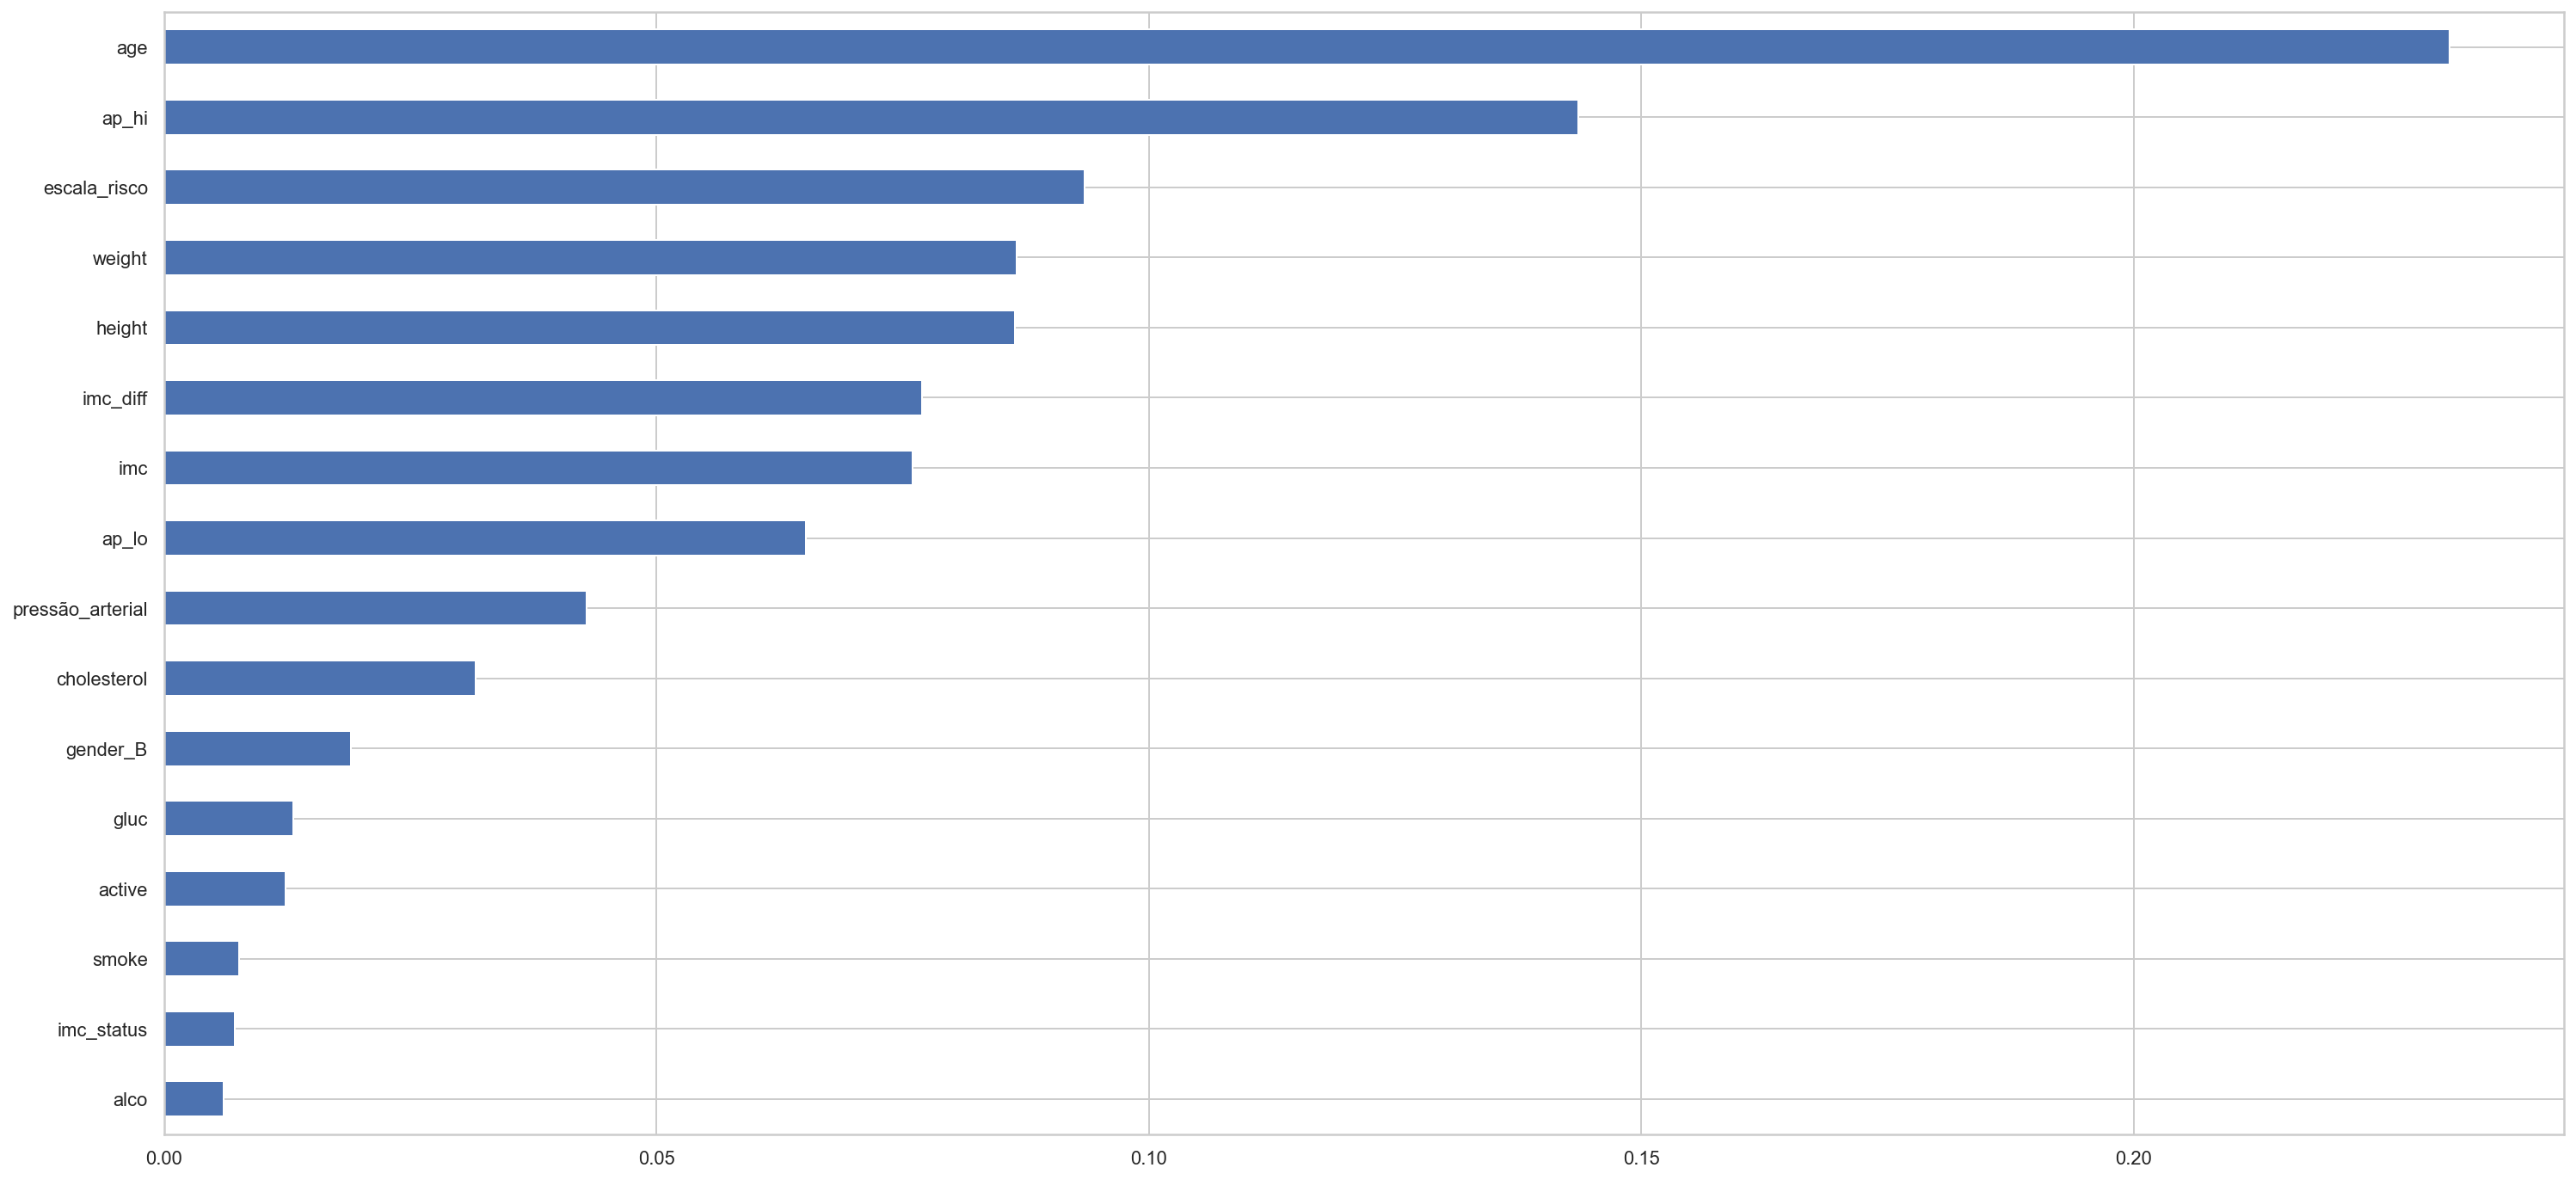

In [121]:
# verificando as importâncias das features
rf_clf.fit(X_train_prep, y_train)

feat_importances = pd.Series(rf_clf.feature_importances_, index=X_train_prep.columns)
feat_importances.sort_values().plot(kind='barh')


# 7.0 Modelo de Machine Learning 

***Targe variable: var (0 = no cardiovascular disease ; 1 = cardiovascular disease)***

In [122]:
X_train_prep.shape

(47250, 16)

Embora saibamos que o conjunto de dados é bastante equilibrado, como um experimento, vamos reamostar as classes aplicando a técnica SMOTE + Tomek-Links para ver quais resultados podemos obter.



## 7.1 Balanceando o conjunto de dados

In [123]:
# conta os valores das classes antes de equilibrar
y_train['cardio'].value_counts()

0    23657
1    23593
Name: cardio, dtype: int64

In [124]:
# define o resampler
resampler = SMOTETomek(random_state=SEED, n_jobs=-1)

# faz o equilíbrio dos dados
X_balanced, y_balanced = resampler.fit_resample(X_train_prep, y_train)
# Salvar no pickle
pickle.dump( resampler, open('parametros/balancear_dados.pkl','wb'))



In [125]:
# conta os valores das classes após o equilíbrio
y_balanced['cardio'].value_counts()



1    19029
0    19029
Name: cardio, dtype: int64

## 7.2 Treinar os modelos e obter as métricas de desempenho - Precisa definir o modelo

In [126]:
# define o threshold
THRESHOLD = 0.45

# Definir os classifiers
classifiers = [LogisticRegression(max_iter=220, random_state=SEED),
               RandomForestClassifier(random_state=SEED),
               xgb.XGBClassifier(random_state=SEED),
               BalancedRandomForestClassifier(random_state=SEED),
               CatBoostClassifier(random_state=SEED, verbose=False),
               KNeighborsClassifier(n_neighbors=5,  weights='distance',n_jobs=-1),
               SGDClassifier(loss='log', random_state=SEED, n_jobs=-1), 
               LGBMClassifier(random_state=SEED, n_jobs=-1), 
               GaussianNB()]

# Calcular a performance dos classifiers
df_performance = gu.get_classifiers_performance(X_balanced, X_test_prep, 
                                                np.ravel(y_balanced), np.ravel(y_test), 
                                                THRESHOLD, classifiers)

Training LogisticRegression...
Training RandomForestClassifier...
Training XGBClassifier...
[09:23:57] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\tulio.carvalho\Anaconda3\envs\CardiovascularDisease\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training BalancedRandomForestClassifier...
Training CatBoostClassifier...
Training KNeighborsClassifier...
Training SGDClassifier...
Training LGBMClassifier...
Training GaussianNB...


In [127]:
# destaque valores máximos para cada coluna
df_performance.style.highlight_max(color='darkorange')

Como observado, para o contexto do nosso projeto, somos:

**-**No lado dos negócios, visando a precisão, pois cada 5% a mais em precisão se traduz em $500 a mais de cada diagnóstico feito.                              
**-**Do lado do paciente, visando a recordação, pois estamos tentando minimizar a taxa falsa negativa.

Além disso, estamos tentando chegar a um equilíbrio entre precisão e recall. Podemos fazer uso da F1-Score como uma métrica que pode nos fornecer esse equilíbrio. Assim, o algoritmo que satisfaz essa necessidade é o ***LGBMClassifier.***

## 7.3 Matriz de Confusão

## 7.4. Melhorias

**1.**Usar as porcentagens dentro da confusion matrix                                                               
**2.**Usar a curva ROC para definir o Threshold. Default dos modelos é 0.5                                                               

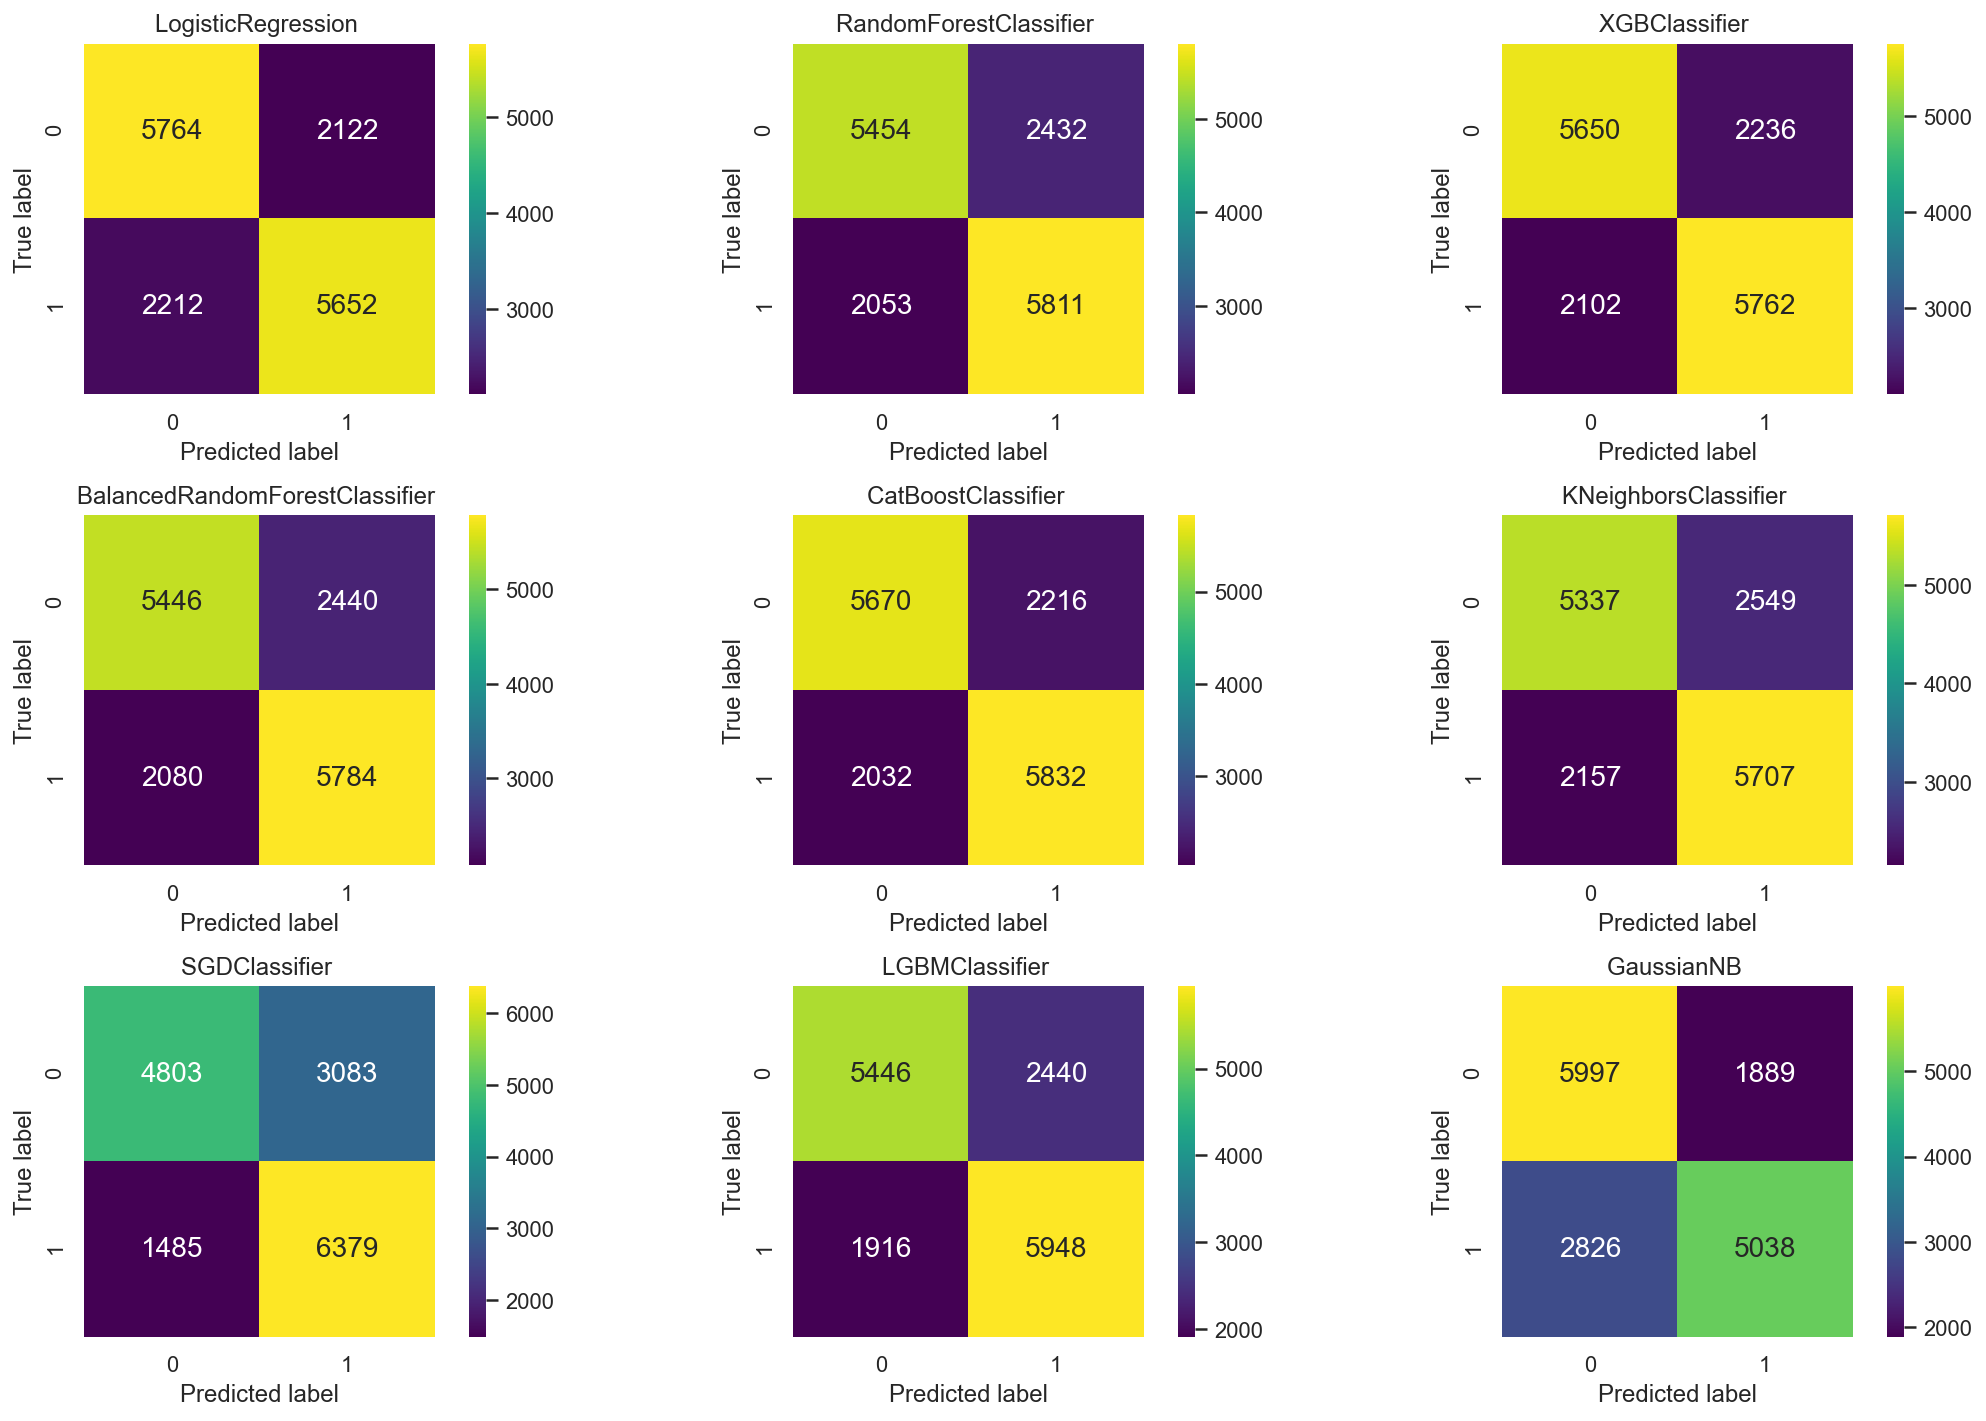

In [128]:
# define dimensões suplots
n_rows = 3
n_cols = 3
# plota uma matriz de confusão para cada classificador
gu.plot_multiple_confusion_matrices(n_rows, n_cols, X_test_prep, y_test, classifiers, THRESHOLD)


Embora o SGDClassifier tenha a maior precisão e o RandomForestClassifier tenha o maior recall, estamos buscando a maior F1-Score. Além disso, o RandomForestClassifier tem um dos mais altos FP (2594), enquanto o SGDClassifier tem um dos mais altos FN (2618) que não é apropriado. Assim, estamos seguindo em frente com o LGBMClassifier.

## 7.5 Distribuição de probabilidades 

Como vimos, existem três algoritmos que escolhemos como os que fazem uma análise mais aprofundada: **RandomForestClassifier, SGDClassifier e LGBMClassifier.** Poderíamos apenas seguir em frente com o último, mas vamos fazer algumas análises sobre sua distribuição de probabilidades e como elas se relacionam com o verdadeiro valor das classes.

In [129]:
# instancia os classificadores
rf_clf = RandomForestClassifier(random_state=SEED)
sgd_clf = SGDClassifier(loss='log', random_state=SEED, n_jobs=-1)
lgbm_clf = LGBMClassifier(random_state=SEED, n_jobs=-1)

# treina os classificadores
rf_clf.fit(X_balanced, np.ravel(y_balanced))
sgd_clf.fit(X_balanced, np.ravel(y_balanced))
lgbm_clf.fit(X_balanced, np.ravel(y_balanced))

# armazene as probabilidades previstas para a classe 1
y_pred_rf_prob = rf_clf.predict_proba(X_test_prep)[:,1]
y_pred_sgd_prob = sgd_clf.predict_proba(X_test_prep)[:,1]
y_pred_lgbm_prob = lgbm_clf.predict_proba(X_test_prep)[:,1]


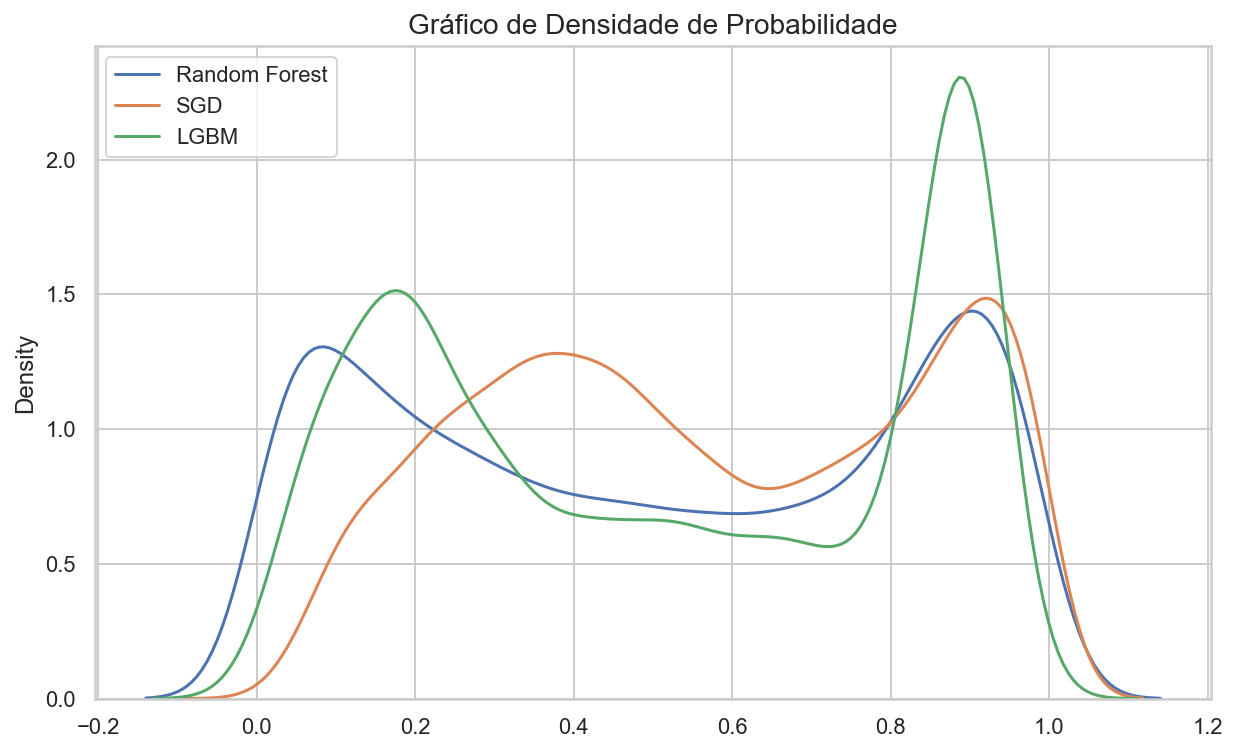

In [130]:
# Definir o tamanho do gráfico
plt.figure(figsize=(10,6))

# gráficos
sns.kdeplot(y_pred_rf_prob, label='Random Forest')
sns.kdeplot(y_pred_sgd_prob, label='SGD')
sns.kdeplot(y_pred_lgbm_prob, label='LGBM')

# Definir as variaveis do gráfico
plt.title("Gráfico de Densidade de Probabilidade", fontsize=14)
plt.legend()

# Exibir o Gráfico
plt.show()

Como observado, o LGBM tem a maior concentração de probabilidades perto de 0 e 1. Por outro lado, o SGD tem maior concentração perto de 0 e o menor perto de 1. Além disso, Random Forest é o oposto de SGD, ou seja, maior concentração perto de 1 e menor perto de 0. Então, ainda vamos continuar com a LGBM? Sim, porque, embora a Random Forest pareça ser um bom candidato, precisamos levar em conta as métricas anteriores que já analisamos e o contexto do nosso projeto.

 Outra métrica que pode nos ajudar a avaliar o algoritmo certo para o nosso projeto é a **Brier Score Loss**, de acordo com sua documentação:

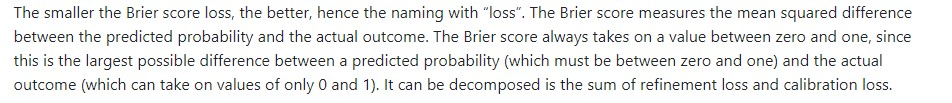

In [131]:
Image('img/Brier Score Loss.jpg')

Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html

Ou seja, Quanto menor a perda de pontuação de Brier, melhor, daí a nomeação com "perda". A pontuação de Brier mede a diferença média entre a probabilidade prevista e o resultado real.A pontuação de Brier sempre assume um valor entre zero e um, uma vez que esta é a maior diferença possível entre uma probabilidade prevista (que deve ser entre zero e um) e o resultado real (que pode assumir valores de apenas 0 e 1). Pode ser decomposto é a soma da perda de refinamento e perda de calibração.

In [132]:
# Calculo da Brier Score Loss
bsl_rf = brier_score_loss(y_test, y_pred_rf_prob, pos_label=1)
bsl_sgd = brier_score_loss(y_test, y_pred_sgd_prob, pos_label=1)
bsl_lgbm = brier_score_loss(y_test, y_pred_lgbm_prob, pos_label=1)

# imprime a perda calculada de pontuação de Brier para cada probabilidade de algoritmo
print(f'Brier Score Loss (Random Forest): {bsl_rf}')
print(f'Brier Score Loss (SGD): {bsl_sgd}')
print(f'Brier Score Loss (LGBM): {bsl_lgbm}')


Brier Score Loss (Random Forest): 0.1959108028605262
Brier Score Loss (SGD): 0.19142270051760416
Brier Score Loss (LGBM): 0.18806413234611935


 Como observado, Brier Score Loss é diferente. Para este placar, quanto mais perto de 0, melhor. Assim, o LGBM combina melhor com nossas necessidades.

## 7.6 Curva ROC

 Leitura recomendada(Em ingles):https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

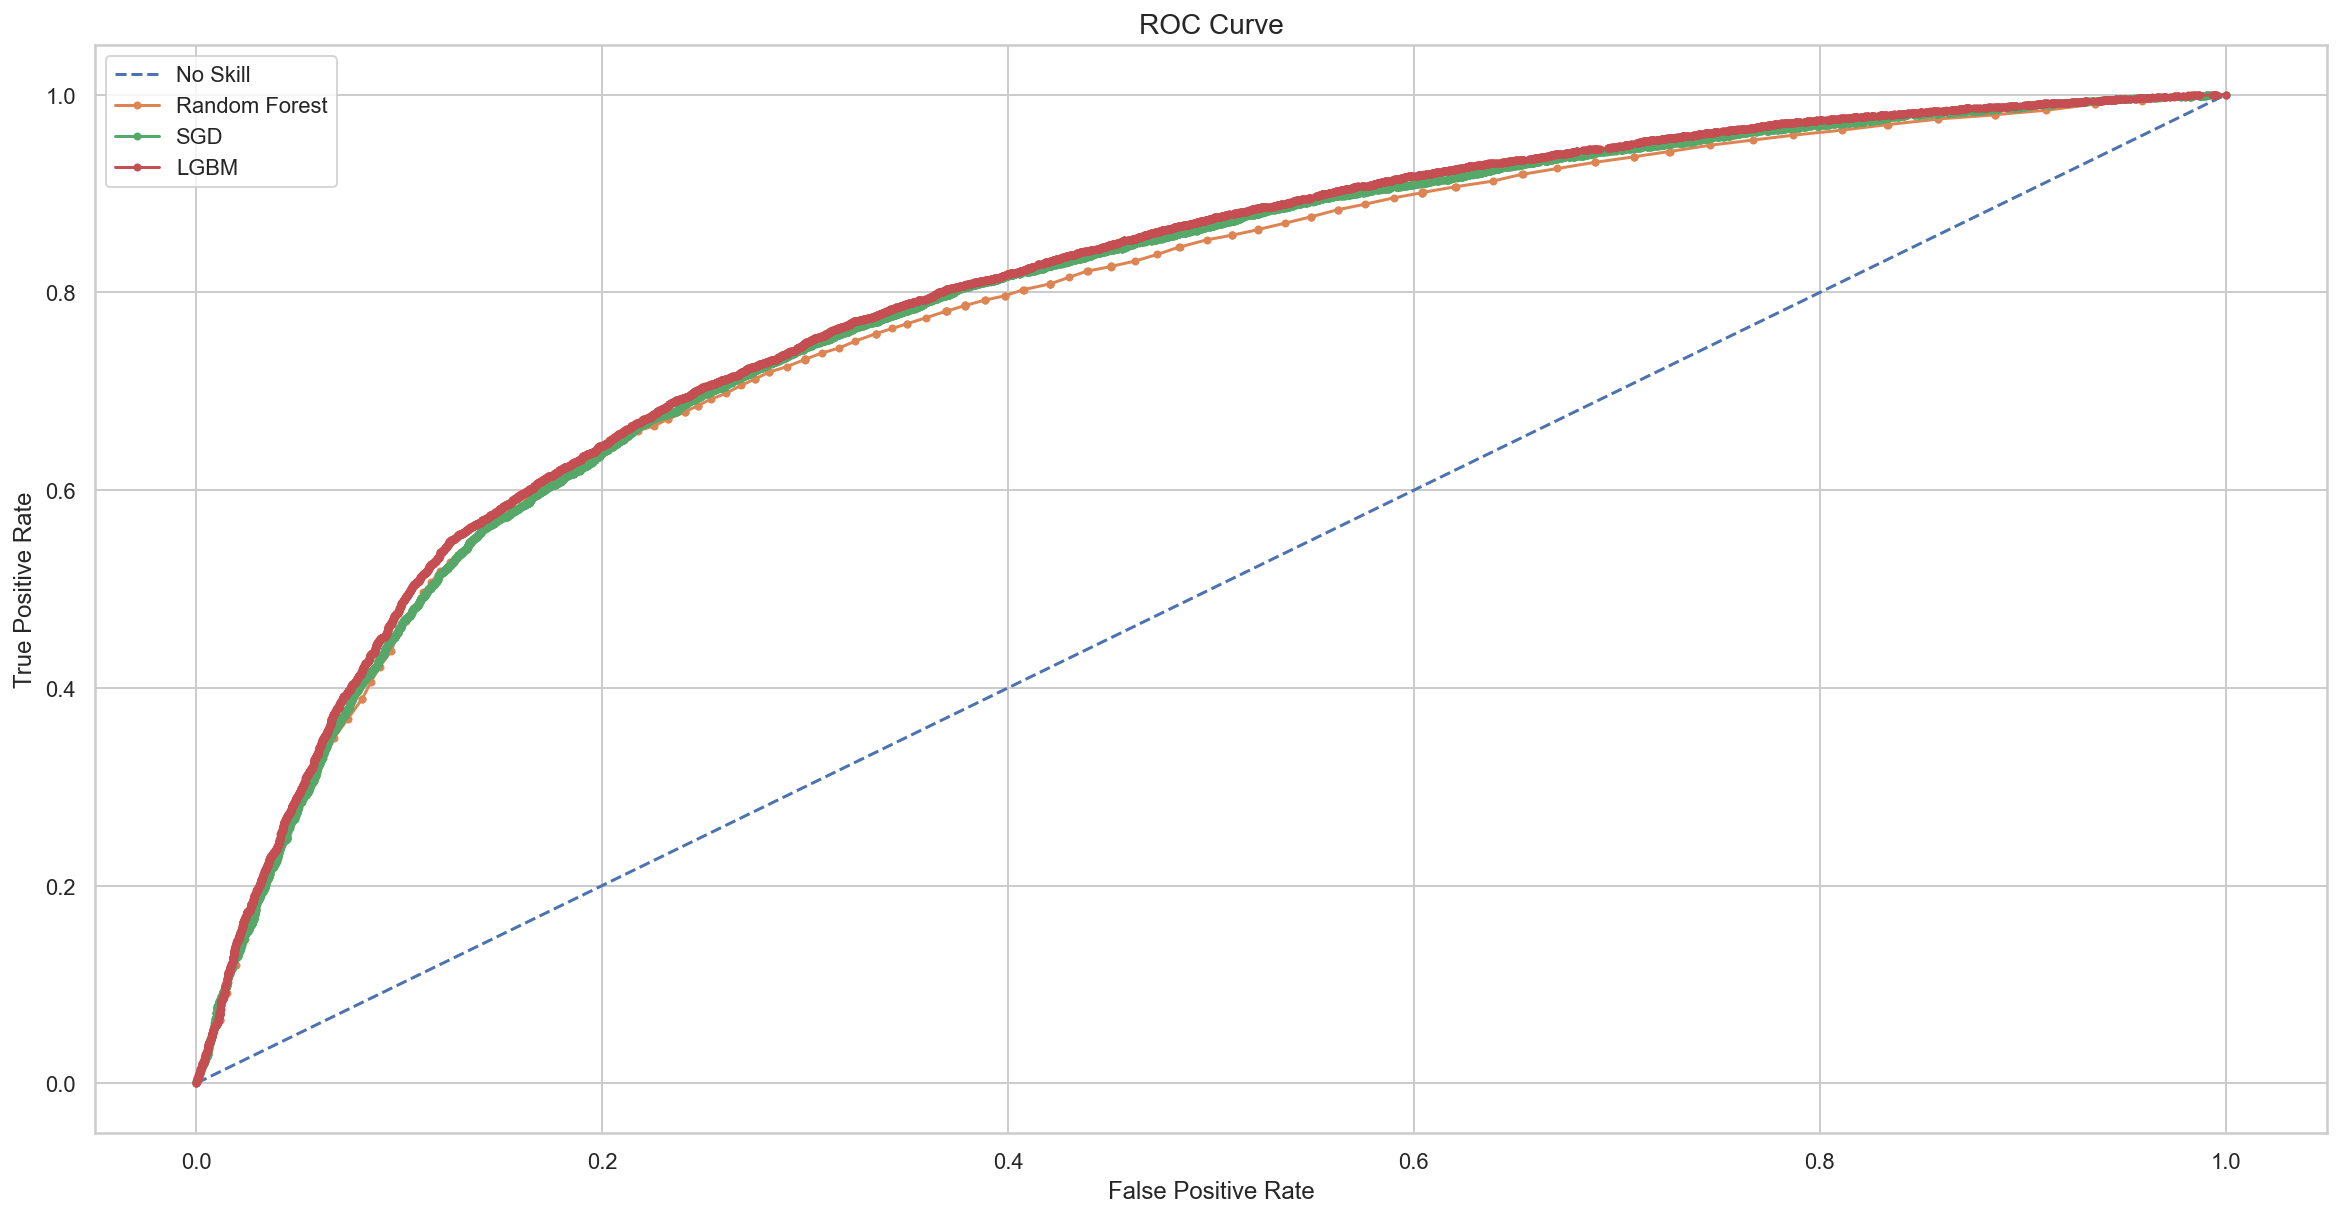

In [133]:
# usa a variável ax para um único axis
fig, ax = plt.subplots()


# define o tamanho da figura em polegadas
ax.figure.set_size_inches(20, 10)

# gerar uma previsão sem habilidade (classe majoritária)
ns_probs = [0 for _ in range(len(y_test))]

# Calcula as curvas roc
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_pred_rf_prob)
sgd_fpr, sgd_tpr, _ = roc_curve(y_test, y_pred_sgd_prob)
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, y_pred_lgbm_prob)


# plota a curva roc para o modelo
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')
plt.plot(sgd_fpr, sgd_tpr, marker='.', label='SGD')
plt.plot(lgbm_fpr, lgbm_tpr, marker='.', label='LGBM')

# define características do enredo
plt.title("ROC Curve", fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# exibe a lenda
plt.legend()

# Exibe o Gráfico
plt.show()


 Como observado, visualmente falando, a curva ROC para LGBM apresenta melhor desempenho, pois está mais distante da linha azul do meio, que significa o mesmo que se não tivesse usado algoritmo.

## 7.7 Relatório de Classificação

In [134]:
# faz as previsões
y_pred_rf = rf_clf.predict(X_test_prep)
y_pred_sgd = sgd_clf.predict(X_test_prep)
y_pred_lgbm = lgbm_clf.predict(X_test_prep)

print('Classification Report for ' + type(rf_clf).__name__)
print(classification_report(y_test, y_pred_rf))

print('\nClassification Report for ' + type(sgd_clf).__name__)
print(classification_report(y_test, y_pred_sgd))

print('\nClassification Report for ' + type(lgbm_clf).__name__)
print(classification_report(y_test, y_pred_lgbm))

Classification Report for RandomForestClassifier
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      7886
           1       0.72      0.71      0.71      7864

    accuracy                           0.72     15750
   macro avg       0.72      0.72      0.72     15750
weighted avg       0.72      0.72      0.72     15750


Classification Report for SGDClassifier
              precision    recall  f1-score   support

           0       0.74      0.68      0.71      7886
           1       0.70      0.76      0.73      7864

    accuracy                           0.72     15750
   macro avg       0.72      0.72      0.72     15750
weighted avg       0.72      0.72      0.72     15750


Classification Report for LGBMClassifier
              precision    recall  f1-score   support

           0       0.73      0.72      0.72      7886
           1       0.72      0.73      0.72      7864

    accuracy                           0.72     15

Como analisamos antes, estamos procurando por uma pontuação alta na F1-score. Assim, O LGBM combina melhor com nossas necessidades

## 7.8 Cross-validation scoring - LGBM Classifier

Agora, devemos usar a pontuação de validação cruzada com cross_val_score() para verificar o desempenho geral.

In [135]:
# obtém o conjunto completo de dados para fazer a validação cruzada
X_full = pd.concat([X_train_prep, X_test_prep], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)

print(f'Temos {X.shape[0]} registros no conjunto de dados completos.')

Temos 63000 registros no conjunto de dados completos.


In [136]:
# recebe a proporção de classes

negative_ratio = y_full['cardio'].value_counts(normalize=True).to_dict()[0]
positive_ratio = y_full['cardio'].value_counts(normalize=True).to_dict()[1]

print(f'Proporção de negativos no conjunto completo de dados: : {negative_ratio}')
print(f'Proporção de positivos no conjunto completo de dados:  {positive_ratio}')



Proporção de negativos no conjunto completo de dados: : 0.5006825396825397
Proporção de positivos no conjunto completo de dados:  0.4993174603174603


 Como observado, não há um desequilíbrio significativo entre as classes, mas apenas para ter certeza, adotaremos o StratifiedKFold como nossa estratégia de  K-folding para validação cruzada.

In [137]:
# define a estratégia de validação cruzada
cv = StratifiedKFold(n_splits=10)

In [138]:
# calcula as pontuações de validação cruzada
cv_scores = cross_val_score(lgbm_clf, X_full, np.ravel(y_full), cv = cv, scoring='precision', n_jobs=-1)




# imprime a precisão média e o desvio padrão das pontuações
print("Precisão média: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calcula as pontuações de validação cruzada
cv_scores = cross_val_score(lgbm_clf, X_full, np.ravel(y_full), cv = cv, scoring='recall', n_jobs=-1)

# imprime o recall médio e o desvio padrão das pontuações
print("\nRecall médio: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calcula as pontuações de validação cruzada
cv_scores = cross_val_score(lgbm_clf, X_full, np.ravel(y_full), cv = cv, scoring='f1', n_jobs=-1)

# imprime a pontuação média de F1 e o desvio padrão das pontuações
print("\nf1-score médio: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calcula as pontuações de validação cruzada
cv_scores = cross_val_score(lgbm_clf, X_full, np.ravel(y_full), cv = cv, scoring='roc_auc', n_jobs=-1)

# imprime a média roc_auc e o desvio padrão das pontuações
print("\nROC AUC médio: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))

Precisão média: 0.7549 (+/- 0.0105)

Recall médio: 0.6957 (+/- 0.0109)

f1-score médio: 0.7241 (+/- 0.0065)

ROC AUC médio: 0.8013 (+/- 0.0078)


 Como observado, as curvas de RP para LGBMClassifier e RandomForestClassifier estão bem próximas. No entanto, as Matrizes de Confusão são diferentes e ajudaram na hora de decidir qual algoritmo escolher.

# 8.0 Sintonizando o melhor modelo - Usar biblioteca HyperOpt

***LGBM Classifier(escolhido como o melhor geral)***

## 8.1 Hyperparameter Tunning

In [139]:
# instanciar o classificador
lgbm_clf = LGBMClassifier(random_state=SEED, n_jobs=-1)





In [140]:
# configurar dicionário de espaço com hiperparmetros especificados
space = {'max_depth': np.arange(2, 12, 2), 
         'num_leaves': 2 ** np.arange(2, 10, 2),
         'min_data_in_leaf': np.arange(100, 1050, 50), 
         'learning_rate': np.linspace(0.001, 0.6, 15),
         'colsample_bytree': np.linspace(0.1, 1, 5),
         'subsample': np.linspace(0.25, 1, 15),
         'n_estimators': np.arange(10, 105, 15)}

In [141]:
# preparando RandomizedSearchCV object
lgbm_clf_cv = RandomizedSearchCV(estimator=lgbm_clf, param_distributions=space,
                                scoring='f1', n_iter=100, cv=5, verbose=2,
                                random_state=SEED, n_jobs=-1)

In [142]:
# treinando o RandomizedSearchCV object
lgbm_clf_cv.fit(X_balanced, np.ravel(y_balanced))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   36.5s finished


[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
                                        'learning_rate': array([0.001     , 0.04378571, 0.08657143, 0.12935714, 0.17214286,
       0.21492857, 0.25771429, 0.3005    , 0.34328571, 0.38607143,
       0.42885714, 0.47164286, 0.51442857, 0.55721429, 0.6       ]),
                                        'max_depth': arra...
                                        'min_data_in_leaf': array([ 100,  150,  200,  250,  300,  350,  400,  450,  500,  550,  600,
        650,  700,  750,  800,  850,  900,  950, 1000]),
                                        'n_estimators': array([ 10,  25,  40,  55,  70,  85, 100]),
                                        'num_leaves': array([  4,  16,  64, 256], dtype=int32),
                                        'subsample': array([0.25      , 0.30357

In [143]:
# melhor estimador
lgbm_clf_cv.best_estimator_

LGBMClassifier(learning_rate=0.17214285714285713, max_depth=8,
               min_data_in_leaf=950, n_estimators=85, num_leaves=256,
               random_state=42, subsample=0.5714285714285714)

## 8.2 Predictions & Metrics

In [144]:
# definir o threshold
THRESHOLD = 0.45

# Extraia o melhor estimador
lgbm_tuned_model = lgbm_clf_cv.best_estimator_

# calcula o desempenho dos classifier
df_performance = gu.get_classifiers_performance(X_balanced, X_test_prep, 
                                                np.ravel(y_balanced), np.ravel(y_test), 
                                                THRESHOLD, [lgbm_tuned_model])

df_performance

Training LGBMClassifier...


model  precision  recall  f1-Score  ROC AUC  accuracy  cohen kappa
0  LGBMClassifier     0.7058  0.7626    0.7331   0.7957    0.7227       0.4455

In [145]:
# Imprima os parâmetros e pontuação sintonizados
print("\nParâmetros ajustados: {}".format(lgbm_clf_cv.best_params_)) 
print("\nMelhor score: {:.4f}".format(lgbm_clf_cv.best_score_))



Parâmetros ajustados: {'subsample': 0.5714285714285714, 'num_leaves': 256, 'n_estimators': 85, 'min_data_in_leaf': 950, 'max_depth': 8, 'learning_rate': 0.17214285714285713, 'colsample_bytree': 1.0}

Melhor score: 0.7858


## 8.3 Curva ROC

Recomendação de leitura:  https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

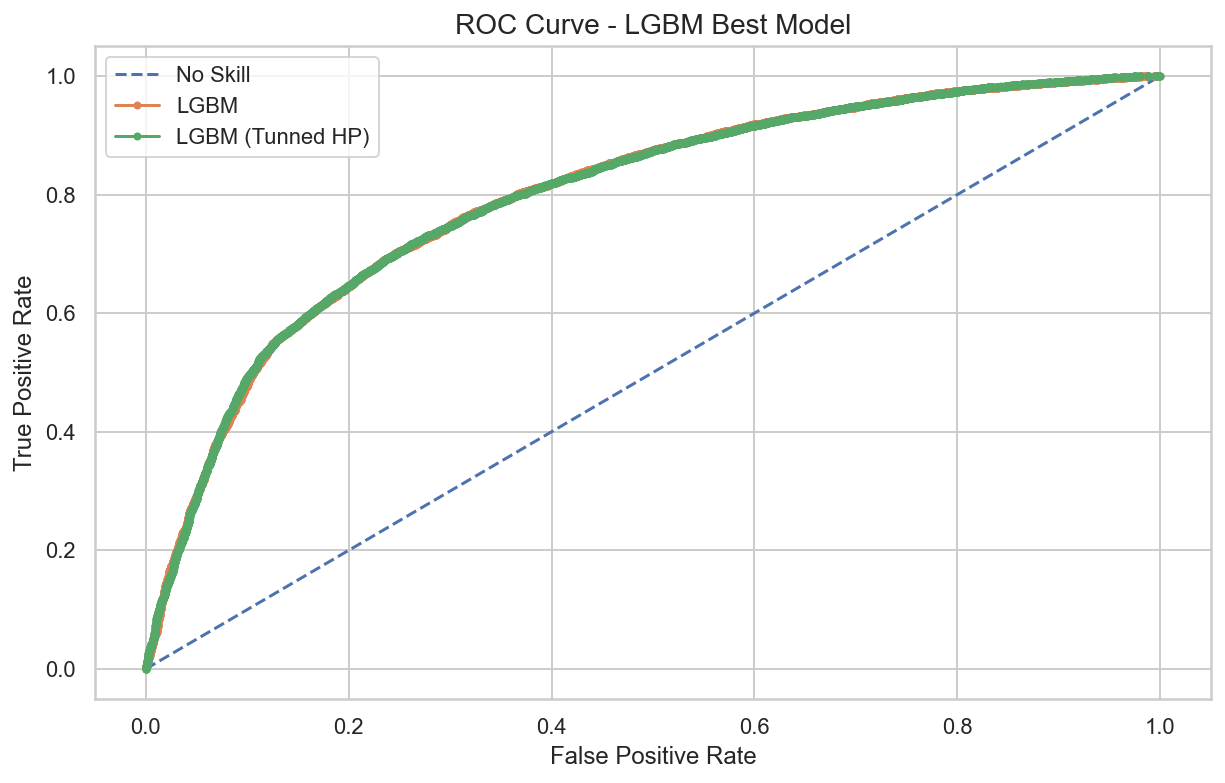

In [146]:
# Definir o tamanho do gráfico
plt.figure(figsize=(10,6))

# gerar uma previsão sem habilidade (classe majoritária)
ns_probs = [0 for _ in range(len(y_test))]

# prever probabilidades
lgbm_tuned_model_probs = lgbm_tuned_model.predict_proba(X_test_prep)

# Calcular a curva ROC
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
tuned_fpr, tuned_tpr, _ = roc_curve(y_test, lgbm_tuned_model_probs[:,1])

# traçar a curva roc para o modelo
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lgbm_fpr, lgbm_tpr, marker='.', label='LGBM')
plt.plot(tuned_fpr, tuned_tpr, marker='.', label='LGBM (Tunned HP)')

# axis dos rótulos
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# título
plt.title('ROC Curve - LGBM Best Model', fontsize=14)

# Mostrar a legenda 
plt.legend()

# Exibir o gráfico
plt.show()

##  8.4 Matriz de Confusão

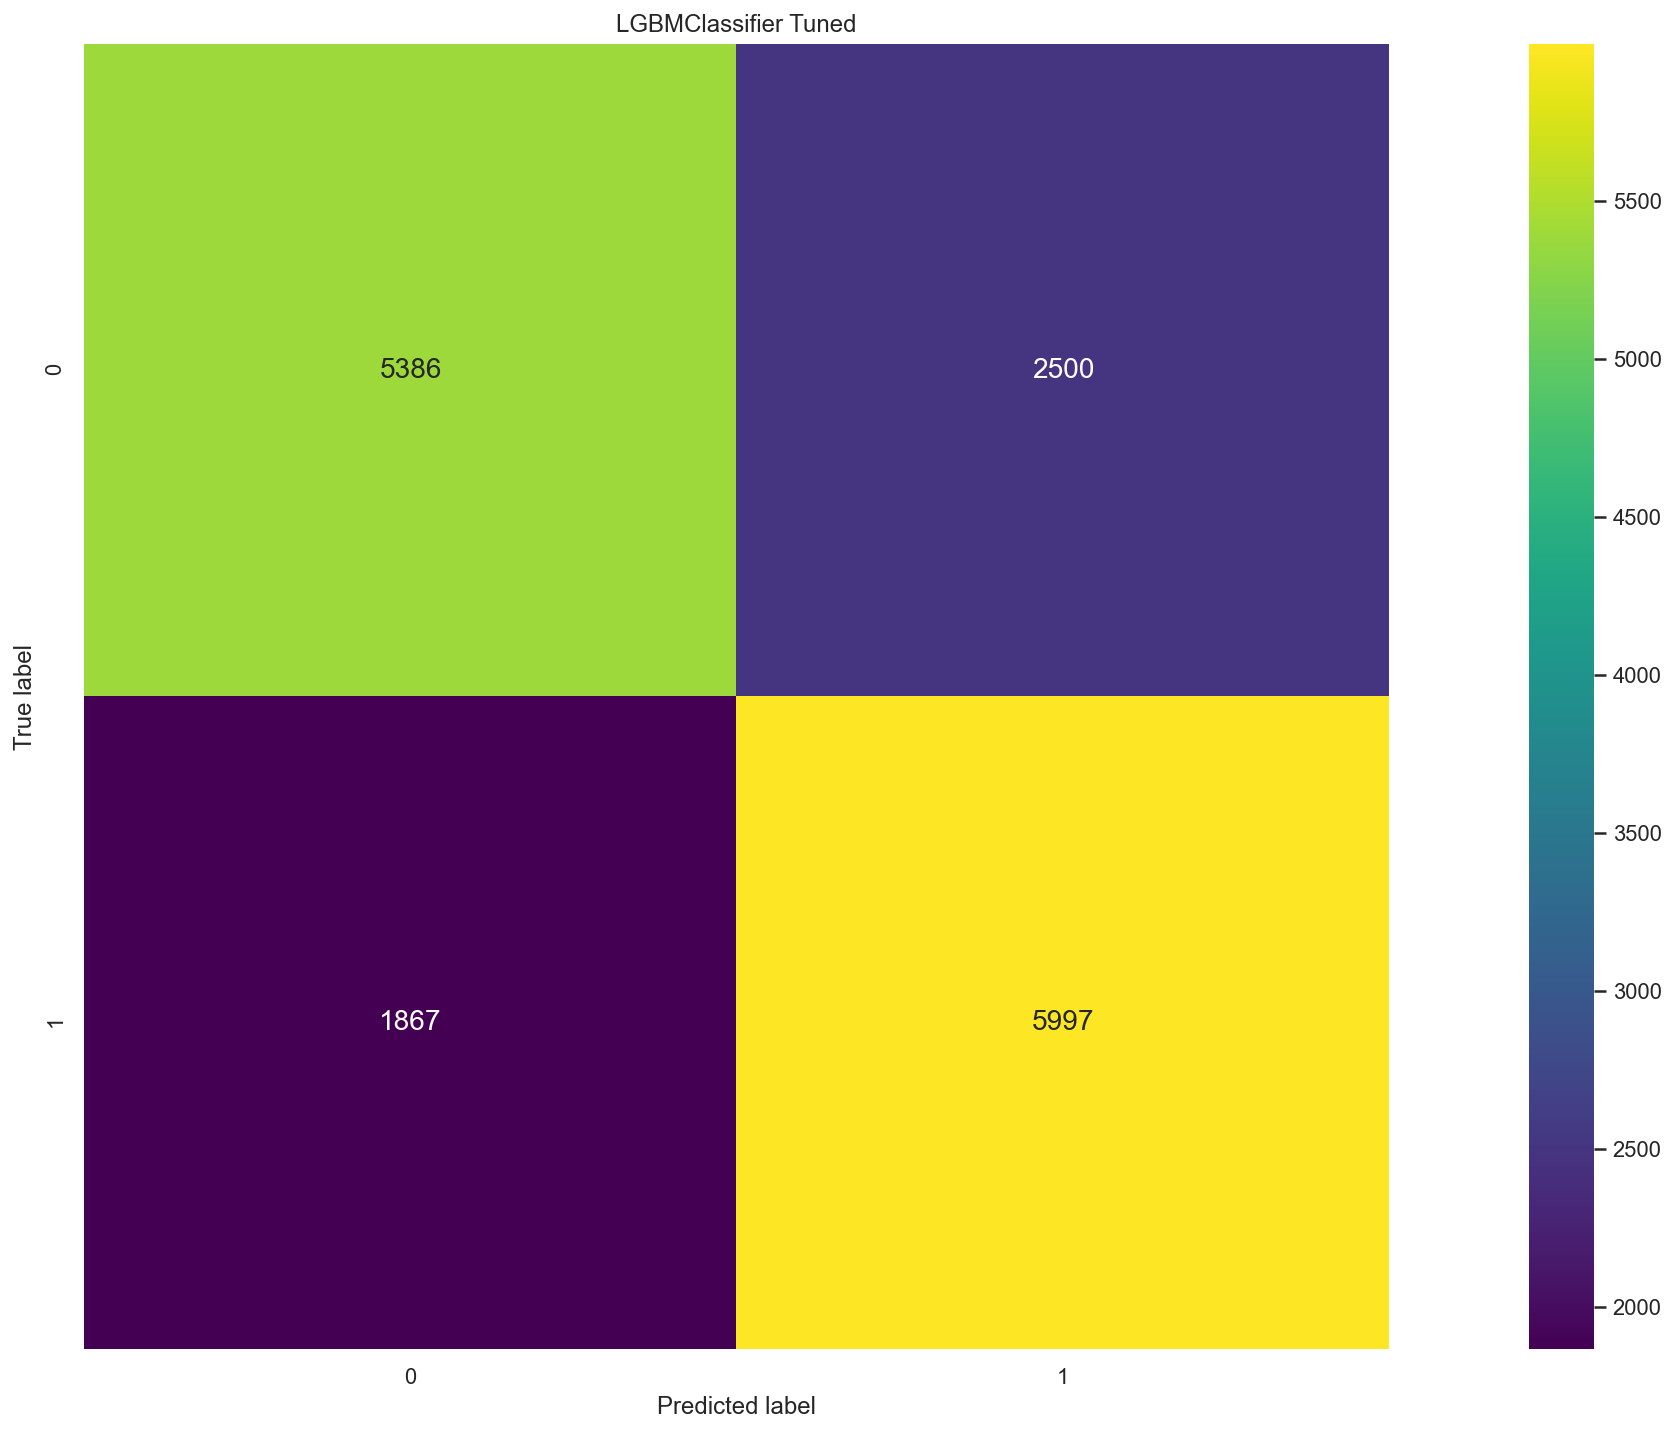

In [147]:
# mantém probabilidades apenas para o resultado positivo
df_probs = pd.DataFrame(lgbm_tuned_model_probs[:, 1], columns = ['prob_default'])

# aplicado o limiar
y_pred = df_probs['prob_default'].apply(lambda x: 1 if x > THRESHOLD else 0)

gu.plot_single_confusion_matrix(y_test, y_pred, lgbm_tuned_model, 'Tuned')

# exibir o gráfico
plt.show()

## 8.5 Cross-validation scoring

 Agora, devemos usar a pontuação de validação cruzada com cross_val_score() para verificar o desempenho geral.

 Uma excelente oportunidade para testar o uso da sintonia dos hiperparâmetros. Lembre-se, hiperparmetros são como configurações que podem ajudar a criar um desempenho ideal.

Recomendação de leitura:  https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics

In [148]:
# define a estratégia de validação cruzada
cv = StratifiedKFold(n_splits=10)

In [149]:
# calcula as pontuações de validação cruzada
cv_scores = cross_val_score(lgbm_tuned_model, X_full, np.ravel(y_full), cv = cv, scoring='precision', n_jobs=-1)

# imprime a precisão média e o desvio padrão das pontuações
print("Precision Média: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calcula as pontuações de validação cruzada
cv_scores = cross_val_score(lgbm_tuned_model, X_full, np.ravel(y_full), cv = cv, scoring='recall', n_jobs=-1)

# imprime a pontuação média de Recall e o desvio padrão das pontuações
print("\nRecall médio: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calcula as pontuações de validação cruzada
cv_scores = cross_val_score(lgbm_tuned_model, X_full, np.ravel(y_full), cv = cv, scoring='f1', n_jobs=-1)

# imprime a média f1-score e o desvio padrão das pontuações
print("\nF1-score méido: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calcula as pontuações de validação cruzada
cv_scores = cross_val_score(lgbm_tuned_model, X_full, np.ravel(y_full), cv = cv, scoring='roc_auc', n_jobs=-1)

# imprime a média roc_auc e o desvio padrão das pontuações
print("\nROC AUC médio: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))

Precision Média: 0.7516 (+/- 0.0092)

Recall médio: 0.7007 (+/- 0.0103)

F1-score méido: 0.7253 (+/- 0.0063)

ROC AUC médio: 0.8005 (+/- 0.0067)


In [150]:
# calcula as pontuações de validação cruzada
cv_scores = cross_val_score(lgbm_tuned_model, X_full, np.ravel(y_full), cv = cv, scoring='precision', n_jobs=-1)

price_per_percent = 500/5
baseline = 50
num_pacients = 70000

model_accuracy = cv_scores.mean()
deviation = cv_scores.std() * 2

accuracy_lower = (model_accuracy - deviation) * 100
accuracy_upper = (model_accuracy + deviation) * 100

percent_difference_lower = accuracy_lower - baseline
percent_difference_upper = accuracy_upper - baseline

amount_best = percent_difference_upper * price_per_percent * num_pacients
amount_worst = percent_difference_lower * price_per_percent * num_pacients

In [151]:
print(f'Melhor:  ${round(amount_best, 2):,.2f}')
print(f'Pior:    ${round(amount_worst, 2):,.2f}')

Melhor:  $182,528,266.87
Pior:    $169,692,328.12


## 8.6 Salvando o modelo treinado

In [152]:
# salvando o modelo
pickle.dump(lgbm_tuned_model, open('modelo/tuned_model_ccd.pkl', 'wb'))

# 9.0 Avalização do Modelo sintonizado

## 9.1 Calibration curves

 Precisamos verificar a calibração de dois modelos (Calibrado e Não Calibrado) para ver o quão estável é o desempenho da previsão padrão entre as probabilidades. Você pode usar um gráfico da calibração de cada modelo para verificar isso chamando a função ***calibration_curve()***.

Recomendação de leitura:

**-**https://machinelearningmastery.com/calibrated-classification-model-in-scikit                                                                                                                                   

**-** https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html

In [153]:
# carrega o modelo sintonizado
lgbm_tuned_model = pickle.load(open('modelo/tuned_model_ccd.pkl', 'rb'))



In [154]:
# define a estratégia de validação cruzada
cv = StratifiedKFold(n_splits=10)





In [155]:
# treina o modelo tunned
lgbm_tuned_model.fit(X_balanced, y_balanced)

# define e treina modelo de calibração
calibrated_lgbm = CalibratedClassifierCV(lgbm_tuned_model, method='isotonic', cv=cv)
calibrated_lgbm.fit(X_train_prep, np.ravel(y_train))

C:\Users\tulio.carvalho\Anaconda3\envs\CardiovascularDisease\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGB

CalibratedClassifierCV(base_estimator=LGBMClassifier(learning_rate=0.17214285714285713,
                                                     max_depth=8,
                                                     min_data_in_leaf=950,
                                                     n_estimators=85,
                                                     num_leaves=256,
                                                     random_state=42,
                                                     subsample=0.5714285714285714),
                       cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                       method='isotonic')

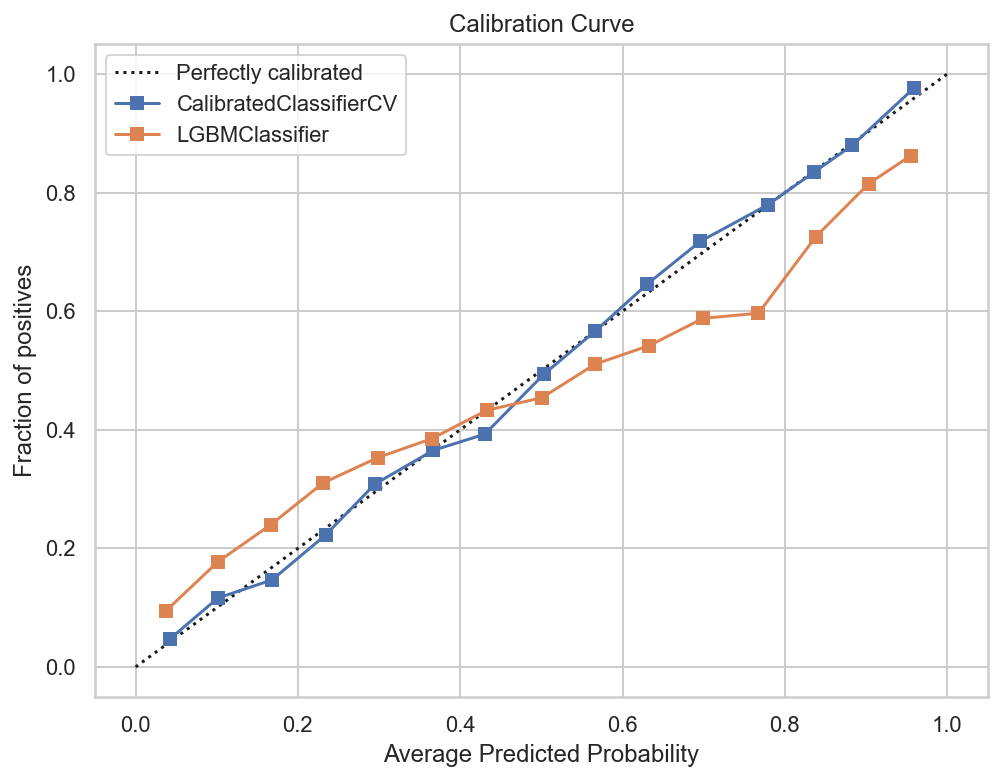

In [156]:
# definir o numero de bins
BINS = 15

# predição de possibilidades
lgbm_tuned_model_probs = lgbm_tuned_model.predict_proba(X_test_prep)
calibrated_lgbm_probs = calibrated_lgbm.predict_proba(X_test_prep)


# traça uma curva de calibração para cada modelo
gu.plot_multiple_calibration_curves([calibrated_lgbm, lgbm_tuned_model], y_test, 
                                 [calibrated_lgbm_probs, lgbm_tuned_model_probs], BINS)

# Exibir o gráfico
plt.show()

 Visualmente falando, o modelo calibrado parece ser melhor. No entanto, precisamos verificar uma métrica que nos dará um número: Brier Score Loss.

Recomendação de leitura: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html

In [157]:
# Calculo Brier Score Loss
bsl_lgbm_model = brier_score_loss(y_test, lgbm_tuned_model_probs[:,1], pos_label=1)
bsl_lgbm_calibrated = brier_score_loss(y_test, calibrated_lgbm_probs[:,1], pos_label=1)

# prints o calculo do Brier Score Losspara a possibilidade do algoritmo
print(f'Brier Score Loss (CatBoost Classifier (Tunned HP)): {bsl_lgbm_model}')
print(f'Brier Score Loss (CatBoost Classifier (Tunned HP + Calibrated)): {bsl_lgbm_calibrated}')

# checks quais dos dois são melhores
if bsl_lgbm_calibrated < bsl_lgbm_model:
    print('\nO medelo calibrado é a melhor calibração.')
else:
    print('\nO medelo descalibrado é a melhor calibração.')

Brier Score Loss (CatBoost Classifier (Tunned HP)): 0.18800040743463467
Brier Score Loss (CatBoost Classifier (Tunned HP + Calibrated)): 0.17934891803297398

O medelo calibrado é a melhor calibração.


## 9.3 Calibrated model - ROC Curve

Recomendação de leitura:  https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

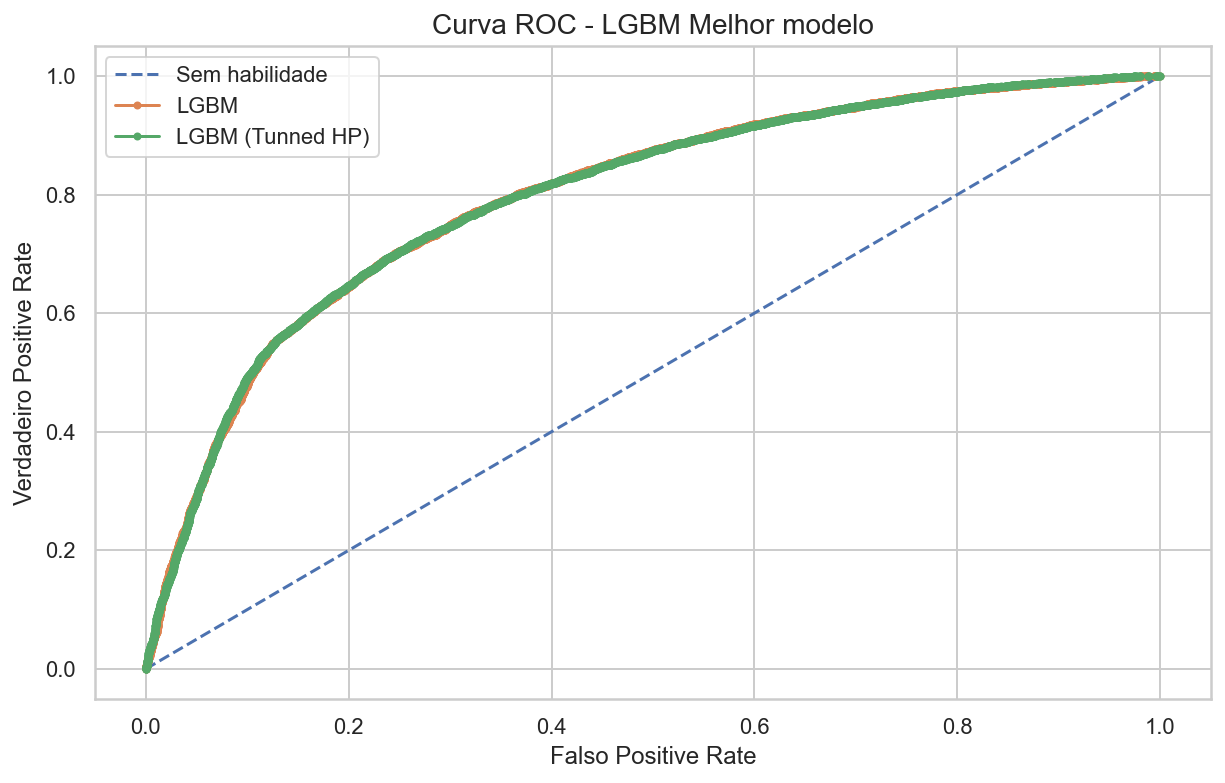

In [158]:
# Definir o tamanho do gráfico
plt.figure(figsize=(10,6))

# gerar uma previsão sem habilidade (classe majoritária)
ns_probs = [0 for _ in range(len(y_test))]

# prever probabilidades
lgbm_tuned_model_probs = lgbm_tuned_model.predict_proba(X_test_prep)

# Calcular a curva ROC
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
tuned_fpr, tuned_tpr, _ = roc_curve(y_test, lgbm_tuned_model_probs[:,1])

# traçar a curva roc para o modelo
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sem habilidade')
plt.plot(lgbm_fpr, lgbm_tpr, marker='.', label='LGBM')
plt.plot(tuned_fpr, tuned_tpr, marker='.', label='LGBM (Tunned HP)')

# Axis labels
plt.xlabel('Falso Positive Rate')
plt.ylabel('Verdadeiro Positive Rate')

# titulo
plt.title('Curva ROC - LGBM Melhor modelo', fontsize=14)

# Mostrar legenda
plt.legend()

# Mostrar Gráfico
plt.show()

## 8.4 Matriz de confusão

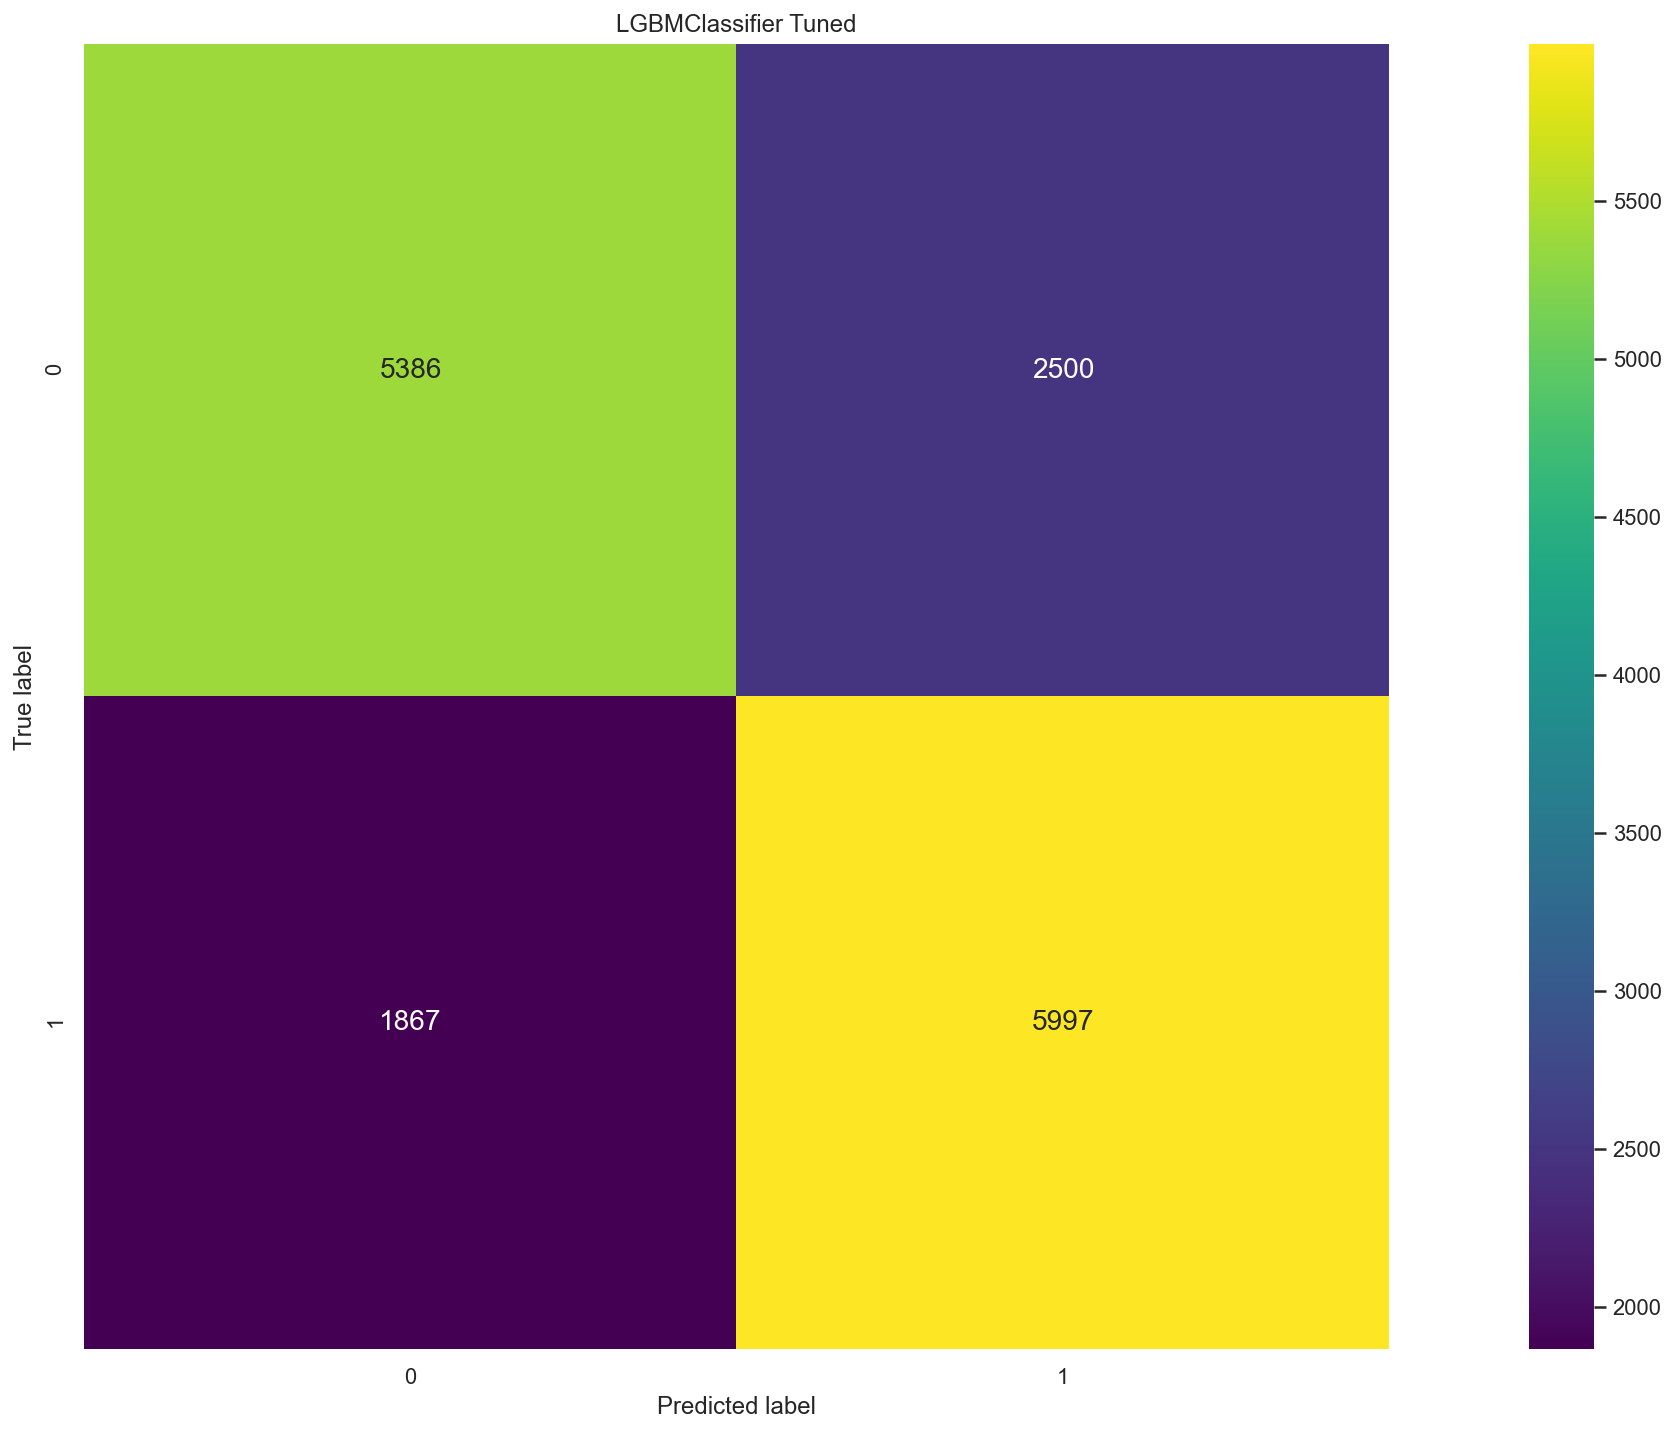

In [159]:
# Apenas mantém probabilidades para o resultado positivo
df_probs = pd.DataFrame(lgbm_tuned_model_probs[:, 1], columns = ['prob_default'])

# Aplica o threshold
y_pred = df_probs['prob_default'].apply(lambda x: 1 if x > THRESHOLD else 0)

gu.plot_single_confusion_matrix(y_test, y_pred, lgbm_tuned_model, 'Tuned')

# Exibe o gráfico
plt.show()

## 8.5 Cross-validation scoring

 Agora, devemos usar a pontuação de validação cruzada com cross_val_score() para verificar o desempenho geral.

Uma excelente oportunidade para testar o uso da sintonia dos hiperparâmetros. Lembre-se, hiperparmetros são como configurações que podem ajudar a criar um desempenho ideal.

Recomendação de leitura: https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics

In [160]:
# Definir a estratégia da cross validation
cv = StratifiedKFold(n_splits=10)

In [161]:
# Calcular o score da cross validation precision
cv_scores = cross_val_score(lgbm_tuned_model, X_full, np.ravel(y_full), cv = cv, scoring='precision', n_jobs=-1)

# Mostra a média da precisão e o desvio padrão médio
print("Precision média: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# Calculo da cross validation score recall
cv_scores = cross_val_score(lgbm_tuned_model, X_full, np.ravel(y_full), cv = cv, scoring='recall', n_jobs=-1)

# Mostra a média da recall e o desvio padrão médio
print("\n recall médio: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# Calculo da cross validation score f1
cv_scores = cross_val_score(lgbm_tuned_model, X_full, np.ravel(y_full), cv = cv, scoring='f1', n_jobs=-1)

# Mostra a média da f1-Score e o desvio padrão médio
print("\nF1-score médio: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# Calculo da cross validation score rou - auc
cv_scores = cross_val_score(lgbm_tuned_model, X_full, np.ravel(y_full), cv = cv, scoring='roc_auc', n_jobs=-1)

# Mostra a média da ROC AUC e e o desvio padrão médio
print("\nROC AUC médio: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))

Precision média: 0.7516 (+/- 0.0092)

 recall médio: 0.7007 (+/- 0.0103)

F1-score médio: 0.7253 (+/- 0.0063)

ROC AUC médio: 0.8005 (+/- 0.0067)


In [162]:
# Calculo da cross validation score
cv_scores = cross_val_score(lgbm_tuned_model, X_full, np.ravel(y_full), cv = cv, scoring='precision', n_jobs=-1)

price_per_percent = 500/5
baseline = 50
num_pacients = 70000

model_accuracy = cv_scores.mean()
deviation = cv_scores.std() * 2

accuracy_lower = (model_accuracy - deviation) * 100
accuracy_upper = (model_accuracy + deviation) * 100

percent_difference_lower = accuracy_lower - baseline
percent_difference_upper = accuracy_upper - baseline

amount_best = percent_difference_upper * price_per_percent * num_pacients
amount_worst = percent_difference_lower * price_per_percent * num_pacients

In [163]:
print(f'Melhor:  ${round(amount_best, 2):,.2f}')
print(f'Pior: ${round(amount_worst, 2):,.2f}')

Melhor:  $182,528,266.87
Pior: $169,692,328.12


## 8.6 Saving the tuned model

In [164]:
# Salvar o modelo
pickle.dump(lgbm_tuned_model, open('modelo/tuned_model_ccd.pkl', 'wb'))

# 9.0 Avaliação do Modelo "Tunado" 

## 9.1 Calibrando as curvas

 Precisamos verificar a calibração de dois modelos (Calibrado e Não Calibrado) para ver o quão estável é o desempenho da previsão padrão entre as probabilidades. Você pode usar um gráfico da calibração de cada modelo para verificar isso chamando a função calibration_curve().

Recomendações de leitura:

https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/

https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html

In [166]:
# Carregar o modelo tunado
lgbm_tuned_model = pickle.load(open('modelo/tuned_model_ccd.pkl', 'rb'))

# definir a estratégia de cross validação
cv = StratifiedKFold(n_splits=10)


In [167]:
# treina o modelo tunado
lgbm_tuned_model.fit(X_balanced, y_balanced)

# define e treina modelo de calibração
calibrated_lgbm = CalibratedClassifierCV(lgbm_tuned_model, method='isotonic', cv=cv)
calibrated_lgbm.fit(X_train_prep, np.ravel(y_train))

C:\Users\tulio.carvalho\Anaconda3\envs\CardiovascularDisease\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGB

CalibratedClassifierCV(base_estimator=LGBMClassifier(learning_rate=0.17214285714285713,
                                                     max_depth=8,
                                                     min_data_in_leaf=950,
                                                     n_estimators=85,
                                                     num_leaves=256,
                                                     random_state=42,
                                                     subsample=0.5714285714285714),
                       cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                       method='isotonic')

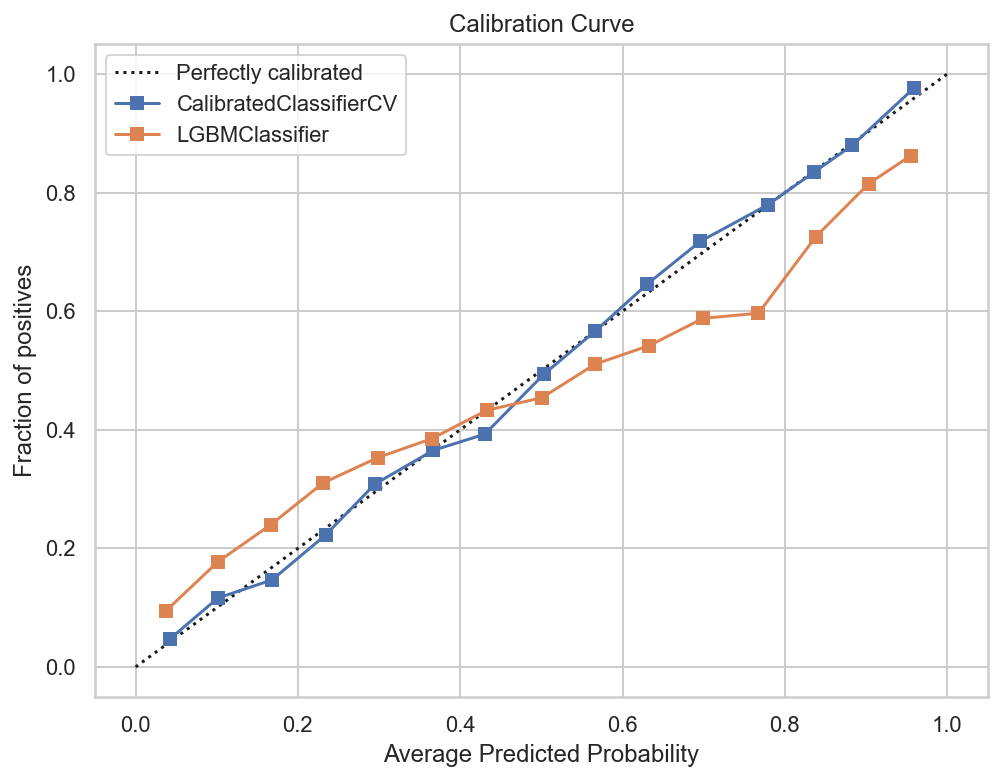

In [168]:
# Define o número de bins
BINS = 15

# Predição das probabilidades
lgbm_tuned_model_probs = lgbm_tuned_model.predict_proba(X_test_prep)
calibrated_lgbm_probs = calibrated_lgbm.predict_proba(X_test_prep)


# Plota a curva de calibração para cada modelo 
gu.plot_multiple_calibration_curves([calibrated_lgbm, lgbm_tuned_model], y_test, 
                                 [calibrated_lgbm_probs, lgbm_tuned_model_probs], BINS)

# Exibe o gráfico
plt.show()

 Visualmente falando, o modelo calibrado parece ser melhor. No entanto, precisamos verificar uma métrica que nos dará um número: Brier Score Loss.

Recomendação de leitura:  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html

In [169]:
# Calcula a Brier Score Loss
bsl_lgbm_model = brier_score_loss(y_test, lgbm_tuned_model_probs[:,1], pos_label=1)
bsl_lgbm_calibrated = brier_score_loss(y_test, calibrated_lgbm_probs[:,1], pos_label=1)

# Mostra a Brier Score Loss calculada para cada algoritmo de probabilidade
print(f'Brier Score Loss (CatBoost Classifier (Tunned HP)): {bsl_lgbm_model}')
print(f'Brier Score Loss (CatBoost Classifier (Tunned HP + Calibrated)): {bsl_lgbm_calibrated}')

# Faz o check qual de qual é o mais bem calibrado
if bsl_lgbm_calibrated < bsl_lgbm_model:
    print('\nO modelo calibrado tem a melhor calibração.')
else:
    print('\nO modelo descalibrado tem a melhor calibração.')

Brier Score Loss (CatBoost Classifier (Tunned HP)): 0.18800040743463467
Brier Score Loss (CatBoost Classifier (Tunned HP + Calibrated)): 0.17934891803297398

O modelo calibrado tem a melhor calibração.


## 9.2 Métricas do modelo calibradas

In [170]:
# Definir o threshold
THRESHOLD = 0.45

# define a lista de classificadores
classifiers = [calibrated_lgbm, lgbm_tuned_model]

# calcula o desempenho dos classificadores
df_performance = gu.get_classifiers_performance(X_balanced, X_test_prep, 
                                                np.ravel(y_balanced), np.ravel(y_test), 
                                                THRESHOLD, classifiers)

df_performance.style.highlight_max(color='darkorange')

Training CalibratedClassifierCV...
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current v

## 9.3 Modelo calibrado - Curva ROC

Recomendação de leitura:  https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

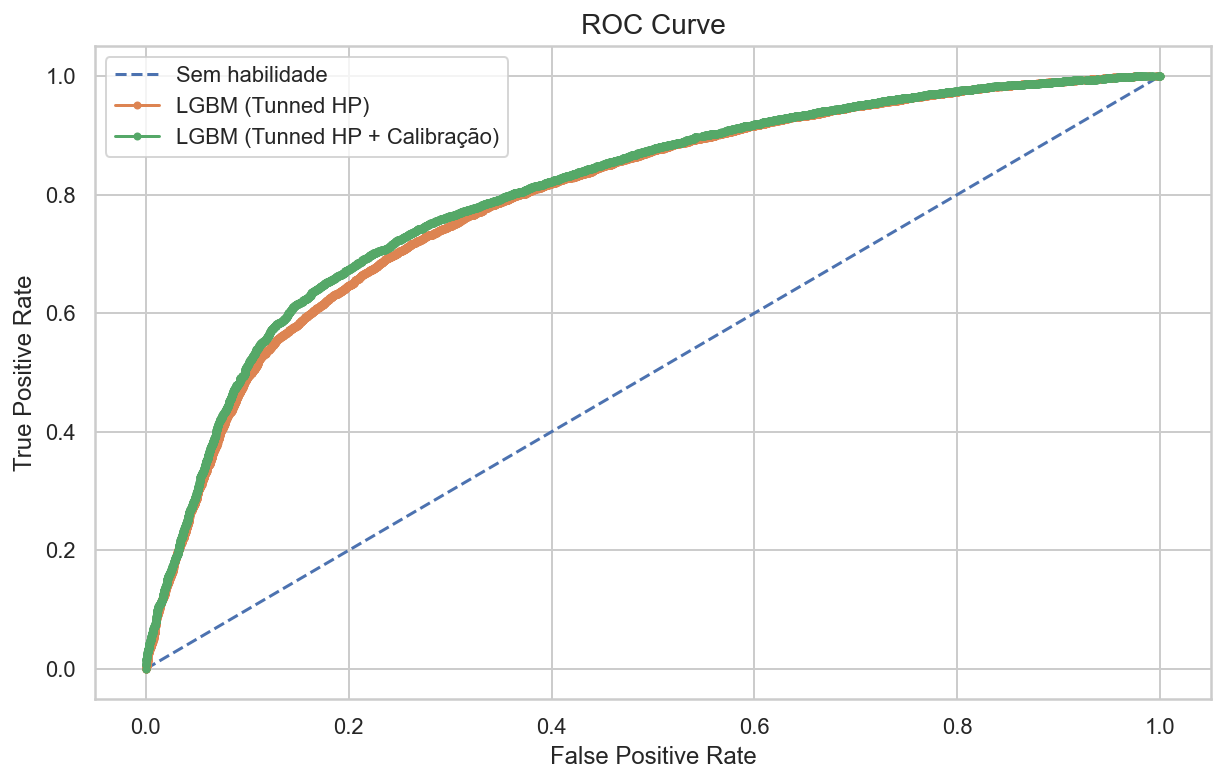

In [171]:
# usar a variável ax para cada Axes
fig, ax = plt.subplots()

# Definir o tamanho do gráfico
ax.figure.set_size_inches(10, 6)

# Gerar um previsão sem habilidade/algoritmo (classe majoritária)
ns_probs = [0 for _ in range(len(y_test))]

# Calculo da curva ROC
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
tuned_fpr, tuned_tpr, _ = roc_curve(y_test, lgbm_tuned_model_probs[:,1])
cal_fpr, cal_tpr, _ = roc_curve(y_test, calibrated_lgbm_probs[:,1])

# Plot da curva ROC para o modelo
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sem habilidade')
plt.plot(tuned_fpr, tuned_tpr, marker='.', label='LGBM (Tunned HP)')
plt.plot(cal_fpr, cal_tpr, marker='.', label='LGBM (Tunned HP + Calibração)')

# Definir o nome dos eixos
plt.title("ROC Curve", fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# carregar legenda
plt.legend()

# carregar gráfico
plt.show()

## 9.4 Modelo Calibrado - Matriz de confusão

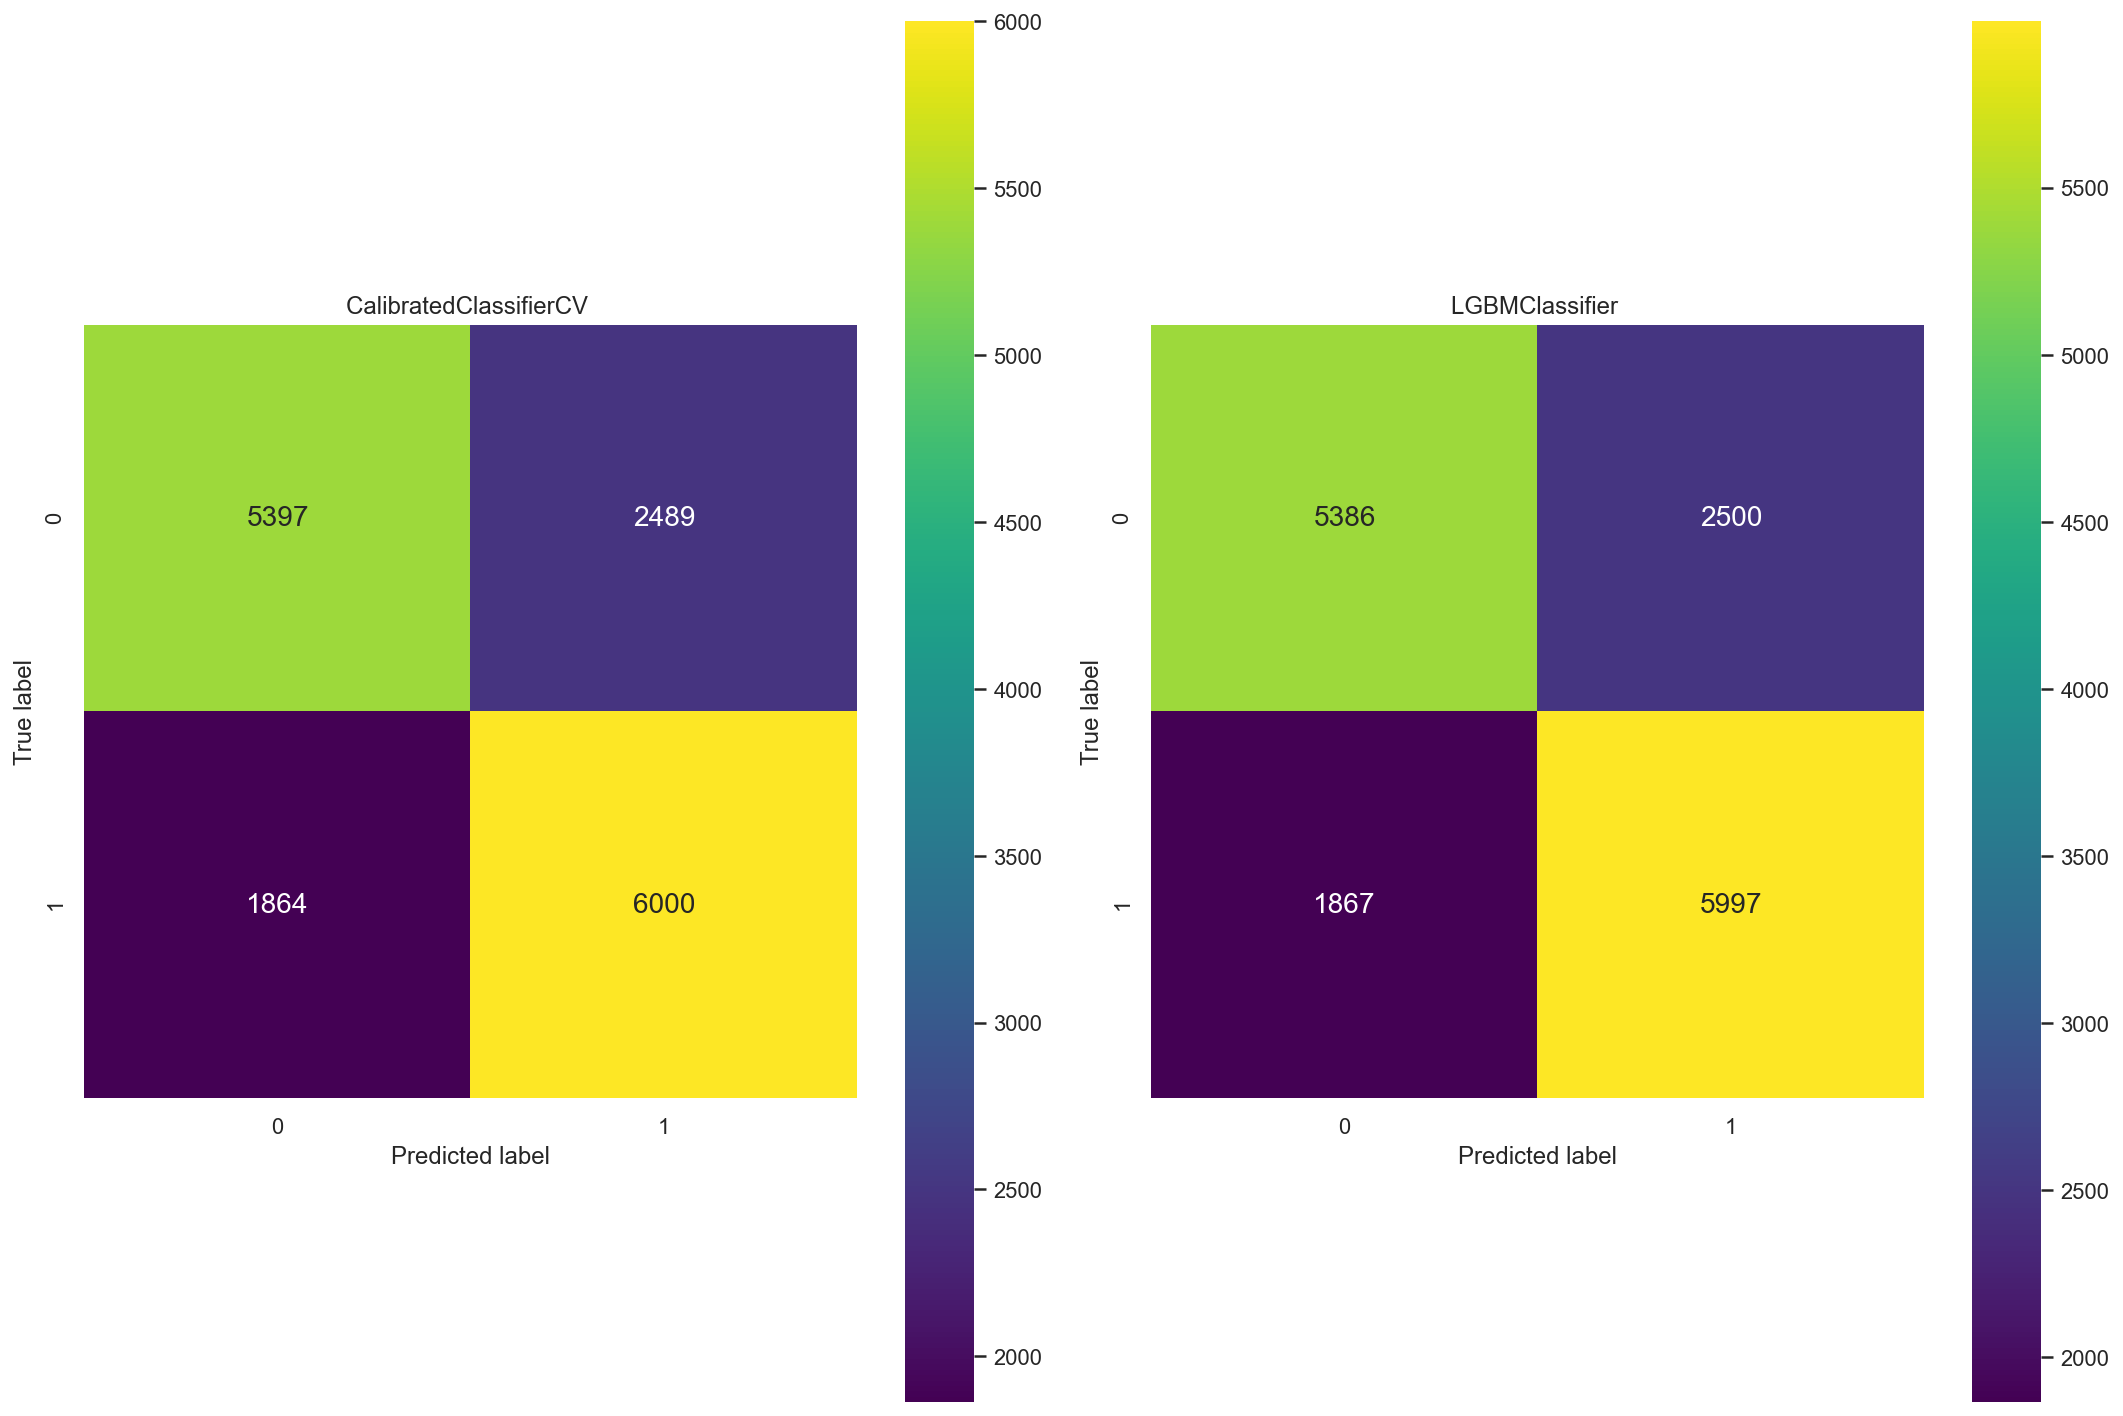

In [172]:
# Define a lista de classificadores
classifiers = [calibrated_lgbm, lgbm_tuned_model]

# Plota o gráfico da matriz de confusão
gu.plot_multiple_confusion_matrices(1, 2, X_test_prep, y_test, classifiers, THRESHOLD)

## 9.5 Modelo Calibrado - cross validation-score

Agora, devemos usar a pontuação de validação cruzada com cross_val_score() para verificar o desempenho geral.

Recomendação de leitura:  https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics

In [173]:
# Definir a estratégia da cross-val
cv = StratifiedKFold(n_splits=10)

In [174]:
# Calcular o score da cross validation
cv_scores = cross_val_score(calibrated_lgbm, X_full, np.ravel(y_full), cv = cv, scoring='precision', n_jobs=-1)

# imprime a precisão média e o desvio padrão das pontuações
print("precision média: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# Calcular o score da cross validation
cv_scores = cross_val_score(calibrated_lgbm, X_full, np.ravel(y_full), cv = cv, scoring='recall', n_jobs=-1)

# imprime a Recall média e o desvio padrão das pontuações
print("\nRecall média: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# Calcular o score da cross validation
cv_scores = cross_val_score(calibrated_lgbm, X_full, np.ravel(y_full), cv = cv, scoring='f1', n_jobs=-1)

# imprime a F1-score médio e o desvio padrão das pontuações
print("\nF1-score médio: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# Calcular o score da cross validation
cv_scores = cross_val_score(calibrated_lgbm, X_full, np.ravel(y_full), cv = cv, scoring='roc_auc', n_jobs=-1)

# imprime a ROC AUC média e o desvio padrão das pontuações
print("\nROC AUC médio: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))

precision média: 0.7539 (+/- 0.0091)

Recall média: 0.6976 (+/- 0.0140)

F1-score médio: 0.7246 (+/- 0.0054)

ROC AUC médio: 0.8010 (+/- 0.0065)


In [175]:
# Calculo da cross validation score
cv_scores = cross_val_score(calibrated_lgbm, X_full, np.ravel(y_full), cv = cv, scoring='precision', n_jobs=-1)

price_per_percent = 500/5
baseline = 50
num_pacients = 70000

model_accuracy = cv_scores.mean()
deviation = cv_scores.std() * 2

accuracy_lower = (model_accuracy - deviation) * 100
accuracy_upper = (model_accuracy + deviation) * 100

percent_difference_lower = accuracy_lower - baseline
percent_difference_upper = accuracy_upper - baseline

amount_best = percent_difference_upper * price_per_percent * num_pacients
amount_worst = percent_difference_lower * price_per_percent * num_pacients

In [176]:
print(f'Melhor:  ${round(amount_best, 2):,.2f}')
print(f'Pior  : ${round(amount_worst, 2):,.2f}')

Melhor:  $184,088,658.06
Pior  : $171,322,731.06


## 9.6 Resumo da cross val

In [177]:
# define a lista de classificadores
classifiers = [calibrated_lgbm, lgbm_tuned_model]


# calcula o desempenho dos classificadores
df_performance = gu.get_classifiers_performance(X_balanced, X_test_prep, 
                                                np.ravel(y_balanced), np.ravel(y_test), 
                                                THRESHOLD, classifiers)

df_performance.style.highlight_max(color='darkorange')

Training CalibratedClassifierCV...
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current v

Embora o modelo Tuned HP + Calibrado tenha uma pontuação e recall um pouco mais baixos de F1, ele tem uma precisão maior que é justa o suficiente para as necessidades do nosso projeto. Além disso, por estar calibrado, nas previsões futuras será mais estável e confiante o que é bom tanto para os negócios quanto para os pacientes.

## 9.6 Salvando o Modelo Calibrado

In [178]:
# salvando o modelo
pickle.dump(calibrated_lgbm, open('modelo/calibrated_model_ccd.pkl', 'wb'))

# 10.0 Business performance

 Vamos recapitular o modelo de preços. O preço do diagnóstico, pago pelo cliente, varia de acordo com a precisão alcançada pela equipe de especialistas.

In [179]:
# Definir coluna das regras
cols = ['Precisão do exame','Preço','Regras','Exemplo']

# Definindo as linhas
line1 = ['Acima de 50%', 'Mínimo $500','+$500 para cada\n precisão adicional de 5%','Precisão = \n55% -> $1.000.00']
line2 = ['Até 50%', 'Mínimo $500',np.nan,np.nan]

# Montando Tabela e Redefinindo o index
regras = pd.DataFrame(columns=cols, data=[line1,line2]).set_index('Precisão do exame')

# Mostra tabela
regras

Preço                                      Regras                        Exemplo
Precisão do exame                                                                                        
Acima de 50%       Mínimo $500  +$500 para cada\n precisão adicional de 5%  Precisão = \n55% -> $1.000.00
Até 50%            Mínimo $500                                         NaN                            NaN

Nosso conjunto completo de dados originais contém os registros de 70.000 pacientes. Suponha que nós íamos fazê-los passar pelo procedimento clínico para verificar se eles têm uma doença cardiovascular, nosso modelo atingiu uma precisão que varia de 72,7% a 73,9%, o que é maior do que os 55% a 65% que temos nos procedimentos de hoje. Assim, traduzindo-o para números de negócios.

In [180]:
# Definir coluna das regras
cols = ['Modelo','Melhor','Pior']

# Definindo as linhas
line1 = ['Nosso Modelo', amount_best, amount_worst]
line2 = ['Hoje (Como é)', '$105,000,000.00','$35,000,000.00']

# Montando Tabela e Redefinindo o index
regras = pd.DataFrame(columns=cols, data=[line1,line2]).set_index('Modelo')

# Mostra tabela
regras

Melhor             Pior
Modelo                                         
Nosso Modelo  184,088,658.0601 171,322,731.0611
Hoje (Como é)  $105,000,000.00   $35,000,000.00

Isso significa que ter um portfólio de 70 mil pacientes que passariam pelo procedimento clínico para verificar se eles têm ou não uma doença cardiovascular, no pior cenário de negócios a carteira geraria um lucro de **\$171,7 milhões** e no melhor cenário **\$186,2 milhões**, em contraste com o procedimento de hoje que no seu melhor tem uma precisão de 65% e geraria um total de **\$105 milhões**,  isso é uma diferença de **\$81,2 milhões**!